In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 1. Stocks

In [ ]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import plotly.express as px

stock_and_etfs = pd.read_csv("/content/all_stock_and_etfs.csv", error_bad_lines=False)
stock_and_etfs = stock_and_etfs[::-1]

In [ ]:
stock_and_etfs

Date-Time   Open     High      Low  Close   Volume Ticker_Symbol
163556  1999-11-01   8.38   8.7500   8.3800   8.75     7400           ALG
163555  1999-11-02   8.75   8.8800   8.6200   8.88     7700           ALG
163554  1999-11-03   9.00   9.2500   9.0000   9.19    35000           ALG
163553  1999-11-04   9.31   9.4400   9.3100   9.31     1100           ALG
163552  1999-11-05   9.25   9.5000   9.2500   9.50     2300           ALG
...            ...    ...      ...      ...    ...      ...           ...
4       2024-02-13  29.56  29.8000  28.6350  28.72  4173650           HRL
3       2024-02-14  28.76  28.8254  28.5100  28.80  2690379           HRL
2       2024-02-15  28.94  29.2210  28.8500  29.11  2380372           HRL
1       2024-02-16  29.01  29.1700  28.7650  28.99  5655091           HRL
0       2024-02-20  29.09  29.7100  29.0001  29.44  2673889           HRL

[163557 rows x 7 columns]

In [ ]:
# Function for plotting specific stocks
def plot_stock(ticker):
    data = stock_and_etfs[stock_and_etfs["Ticker_Symbol"] == ticker]
    data = data[::-1]
    data = data.reset_index()
    data = data.drop(["index"], axis = 1)

    #get data
    dfpl = data[:]
    #plot the stock's data
    fig = go.Figure(data=[go.Candlestick(x=dfpl["Date-Time"],
                    open=dfpl['Open'],
                    high=dfpl['High'],
                    low=dfpl['Low'],
                    close=dfpl['Close'])])

    fig.show()

### Experiment with other tickers

In [ ]:
stock_and_etfs[stock_and_etfs['Ticker_Symbol'] == "ALG"]

Date-Time    Open    High      Low   Close  Volume Ticker_Symbol
163556  1999-11-01    8.38    8.75    8.380    8.75    7400           ALG
163555  1999-11-02    8.75    8.88    8.620    8.88    7700           ALG
163554  1999-11-03    9.00    9.25    9.000    9.19   35000           ALG
163553  1999-11-04    9.31    9.44    9.310    9.31    1100           ALG
163552  1999-11-05    9.25    9.50    9.250    9.50    2300           ALG
...            ...     ...     ...      ...     ...     ...           ...
157447  2024-02-13  218.72  218.72  210.290  212.25  114443           ALG
157446  2024-02-14  215.99  218.74  210.010  217.74   64395           ALG
157445  2024-02-15  218.52  222.00  217.616  221.20   60130           ALG
157444  2024-02-16  219.67  222.00  217.300  217.33   91642           ALG
157443  2024-02-20  214.45  217.16  213.560  215.92   64717           ALG

[6114 rows x 7 columns]

In [ ]:
plot_stock("ALG")

## Correlation of Meat Statistics with Stock Prices



In [ ]:
stock_and_etfs = pd.read_csv("/content/all_stock_and_etfs.csv", error_bad_lines=False)
stock_and_etfs = stock_and_etfs[::-1]
stock_and_etfs['Date'] = pd.to_datetime(stock_and_etfs['Date-Time'])
stock_and_etfs = stock_and_etfs.drop('Date-Time', axis=1)
stock_and_etfs.index = stock_and_etfs['Date']

In [86]:
meat_prod = pd.read_csv("/content/Meat_Stats_Meat_Production.csv", thousands = ",")
cold_stor = pd.read_csv("/content/Meat_Stats_Cold_Storage.csv", thousands = ",")
slaughter_count = pd.read_csv("/content/Meat_Stats_Slaughter_Counts.csv", thousands = ",")
slaughter_weights = pd.read_csv("/content/Meat_Stats_Slaughter_Weights.csv", thousands = ",")
cold_stor['Animal'] = cold_stor['Animal'].replace('Broiler', 'Broilers')

meat_prod = meat_prod.dropna()
meat_prod.index = pd.to_datetime(meat_prod["Date"])

cold_stor = cold_stor.dropna()
cold_stor.index = pd.to_datetime(cold_stor["Date"])

slaughter_count = slaughter_count.dropna()
slaughter_count.index = pd.to_datetime(slaughter_count["Date"])

slaughter_weights = slaughter_weights.dropna()
slaughter_weights.index = pd.to_datetime(slaughter_weights["Date"])

In [ ]:
def upsample_meat(df, group_name="Animal", value_name="Production"):
  df = df[::-1] # Reverse cos data is reversed
  df_daily = df.groupby(group_name).apply(lambda x: x.drop_duplicates('Date').resample("1d").ffill())
  df_daily[f"Daily {value_name}"] = df_daily[value_name] / pd.to_datetime(df_daily["Month"]).dt.daysinmonth
  df_daily["Date"] = df_daily.index.get_level_values("Date")
  return df_daily

def plot_meat(df, group="Beef", y=f"Daily Production"):
  df = df.loc[group]
  fig = go.Figure(data=px.line(df, x="Date", y=y))
  fig.show()

In [ ]:
meat_prod_daily = upsample_meat(meat_prod, "Animal", "Production")
cold_stor_daily = upsample_meat(cold_stor, "Animal", "Weight")
slaughter_count_daily = upsample_meat(slaughter_count, "Animal", "Count")
slaughter_weights_daily = upsample_meat(slaughter_weights, "Animal", "Weight")

### Meat Production

In [ ]:
meat_prod_daily = upsample_meat(meat_prod_cleaned)

def merge_df_with_meat(meat_df, df, meat="Beef", value_name="Daily Production"):
  temp = meat_df.loc[meat][value_name]
  temp.name = meat
  return df.merge(temp, on = "Date")

def get_stock_with_meats(meat_df = meat_prod_daily, ticker = "HRL"):
  temp = stock_and_etfs[stock_and_etfs['Ticker_Symbol'] == ticker]
  for meat in meat_df["Animal"].unique():
    temp = merge_df_with_meat(meat_df, temp, meat)
  return temp

# Food Processing companies
HRL = get_stock_with_meats("HRL")
ADM = get_stock_with_meats("ADM")
CAG = get_stock_with_meats("CAG")
HSY = get_stock_with_meats("HSY")
GIS = get_stock_with_meats("GIS")

# Soft Drinks

# Fast Food
QSR = get_stock_with_meats("QSR")
PPC = get_stock_with_meats("PPC")
TSN = get_stock_with_meats("TSN")
CMG = get_stock_with_meats("CMG")
WEN = get_stock_with_meats("WEN")
YUM = get_stock_with_meats("YUM")
MCD = get_stock_with_meats("MCD")
DPZ = get_stock_with_meats("DPZ")

In [ ]:
def plot_corr(stocks_with_meats, columns, annot=False):
  # n representing an n x n subplot figure
  n = int(len(stocks_with_meats) ** (1/2))
  if n ** 2 < len(stocks_with_meats):
    n += 1

  # Set up the matplotlib figure
  f, axes = plt.subplots(n, n, figsize=(20, 20))

  for num, stock in enumerate(stocks_with_meats):
    corr = stock[columns].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Determine x and y positions of the next plot
    x_pos = num % n
    y_pos = num // n

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                ax=axes[y_pos][x_pos],
                annot=annot
                ).set(title=stock["Ticker_Symbol"].iloc[0])

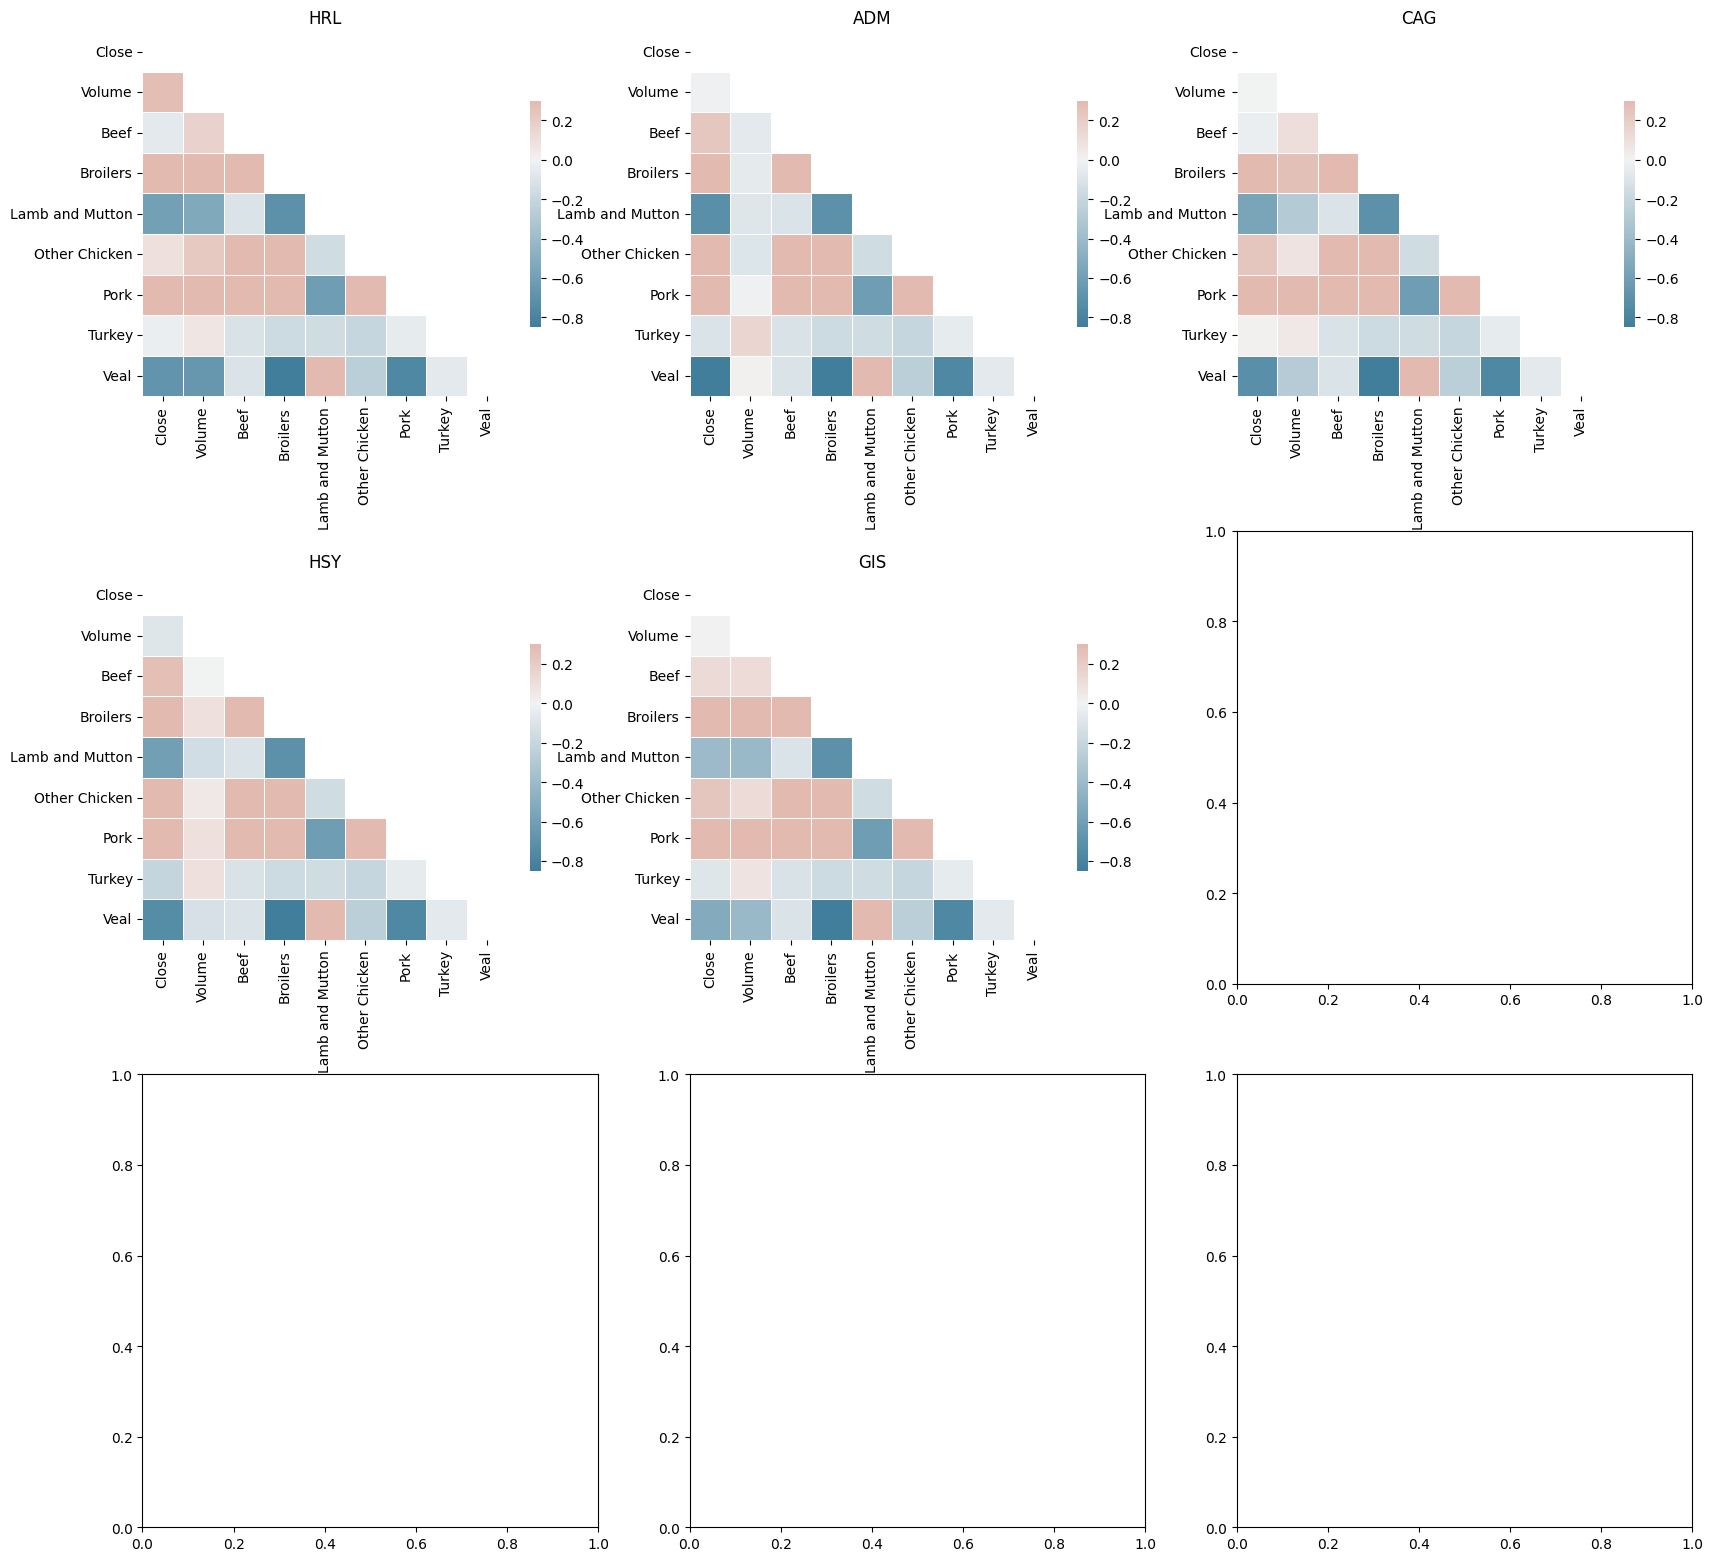

In [ ]:
# Plot for Processed Food Companies
plot_corr([HRL, ADM, CAG, HSY, GIS], ['Close', 'Volume', 'Beef', 'Broilers', 'Lamb and Mutton', 'Other Chicken', 'Pork', 'Turkey', 'Veal'])

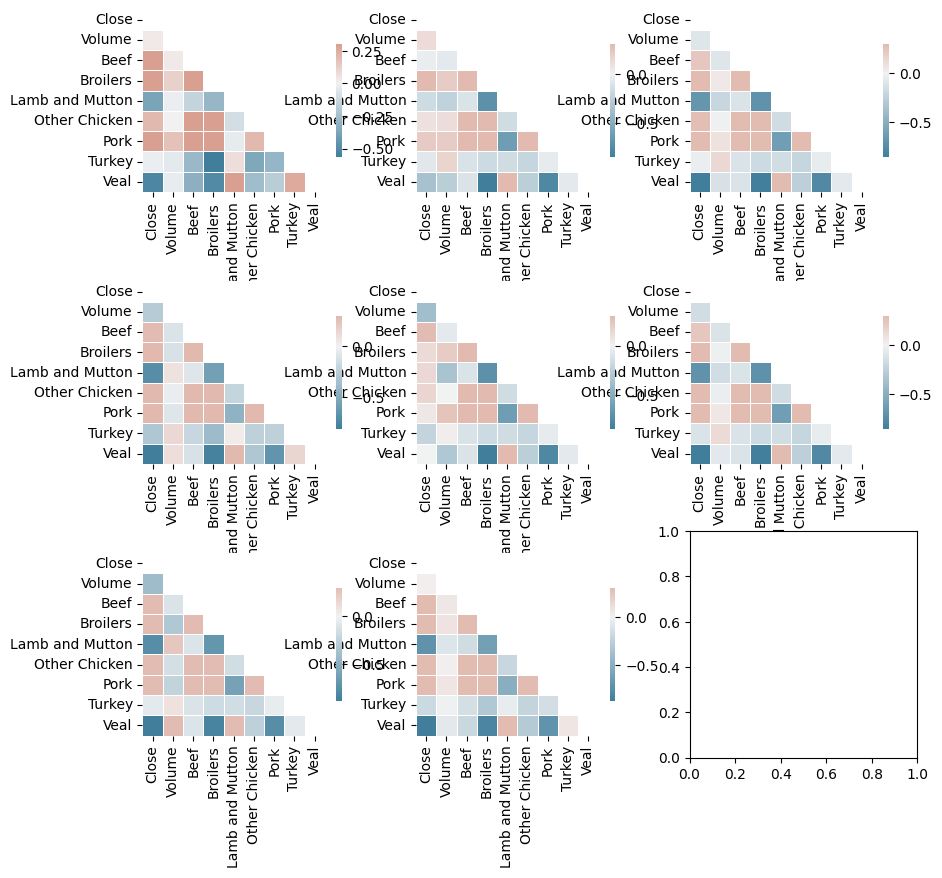

In [ ]:
# Plot for Fast Food Companies
plot_corr([QSR, PPC, TSN, CMG, WEN, YUM, MCD, DPZ], ['Close', 'Volume', 'Beef', 'Broilers', 'Lamb and Mutton', 'Other Chicken', 'Pork', 'Turkey', 'Veal'])

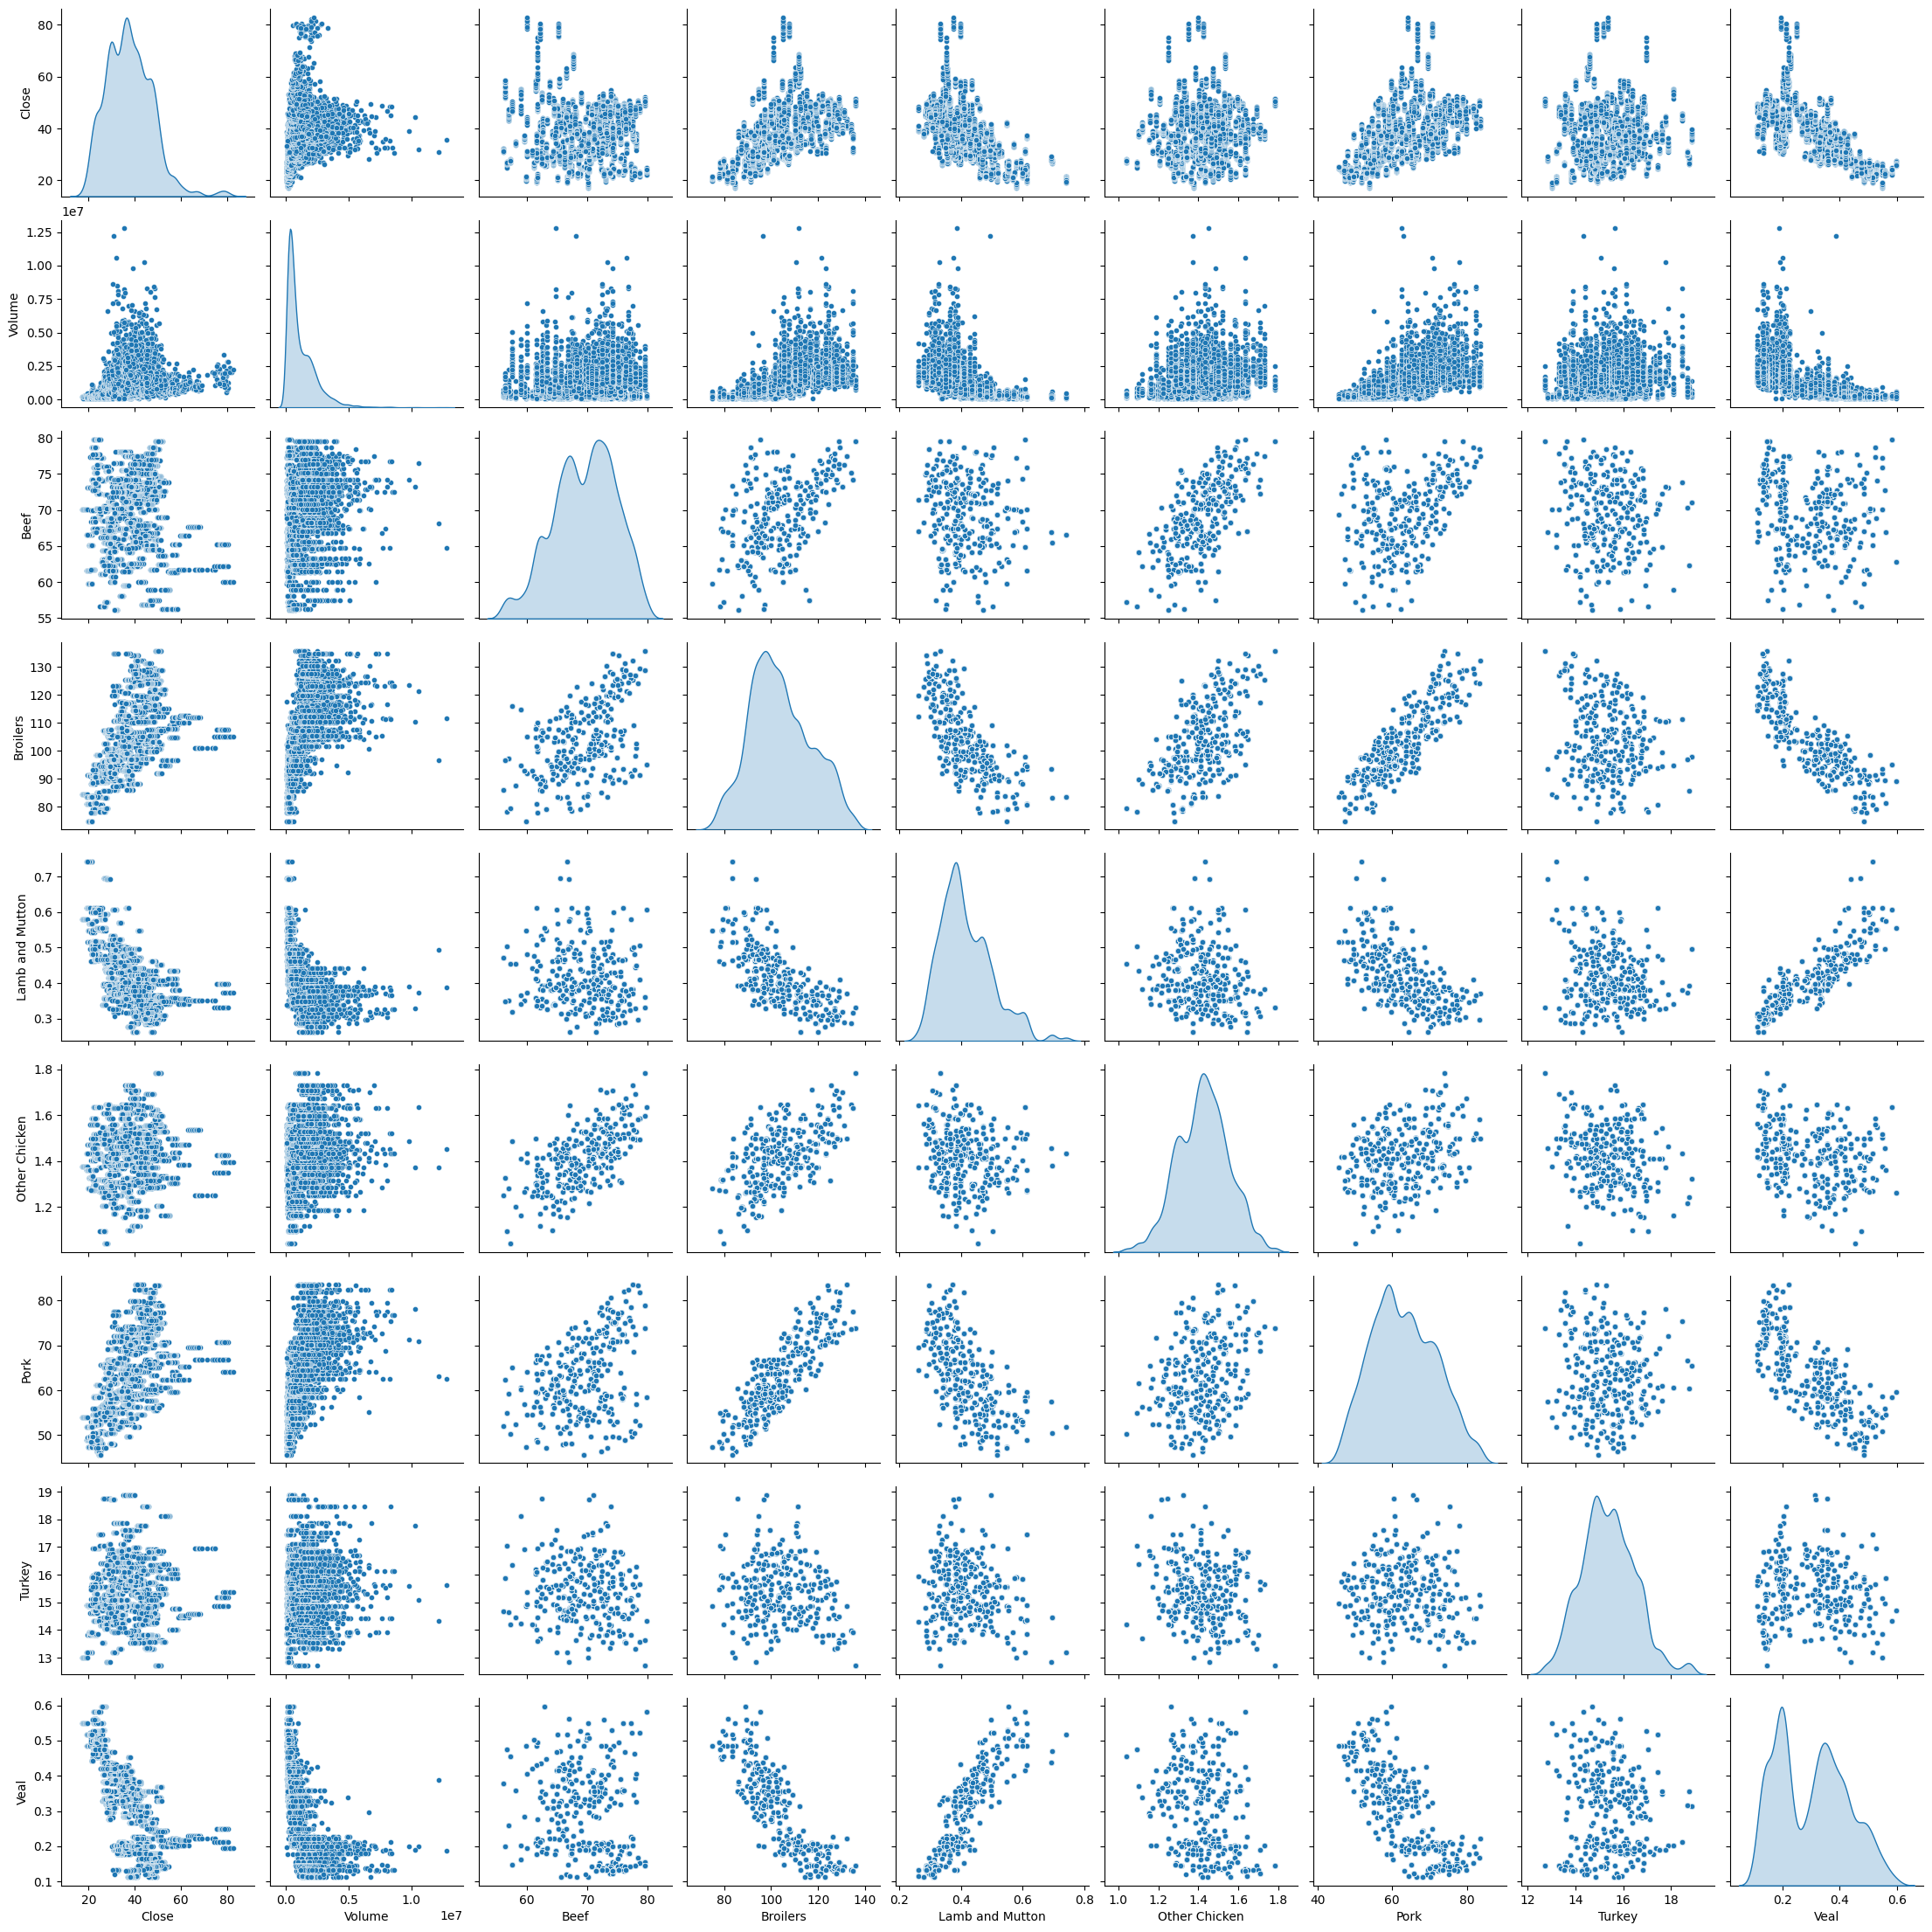

In [ ]:
sns.pairplot(
    data=HRL,
		vars=['Close', 'Volume', 'Beef', 'Broilers', 'Lamb and Mutton', 'Other Chicken', 'Pork', 'Turkey', 'Veal'],
		diag_kind='kde',
	  kind='scatter',
    # palette='muted',
	  plot_kws={'s': 20}
    )
plt.show()

In [ ]:
meat_prod_cleaned_daily = upsample_meat(meat_prod_cleaned, "Animal")

### Cold Storage

In [ ]:
# Food Processing companies
HRL = get_stock_with_meats(cold_stor_daily, "HRL", "Daily Weight")
ADM = get_stock_with_meats(cold_stor_daily, "ADM", "Daily Weight")
CAG = get_stock_with_meats(cold_stor_daily, "CAG", "Daily Weight")
HSY = get_stock_with_meats(cold_stor_daily, "HSY", "Daily Weight")
GIS = get_stock_with_meats(cold_stor_daily, "GIS", "Daily Weight")

# Soft Drinks

# Fast Food
QSR = get_stock_with_meats(cold_stor_daily, "QSR", "Daily Weight")
PPC = get_stock_with_meats(cold_stor_daily, "PPC", "Daily Weight")
TSN = get_stock_with_meats(cold_stor_daily, "TSN", "Daily Weight")
CMG = get_stock_with_meats(cold_stor_daily, "CMG", "Daily Weight")
WEN = get_stock_with_meats(cold_stor_daily, "WEN", "Daily Weight")
YUM = get_stock_with_meats(cold_stor_daily, "YUM", "Daily Weight")
MCD = get_stock_with_meats(cold_stor_daily, "MCD", "Daily Weight")
DPZ = get_stock_with_meats(cold_stor_daily, "DPZ", "Daily Weight")

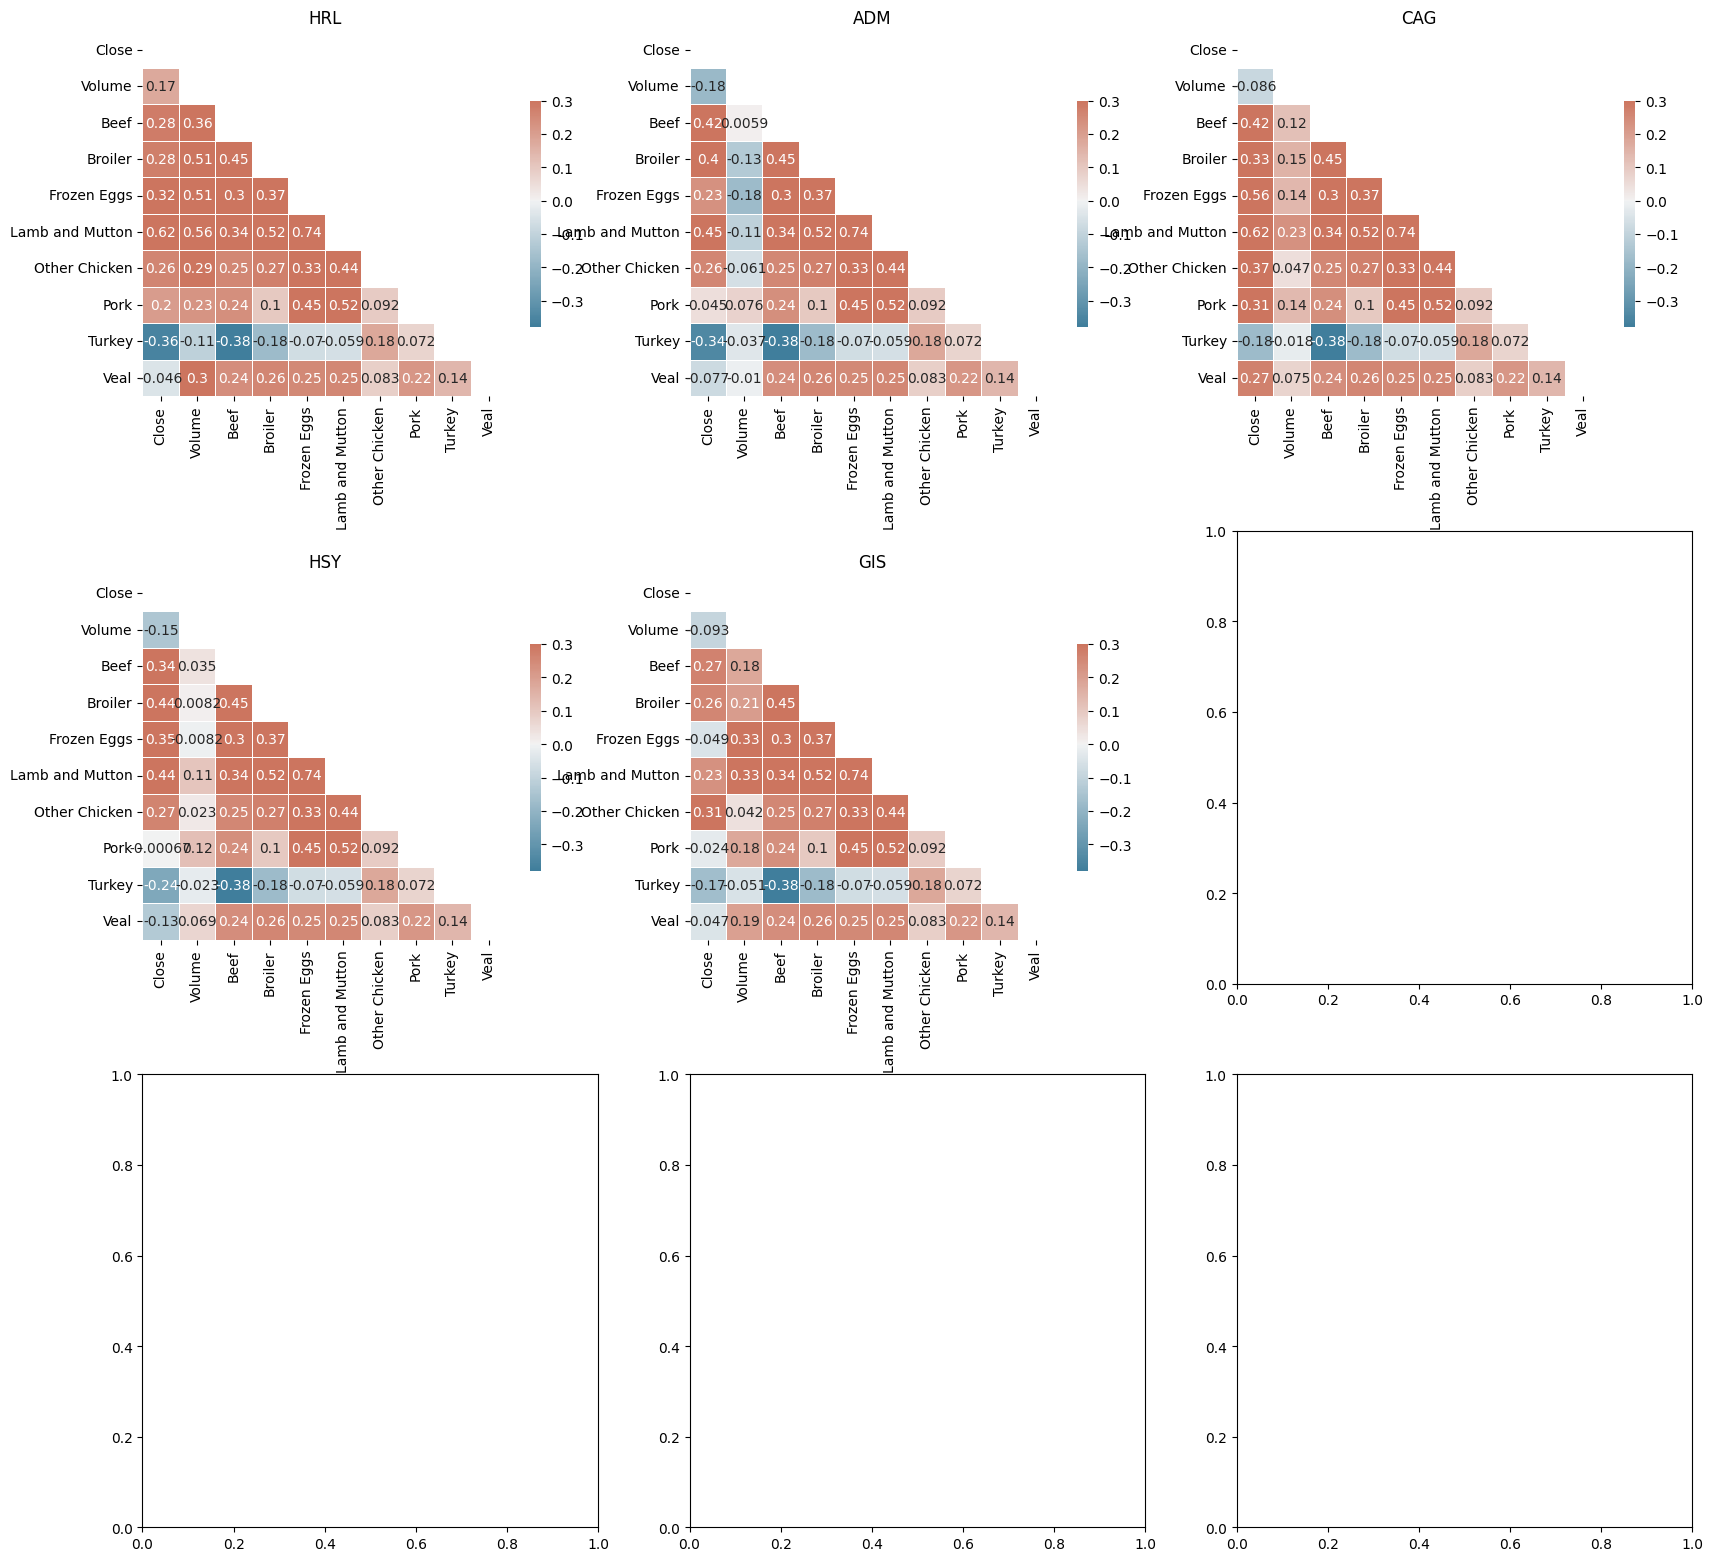

In [ ]:
# Plot for Processed Food Companies
plot_corr([HRL, ADM, CAG, HSY, GIS], ['Close', 'Volume', 'Beef', 'Broiler', 'Frozen Eggs', 'Lamb and Mutton', 'Other Chicken', 'Pork', 'Turkey', 'Veal'], True)

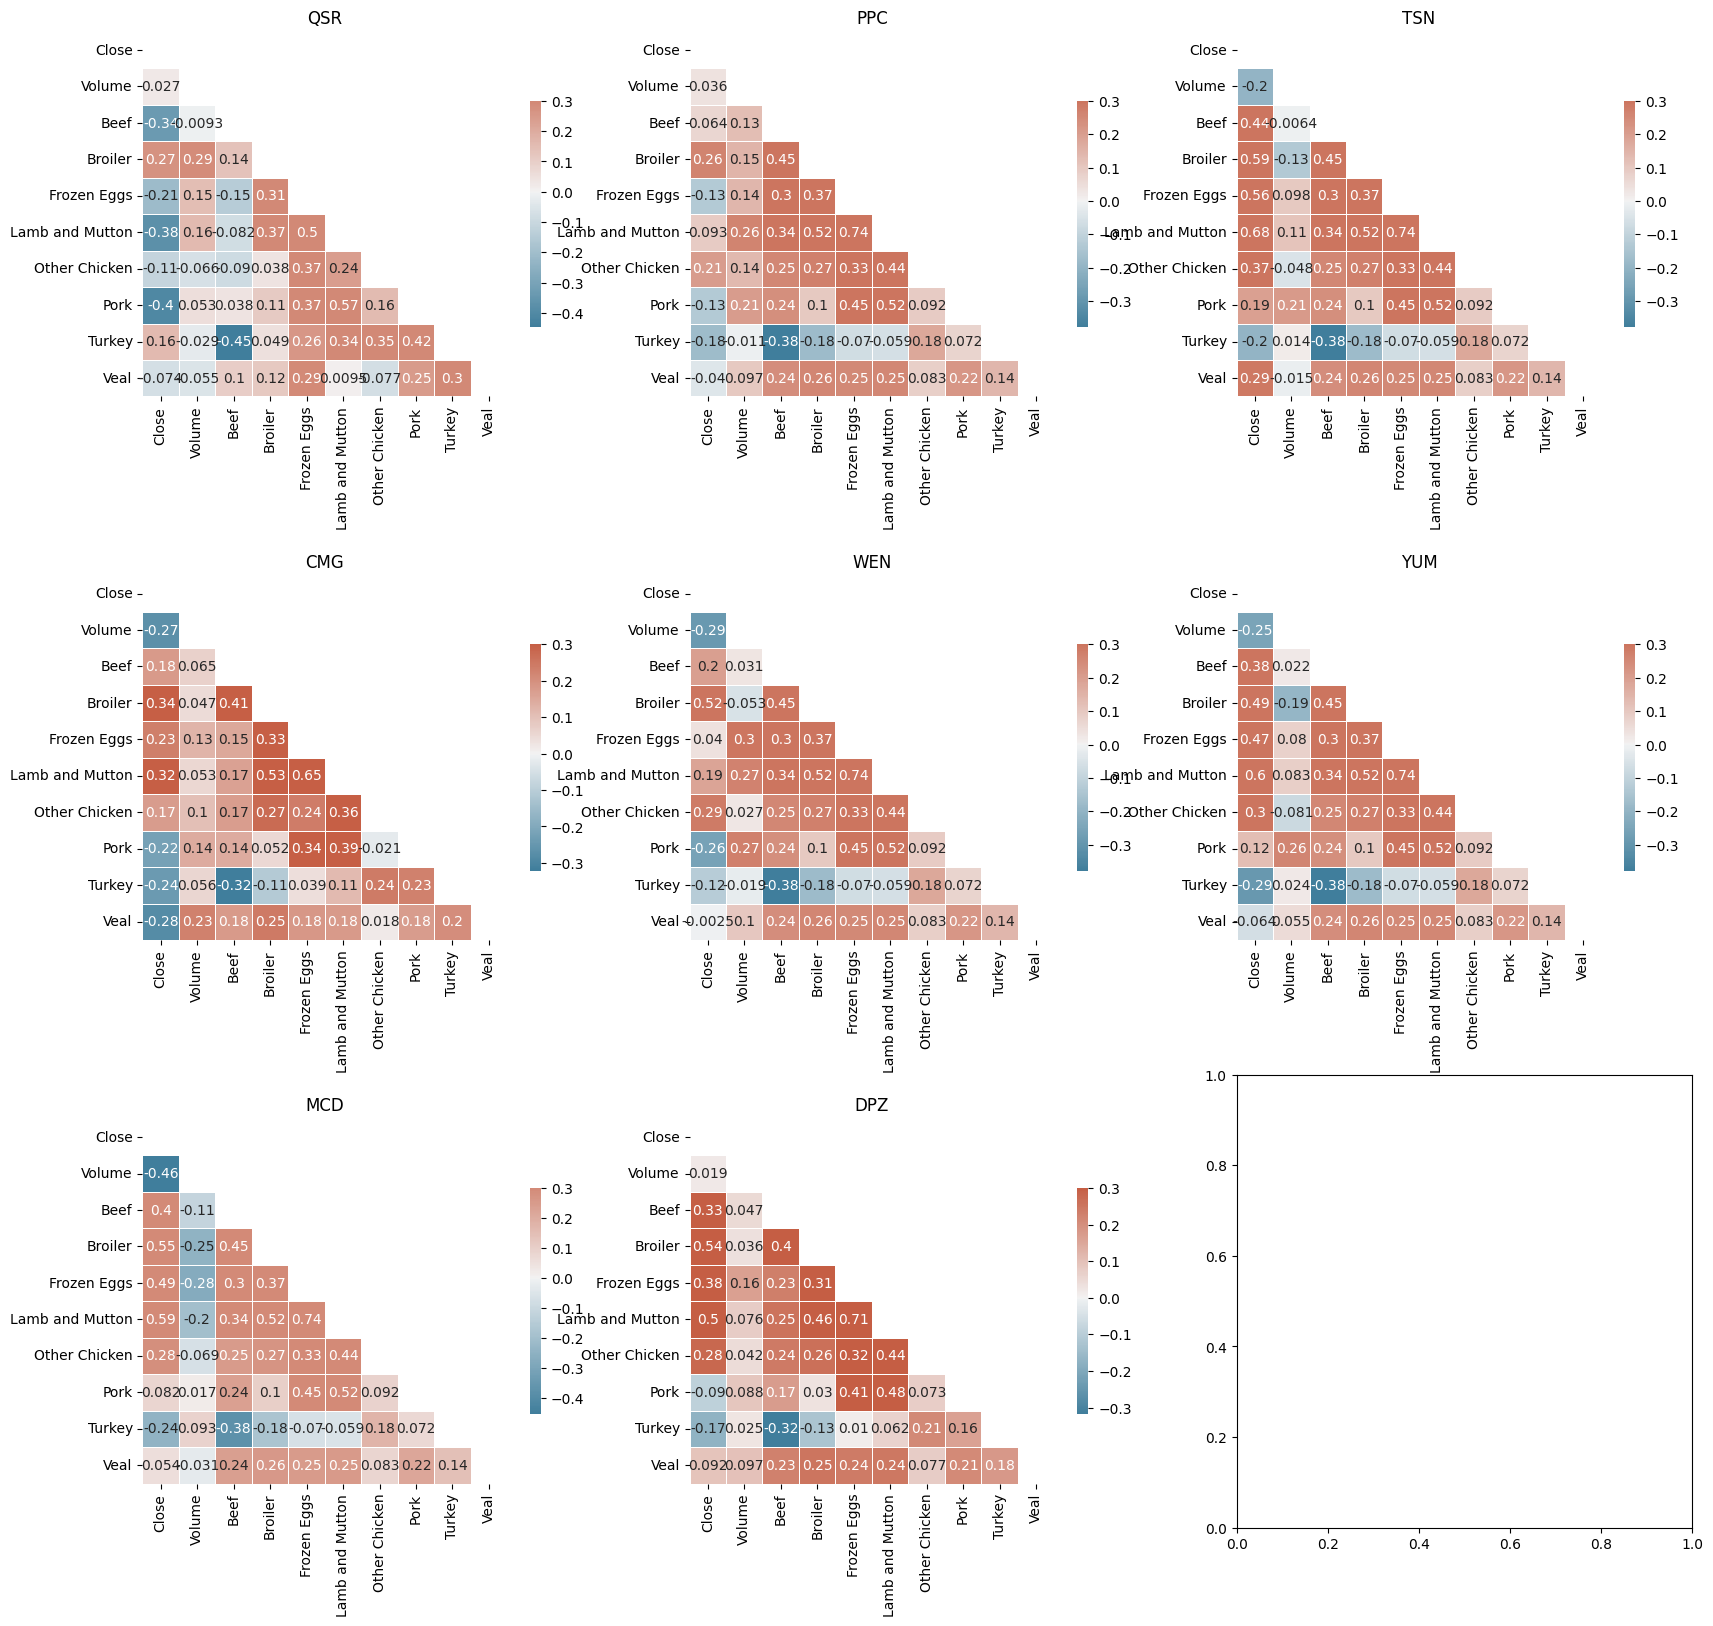

In [ ]:
# Plot for Fast Food Companies
plot_corr([QSR, PPC, TSN, CMG, WEN, YUM, MCD, DPZ], ['Close', 'Volume', 'Beef', 'Broiler', 'Frozen Eggs', 'Lamb and Mutton', 'Other Chicken', 'Pork', 'Turkey', 'Veal'], True)

### Slaughter Counts

In [ ]:
# Food Processing companies
HRL = get_stock_with_meats(slaughter_count_daily, "HRL", "Daily Count")
ADM = get_stock_with_meats(slaughter_count_daily, "ADM", "Daily Count")
CAG = get_stock_with_meats(slaughter_count_daily, "CAG", "Daily Count")
HSY = get_stock_with_meats(slaughter_count_daily, "HSY", "Daily Count")
GIS = get_stock_with_meats(slaughter_count_daily, "GIS", "Daily Count")

# Soft Drinks

# Fast Food
QSR = get_stock_with_meats(slaughter_count_daily, "QSR", "Daily Count")
PPC = get_stock_with_meats(slaughter_count_daily, "PPC", "Daily Count")
TSN = get_stock_with_meats(slaughter_count_daily, "TSN", "Daily Count")
CMG = get_stock_with_meats(slaughter_count_daily, "CMG", "Daily Count")
WEN = get_stock_with_meats(slaughter_count_daily, "WEN", "Daily Count")
YUM = get_stock_with_meats(slaughter_count_daily, "YUM", "Daily Count")
MCD = get_stock_with_meats(slaughter_count_daily, "MCD", "Daily Count")
DPZ = get_stock_with_meats(slaughter_count_daily, "DPZ", "Daily Count")

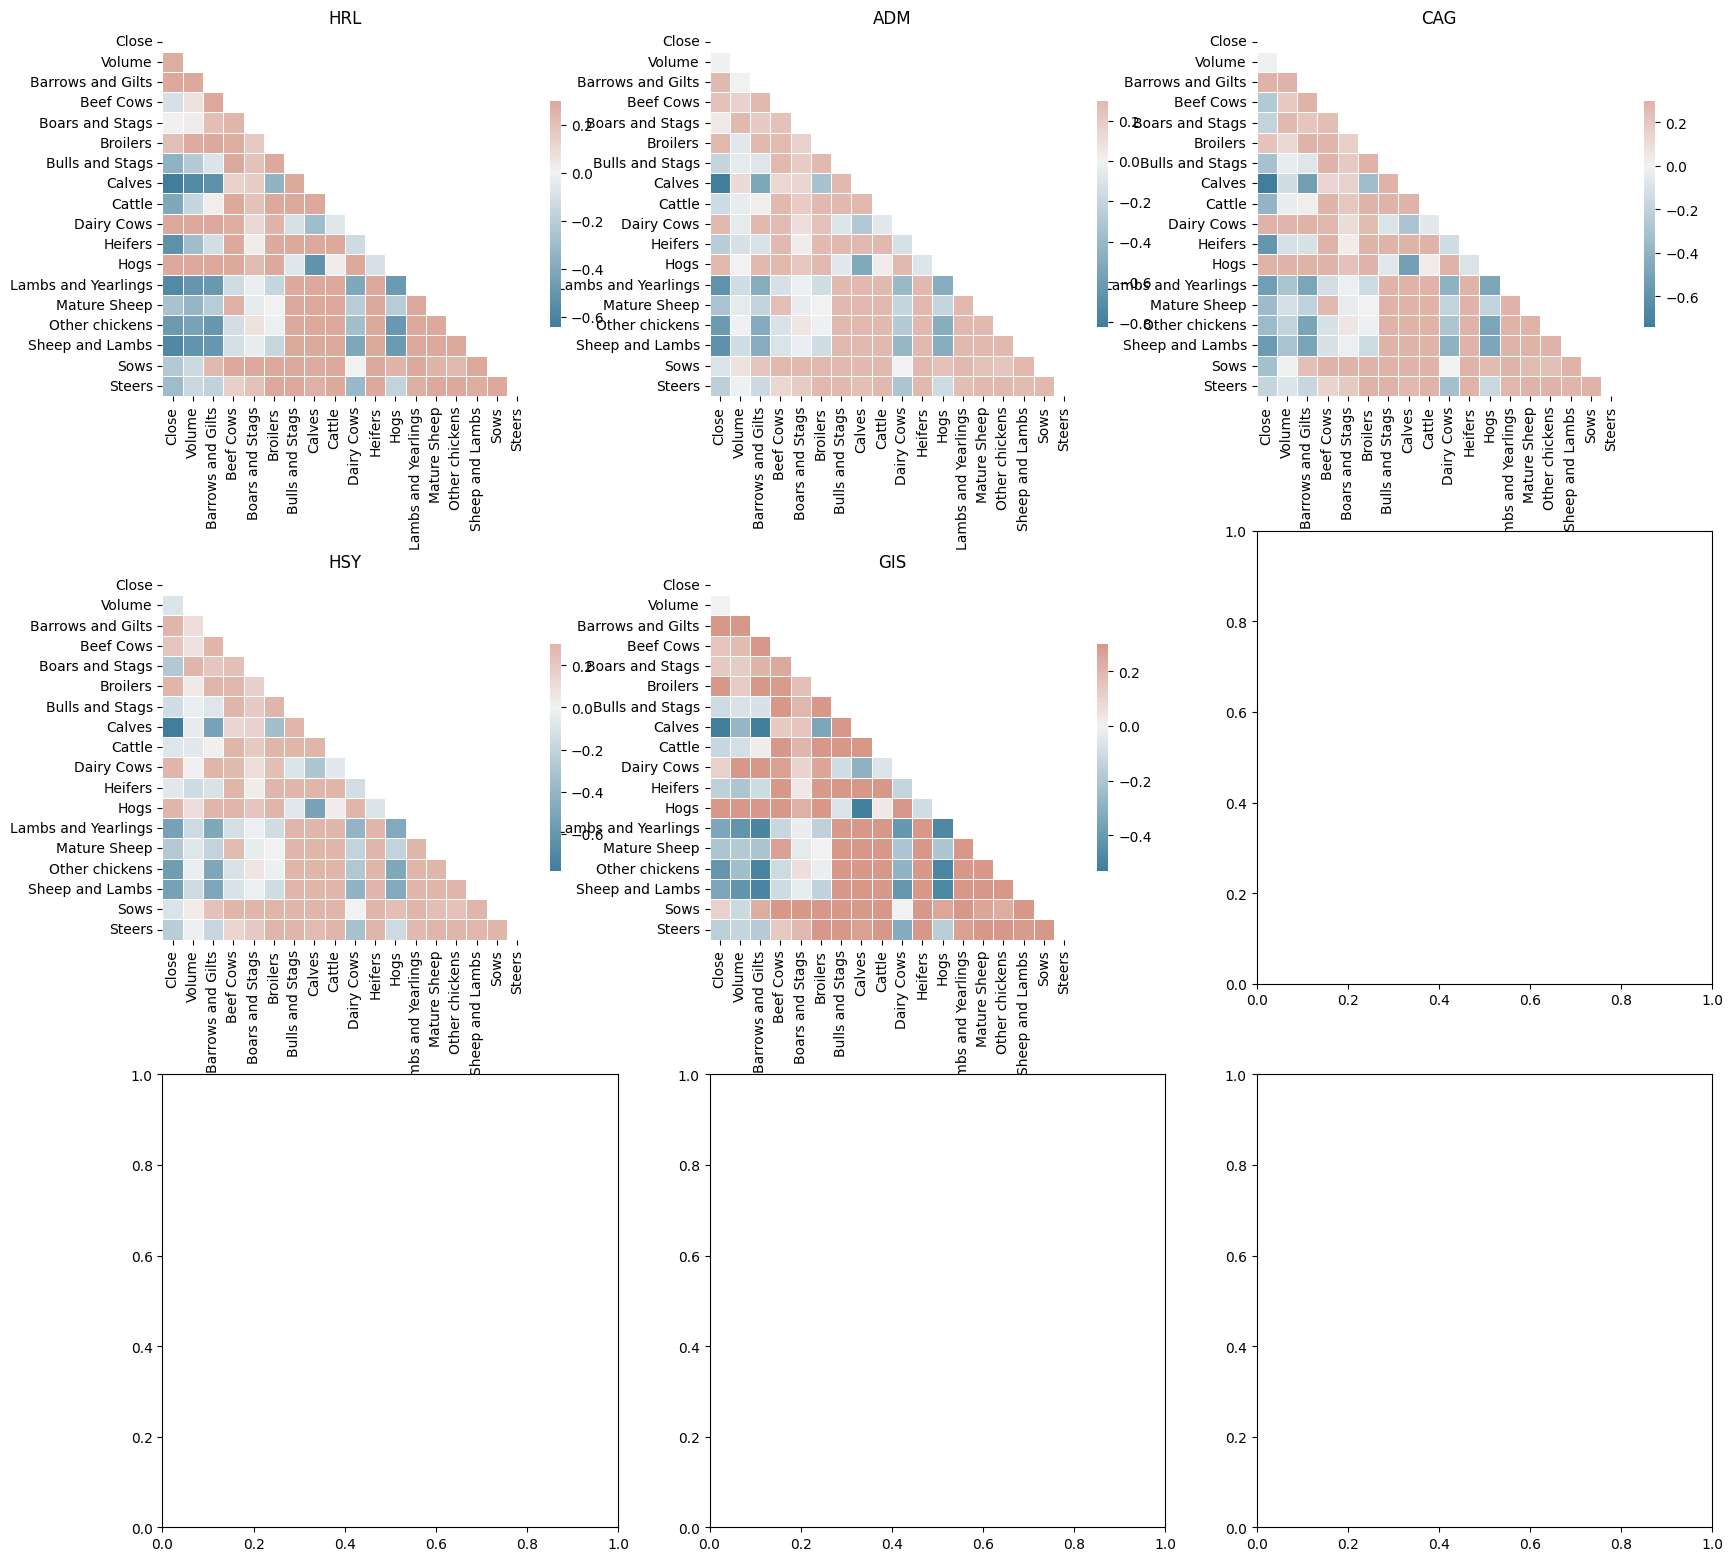

In [ ]:
# Plot for Processed Food Companies
plot_corr([HRL, ADM, CAG, HSY, GIS], ['Close', 'Volume', 'Barrows and Gilts', 'Beef Cows', 'Boars and Stags', 'Broilers', 'Bulls and Stags', 'Calves', 'Cattle', 'Dairy Cows', 'Heifers', 'Hogs', 'Lambs and Yearlings', 'Mature Sheep', 'Other chickens', 'Sheep and Lambs', 'Sows', 'Steers'], False)

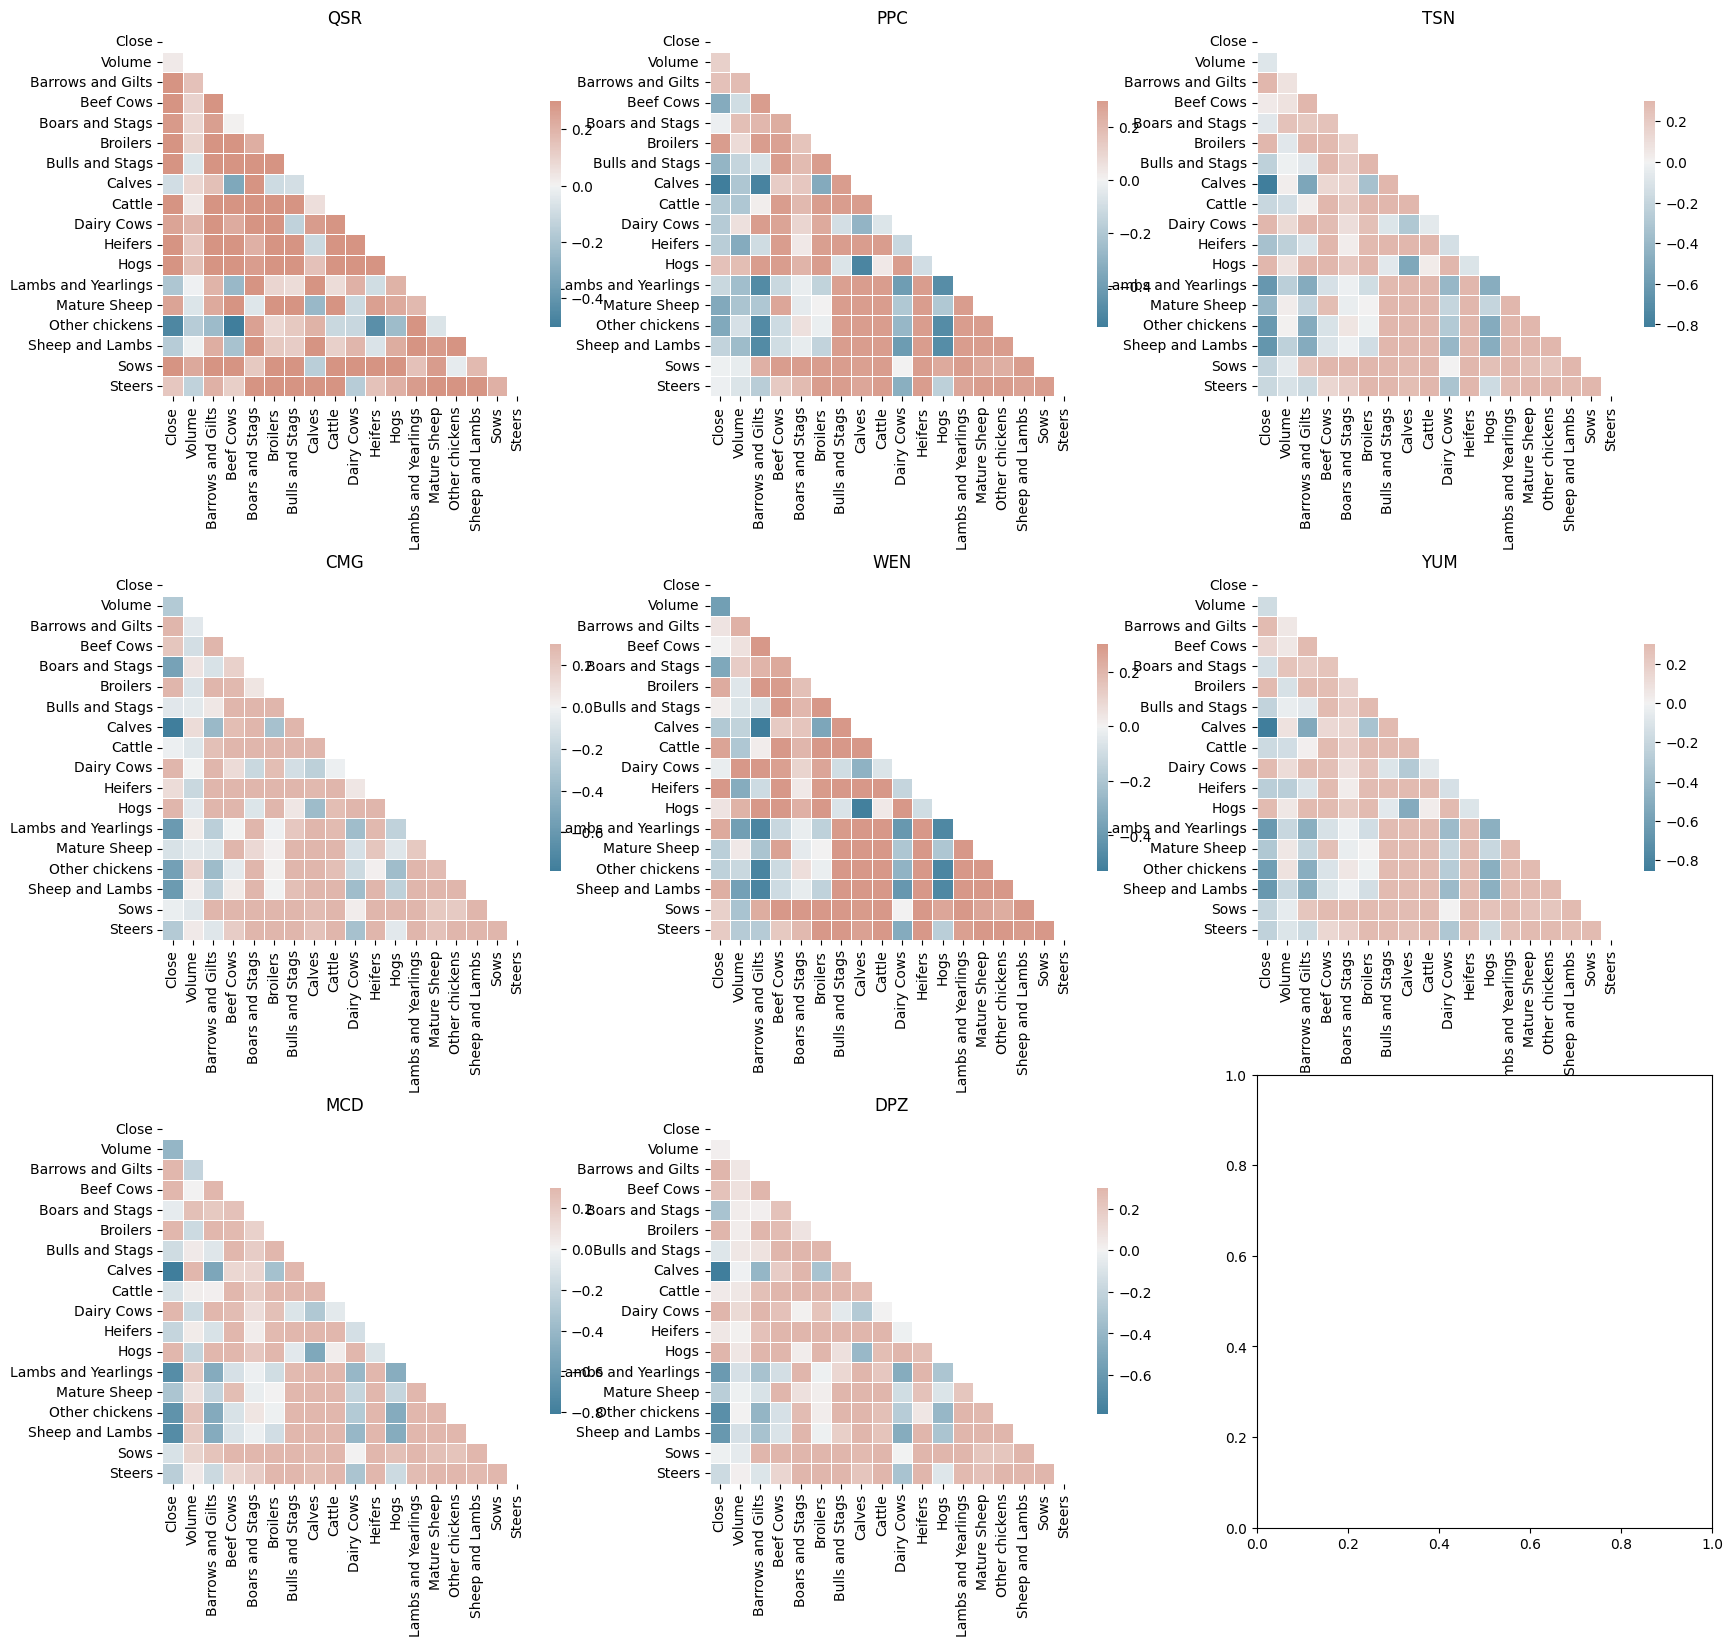

In [ ]:
# Plot for Fast Food Companies
plot_corr([QSR, PPC, TSN, CMG, WEN, YUM, MCD, DPZ], ['Close', 'Volume', 'Barrows and Gilts', 'Beef Cows', 'Boars and Stags', 'Broilers', 'Bulls and Stags', 'Calves', 'Cattle', 'Dairy Cows', 'Heifers', 'Hogs', 'Lambs and Yearlings', 'Mature Sheep', 'Other chickens', 'Sheep and Lambs', 'Sows', 'Steers'], False)

### Slaughter Weights

In [ ]:
# Food Processing companies
HRL = get_stock_with_meats(slaughter_weights_daily, "HRL", "Daily Weight")
ADM = get_stock_with_meats(slaughter_weights_daily, "ADM", "Daily Weight")
CAG = get_stock_with_meats(slaughter_weights_daily, "CAG", "Daily Weight")
HSY = get_stock_with_meats(slaughter_weights_daily, "HSY", "Daily Weight")
GIS = get_stock_with_meats(slaughter_weights_daily, "GIS", "Daily Weight")

# Soft Drinks

# Fast Food
QSR = get_stock_with_meats(slaughter_weights_daily, "QSR", "Daily Weight")
PPC = get_stock_with_meats(slaughter_weights_daily, "PPC", "Daily Weight")
TSN = get_stock_with_meats(slaughter_weights_daily, "TSN", "Daily Weight")
CMG = get_stock_with_meats(slaughter_weights_daily, "CMG", "Daily Weight")
WEN = get_stock_with_meats(slaughter_weights_daily, "WEN", "Daily Weight")
YUM = get_stock_with_meats(slaughter_weights_daily, "YUM", "Daily Weight")
MCD = get_stock_with_meats(slaughter_weights_daily, "MCD", "Daily Weight")
DPZ = get_stock_with_meats(slaughter_weights_daily, "DPZ", "Daily Weight")

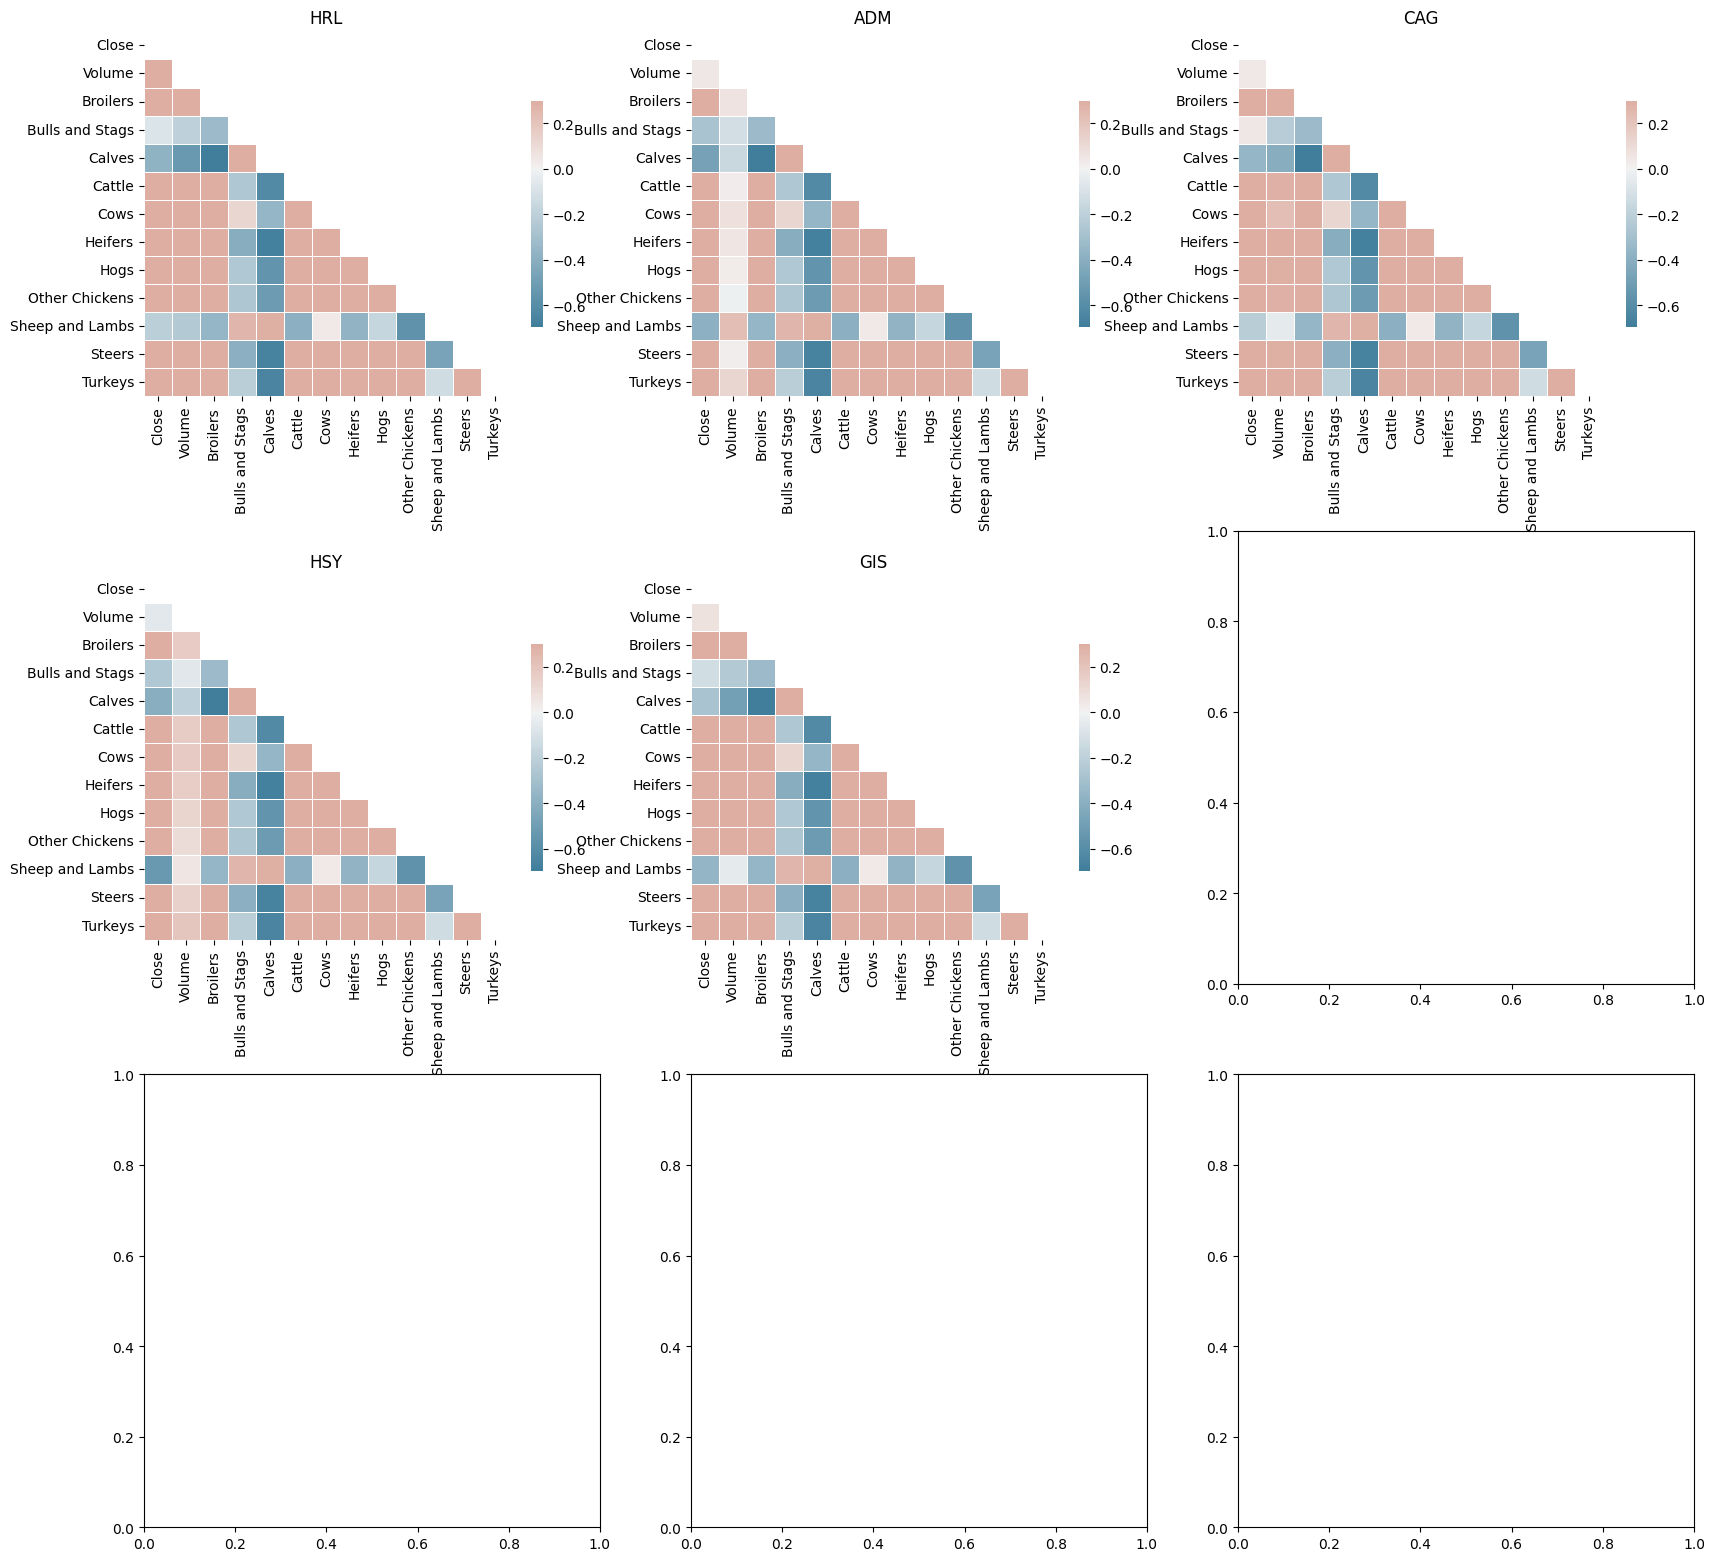

In [ ]:
# Plot for Processed Food Companies
plot_corr([HRL, ADM, CAG, HSY, GIS], ['Close', 'Volume', 'Broilers', 'Bulls and Stags', 'Calves', 'Cattle', 'Cows', 'Heifers', 'Hogs', 'Other Chickens', 'Sheep and Lambs', 'Steers', 'Turkeys'], False)

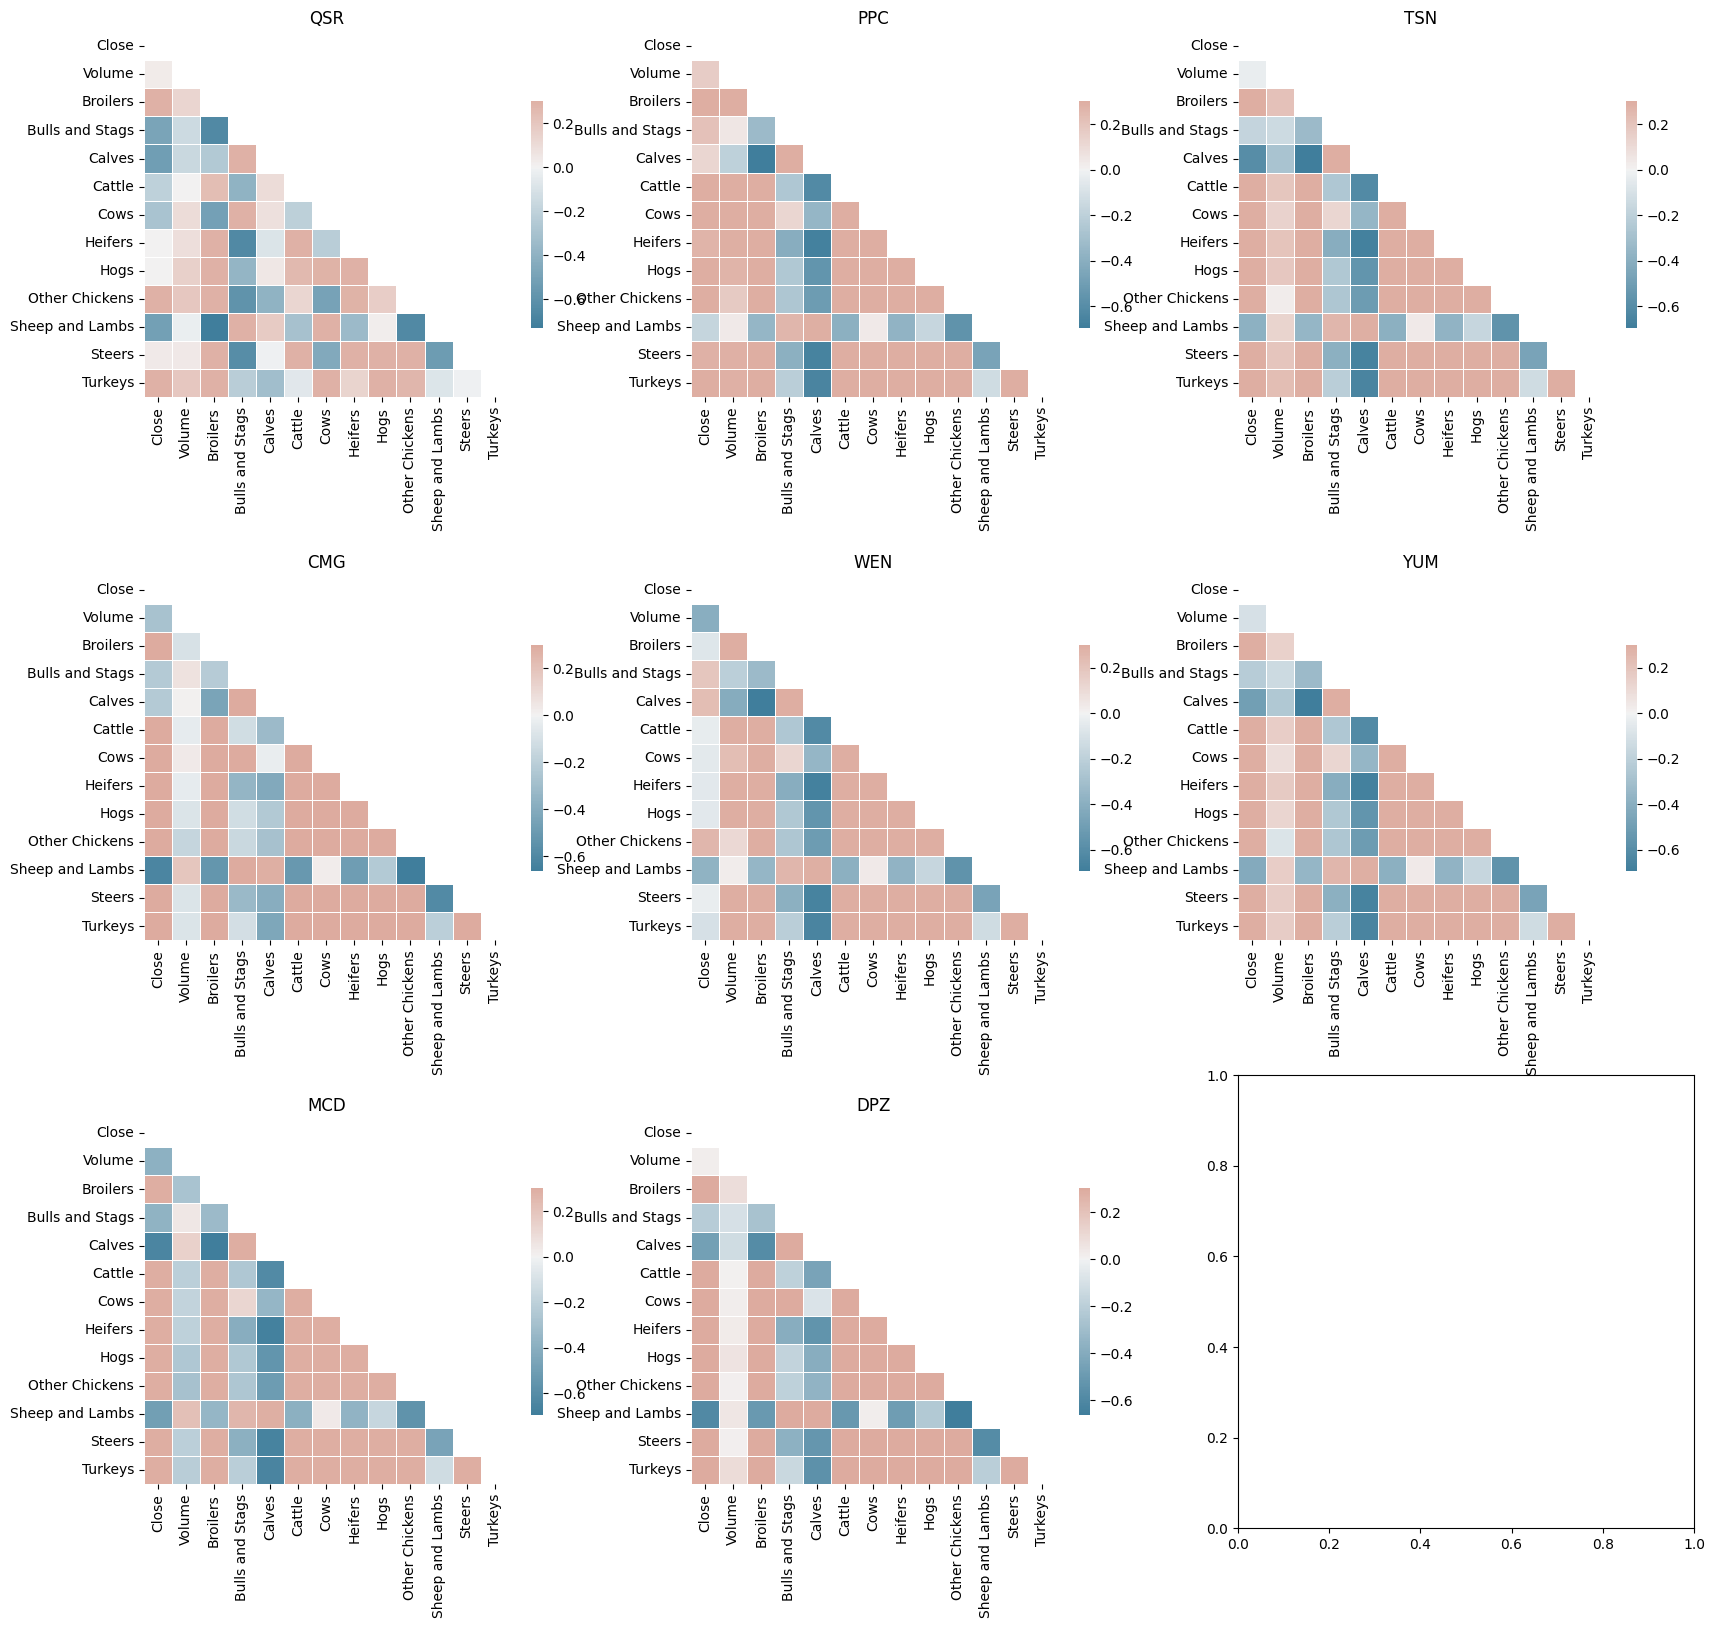

In [ ]:
# Plot for Processed Food Companies
plot_corr([QSR, PPC, TSN, CMG, WEN, YUM, MCD, DPZ], ['Close', 'Volume', 'Broilers', 'Bulls and Stags', 'Calves', 'Cattle', 'Cows', 'Heifers', 'Hogs', 'Other Chickens', 'Sheep and Lambs', 'Steers', 'Turkeys'], False)

### Why are slaughter weights correlated in the opposite direction to stocks compared to slaughter count
- I realised i'm stoopid - slaughter weights refer to the average weight, not overall weight, thr is no reason for them to be correlated

In [ ]:
# First, create a dataframe that contains all the meats from both dataframes
cows_count = slaughter_count[(slaughter_count['Animal'] == "Dairy Cows") | (slaughter_count['Animal'] == "Beef Cows")].drop("Date", axis=1).groupby("Date").sum()
cows_count['Date'] = cows_count.index
cows_count['Type_Of_Meat'] = 'Red Meat'
cows_count['Unit'] = '1,000 Head'
cows_count['Commercial_Or_Federally_Inspected'] = 'Mix'
cows_count['Animal'] = 'Cows'

slaughter_count = pd.concat([slaughter_count, cows_count], axis=0)

In [ ]:
slaughter_weights

Date  Year  Month                      Unit           Animal  \
Date                                                                           
2023-12-01  Dec-2023  2023     12  Average Weight in Pounds           Cattle   
2023-11-01  Nov-2023  2023     11  Average Weight in Pounds           Cattle   
2023-10-01  Oct-2023  2023     10  Average Weight in Pounds           Cattle   
2023-09-01  Sep-2023  2023      9  Average Weight in Pounds           Cattle   
2023-08-01  Aug-2023  2023      8  Average Weight in Pounds           Cattle   
...              ...   ...    ...                       ...              ...   
1983-05-01  May-1983  1983      5  Average Weight in Pounds  Sheep and Lambs   
1983-04-01  Apr-1983  1983      4  Average Weight in Pounds  Sheep and Lambs   
1983-03-01  Mar-1983  1983      3  Average Weight in Pounds  Sheep and Lambs   
1983-02-01  Feb-1983  1983      2  Average Weight in Pounds  Sheep and Lambs   
1983-01-01  Jan-1983  1983      1  Average Weight in Pounds  Sheep and Lambs   

            Weight Commercial_Or_Federally_Inspected Live_Or_Dressed  \
Date                                                                   
2023-12-01  1401.0                        Commercial            Live   
2023-11-01  1387.0                        Commercial            Live   
2023-10-01  1374.0                        Commercial            Live   
2023-09-01  1362.0                        Commercial            Live   
2023-08-01  1350.0                        Commercial            Live   
...            ...                               ...             ...   
1983-05-01    57.0               Federally Inspected         Dressed   
1983-04-01    58.0               Federally Inspected         Dressed   
1983-03-01    58.0               Federally Inspected         Dressed   
1983-02-01    58.0               Federally Inspected         Dressed   
1983-01-01    57.0               Federally Inspected         Dressed   

           Type_Of_Meat  
Date                     
2023-12-01     Red Meat  
2023-11-01     Red Meat  
2023-10-01     Red Meat  
2023-09-01     Red Meat  
2023-08-01     Red Meat  
...                 ...  
1983-05-01     Red Meat  
1983-04-01     Red Meat  
1983-03-01     Red Meat  
1983-02-01     Red Meat  
1983-01-01     Red Meat  

[9348 rows x 9 columns]

In [ ]:
slaughter_count = pd.concat([slaughter_count, cows_count], axis=0)
slaughter_weight_and_count = (
    slaughter_count
      .drop('Date', axis=1)
      .groupby(['Animal', 'Date'])['Count']
      .sum()
      .reset_index(level="Animal")
      .merge(
        slaughter_weights[slaughter_weights['Live_Or_Dressed'] == 'Dressed']
          .drop('Date',axis=1),
        on = ["Date", "Animal"]
      )
)
slaughter_weight_and_count.head()

slaughter_weight_and_count[['Count', 'Weight']]
# slaughter_weights[(slaughter_weights['Animal'] == 'Cattle') & (slaughter_weights.index == '2021-03-01')]

# slaughter_weight_and_count

Count  Weight
Date                      
1983-01-01   121.4   754.0
1983-02-01   110.9   758.0
1983-03-01   133.5   764.0
1983-04-01   125.3   759.0
1983-05-01   137.2   763.0
...            ...     ...
2023-08-01  2741.8   903.0
2023-09-01  2436.9   918.0
2023-10-01  2575.0   926.0
2023-11-01  2440.4   935.0
2023-12-01  2416.5   941.0

[3936 rows x 2 columns]

In [ ]:
slaughter_weights[::-1]['Animal'].unique()

array(['Sheep and Lambs', 'Hogs', 'Calves', 'Bulls and Stags', 'Cows',
       'Heifers', 'Steers', 'Cattle', 'Turkeys', 'Other Chickens',
       'Broilers'], dtype=object)

## Meat Production, Cold storage preprocessing before model

- Production V Cold Stor
  - Beef is relatively uncorrelated - no need to combine
  - Pork is relatively uncorrelated - no need to combine
  - Broilers no need (no data for cold stor)

- Pedict production per pop + pop over time
  - Pedict cold storage per pop + pop over time

- Do xgboost model based on pseudo-DD per pop + population + commodities (corn + sugar) + maybe obesity levels

In [ ]:
economics = pd.read_csv('/content/acs_5yr_est_selected_economic_characteristics_2010-2022.csv')
economics

Label (Grouping)  \
0                            EMPLOYMENT STATUS   
1                 Population 16 years and over   
2                               In labor force   
3                         Civilian labor force   
4                                     Employed   
...                                        ...   
98015                        18 years and over   
98016                           18 to 64 years   
98017                        65 years and over   
98018                       People in families   
98019  Unrelated individuals 15 years and over   

                                                Category        State  \
0                                                 Header      Alabama   
1                                      EMPLOYMENT STATUS      Alabama   
2                                      EMPLOYMENT STATUS      Alabama   
3                                      EMPLOYMENT STATUS      Alabama   
4                                      EMPLOYMENT STATUS      Alabama   
...                                                  ...          ...   
98015  PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...  Puerto Rico   
98016  PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...  Puerto Rico   
98017  PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...  Puerto Rico   
98018  PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...  Puerto Rico   
98019  PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...  Puerto Rico   

        Estimate Margin of Error    Percent Percent Margin of Error  Year  
0            NaN             NaN        NaN                     NaN  2010  
1      3,714,504          ±1,588  3,714,504                     (X)  2010  
2      2,246,848          ±5,576      60.5%                    ±0.1  2010  
3      2,230,879          ±5,531      60.1%                    ±0.1  2010  
4      2,036,867          ±5,904      54.8%                    ±0.2  2010  
...          ...             ...        ...                     ...   ...  
98015        (X)             (X)      39.7%                    ±0.4  2021  
98016        (X)             (X)      40.1%                    ±0.4  2021  
98017        (X)             (X)      38.5%                    ±0.5  2021  
98018        (X)             (X)      40.0%                    ±0.4  2021  
98019        (X)             (X)      55.3%                    ±0.4  2021  

[98020 rows x 8 columns]

In [ ]:
population = economics[economics['Label (Grouping)'] == 'Population 16 years and over'].groupby('Year')['Estimate'].apply(lambda x: x.apply(lambda y: y.replace(',', '')).astype(float).sum())

population.index = pd.to_datetime(population.index, format='%Y')
population = population.resample('BMS').ffill()
population.index.name = 'Date'
population.name = 'Population'
population

Date
2010-01-01    241665484.0
2010-02-01    241665484.0
2010-03-01    241665484.0
2010-04-01    241665484.0
2010-05-03    241665484.0
                 ...     
2021-08-02    266885578.0
2021-09-01    266885578.0
2021-10-01    266885578.0
2021-11-01    266885578.0
2021-12-01    266885578.0
Freq: BMS, Name: Population, Length: 144, dtype: float64

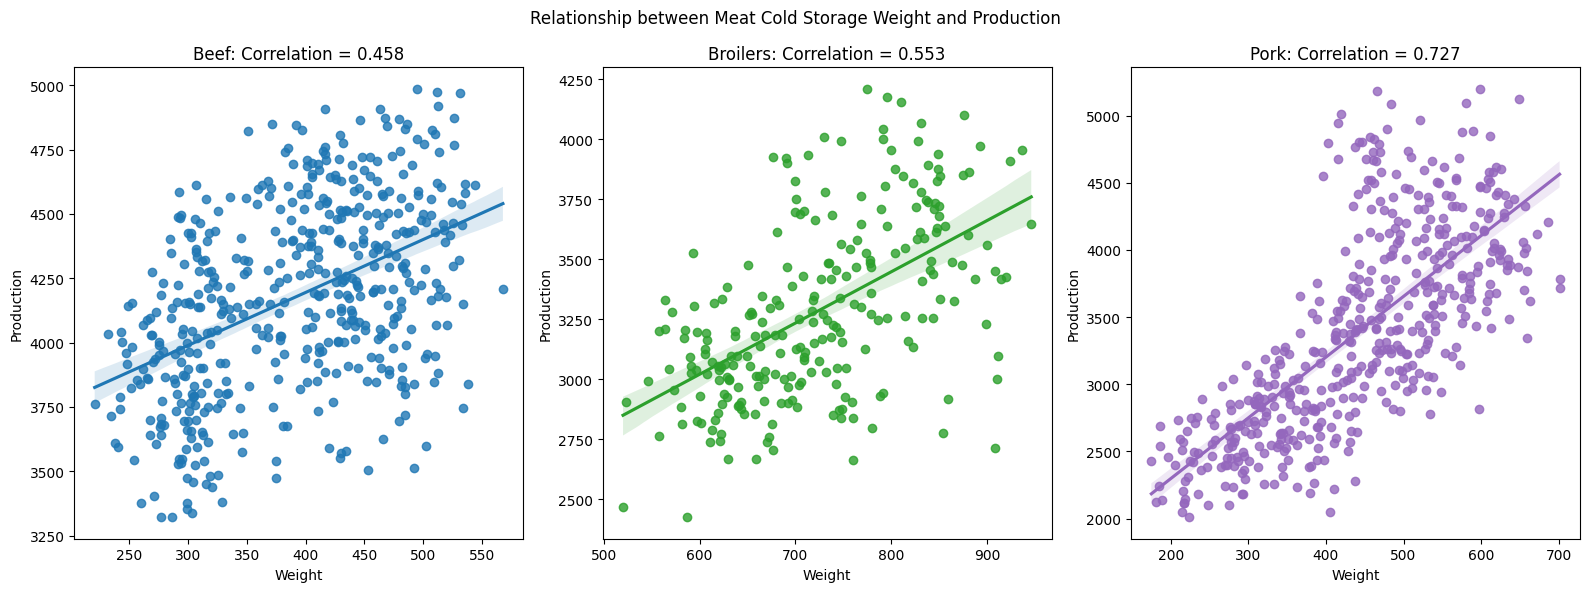

In [30]:
# print(cold_stor.drop('Date', axis=1).merge(meat_prod.drop('Date', axis=1).groupby(['Date', 'Animal'])['Production'].sum(), on=['Animal', 'Date']).groupby('Animal')[['Weight', 'Production']].corr())
# cold_stor.drop('Date', axis=1).merge(meat_prod.drop('Date', axis=1).groupby(['Date', 'Animal'])['Production'].sum(), on=['Animal', 'Date']).groupby('Animal').plot.scatter(x='Weight', y='Production')

prod_and_weight = cold_stor.drop('Date', axis=1).merge(meat_prod.drop('Date', axis=1).groupby(['Date', 'Animal'])['Production'].sum(), on=['Animal', 'Date']).groupby('Animal')
# animals = ["Beef", "Broilers", "Lamb and Mutton", "Other Chicken", "Pork", "Turkey", "Veal"]
animals = ["Beef", "Broilers", "Pork"]
tab_20_colors = ["#1f77b4", "#2ca02c", "#9467bd", "#e377c2", "#bcbd22", "#9edae5"]

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle("Relationship between Meat Cold Storage Weight and Production")

for i, ax in enumerate(fig.axes):
  animal = animals[i]
  df = prod_and_weight.get_group(animal)
  corr = df["Weight"].corr(df["Production"])

  ax.set_title(f"{animal}: Correlation = {corr:.3f}")
  sns.regplot(df, x="Weight", y="Production", ax=ax, color=tab_20_colors[i])

plt.tight_layout()

In [87]:
# cold_stor = cold_stor[::-1]
weight_diff = cold_stor.groupby('Animal')['Weight'].rolling(window=9).apply(lambda x: x.iloc[-1] - (x.iloc[-2] - x.iloc[:-1].mean()))
weight_diff.name = 'weight_diff'
cold_stor = cold_stor.drop('Date', axis = 1).merge(weight_diff, on = ['Animal', 'Date'])
cold_stor

Year  Month            Unit       Animal  Weight Type_Of_Meat  \
Date                                                                        
2023-12-01  2023     12  Million Pounds         Beef  457.41     Red Meat   
2023-11-01  2023     11  Million Pounds         Beef  445.67     Red Meat   
2023-10-01  2023     10  Million Pounds         Beef  420.85     Red Meat   
2023-09-01  2023      9  Million Pounds         Beef  395.40     Red Meat   
2023-08-01  2023      8  Million Pounds         Beef  410.46     Red Meat   
...          ...    ...             ...          ...     ...          ...   
1990-06-01  1990      6  Million Pounds  Frozen Eggs   17.39      Poultry   
1990-05-01  1990      5  Million Pounds  Frozen Eggs   17.29      Poultry   
1990-04-01  1990      4  Million Pounds  Frozen Eggs   16.78      Poultry   
1990-03-01  1990      3  Million Pounds  Frozen Eggs   15.18      Poultry   
1990-02-01  1990      2  Million Pounds  Frozen Eggs   14.17      Poultry   

            weight_diff  
Date                     
2023-12-01          NaN  
2023-11-01          NaN  
2023-10-01          NaN  
2023-09-01          NaN  
2023-08-01          NaN  
...                 ...  
1990-06-01     15.86875  
1990-05-01     16.76625  
1990-04-01     16.67375  
1990-03-01     15.53625  
1990-02-01     15.92500  

[3606 rows x 7 columns]

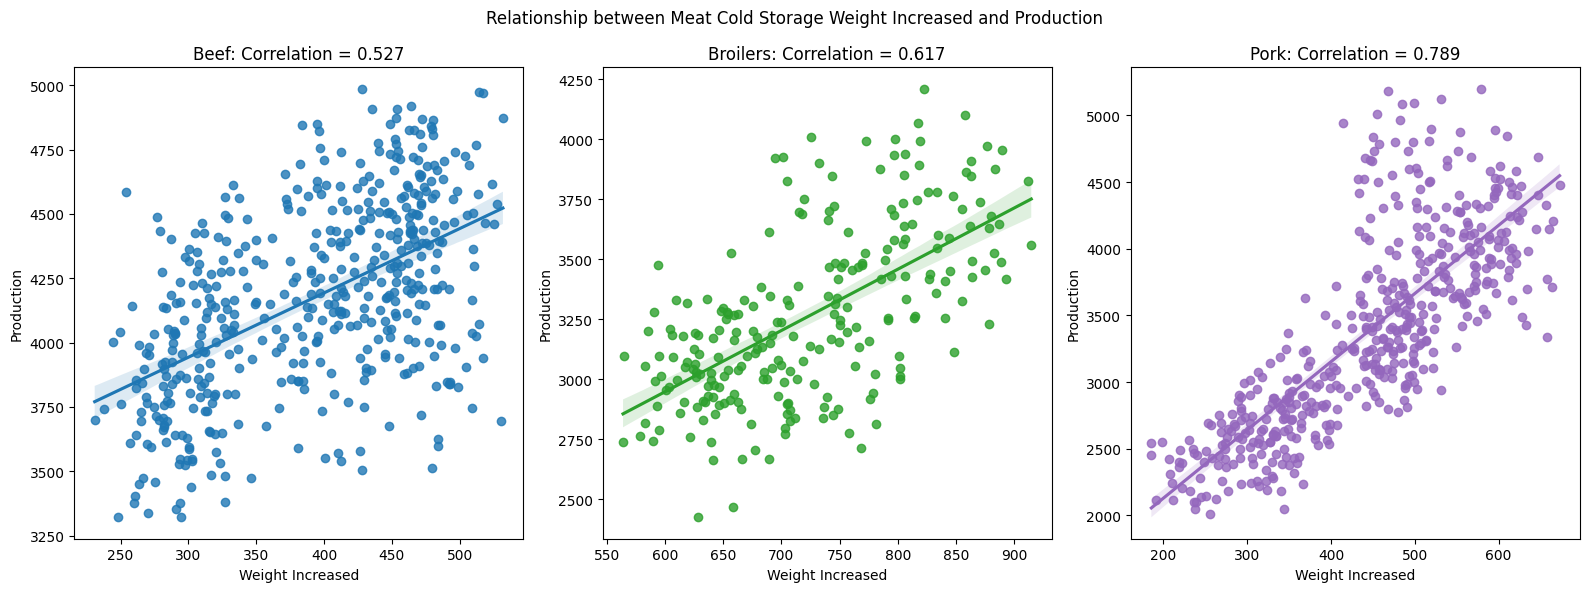

In [236]:
# print(cold_stor.merge(meat_prod.drop('Date', axis=1).groupby(['Date', 'Animal'])['Production'].sum(), on=['Animal', 'Date']).groupby('Animal')[['weight_diff', 'Production']].corr())
# cold_stor.merge(meat_prod.drop('Date', axis=1).groupby(['Date', 'Animal'])['Production'].sum(), on=['Animal', 'Date']).groupby('Animal').plot.scatter(x='weight_diff', y='Production')

prod_and_weight = cold_stor.merge(meat_prod.drop('Date', axis=1).groupby(['Date', 'Animal'])['Production'].sum(), on=['Animal', 'Date']).groupby('Animal')
# animals = ["Beef", "Broilers", "Lamb and Mutton", "Other Chicken", "Pork", "Turkey", "Veal"]
animals = ["Beef", "Broilers", "Pork"]
tab_20_colors = ["#1f77b4", "#2ca02c", "#9467bd", "#e377c2", "#bcbd22", "#9edae5"]

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle("Relationship between Meat Cold Storage Weight Increased and Production")

for i, ax in enumerate(fig.axes):
  animal = animals[i]
  df = prod_and_weight.get_group(animal)
  corr = df["weight_diff"].corr(df["Production"])

  ax.set_title(f"{animal}: Correlation = {corr:.3f}")
  sns.regplot(df, x="weight_diff", y="Production", ax=ax, color=tab_20_colors[i])
  ax.set_xlabel("Weight Increased")

plt.tight_layout()

In [203]:
population = pd.read_csv('/content/export.csv', parse_dates=["label"], index_col="label")
population.index.names = ["Date"]
population.columns = ["Population"]

population.loc[pd.to_datetime("2024")] = [1] # Workaround to resample the whole of the last year
population = population.resample('MS').ffill()
population = population.drop(population.index[-1]) # Delete that workaround
population

Population
Date                  
1900-01-01    76094000
1900-02-01    76094000
1900-03-01    76094000
1900-04-01    76094000
1900-05-01    76094000
...                ...
2023-08-01   333287557
2023-09-01   333287557
2023-10-01   333287557
2023-11-01   333287557
2023-12-01   333287557

[1488 rows x 1 columns]

In [211]:
# Units now in pounds instead of million pounds + Lost data along the way because of population dataset
pseudo_demand = cold_stor.merge(meat_prod.drop('Date', axis=1).groupby(['Date', 'Animal'])['Production'].sum(), on=['Animal', 'Date'])
pseudo_demand['demand'] = pseudo_demand['Production'] - pseudo_demand['weight_diff']
pseudo_demand = pseudo_demand.merge(population, on="Date")
pseudo_demand['demand_per_pax'] = (pseudo_demand['demand'] / pseudo_demand['Population']) * 1000000
pseudo_demand['demand'] = pseudo_demand['demand'].fillna(method="bfill")
pseudo_demand['demand_per_pax'] = pseudo_demand['demand_per_pax'].fillna(method="bfill")
pseudo_demand

Year  Month            Unit           Animal  Weight Type_Of_Meat  \
Date                                                                            
2023-12-01  2023     12  Million Pounds             Beef  457.41     Red Meat   
2023-12-01  2023     12  Million Pounds             Veal    0.89     Red Meat   
2023-12-01  2023     12  Million Pounds             Pork  415.66     Red Meat   
2023-12-01  2023     12  Million Pounds  Lamb and Mutton   22.43     Red Meat   
2023-12-01  2023     12  Million Pounds         Broilers  847.10      Poultry   
...          ...    ...             ...              ...     ...          ...   
1983-01-01  1983      1  Million Pounds             Beef  294.38     Red Meat   
1983-01-01  1983      1  Million Pounds             Veal    7.36     Red Meat   
1983-01-01  1983      1  Million Pounds             Pork  219.02     Red Meat   
1983-01-01  1983      1  Million Pounds  Lamb and Mutton    8.65     Red Meat   
1983-01-01  1983      1  Million Pounds           Turkey  203.91      Poultry   

            weight_diff  Production      demand  Population  demand_per_pax  
Date                                                                         
2023-12-01          NaN      4348.7  3651.18625   333287557       10.955063  
2023-12-01          NaN         7.6  3651.18625   333287557       10.955063  
2023-12-01          NaN      4674.4  3651.18625   333287557       10.955063  
2023-12-01          NaN        20.2  3651.18625   333287557       10.955063  
2023-12-01          NaN      3615.0  3651.18625   333287557       10.955063  
...                 ...         ...         ...         ...             ...  
1983-01-01    269.35125      3765.0  3495.64875   233792014       14.951960  
1983-01-01      7.21125        62.0    54.78875   233792014        0.234348  
1983-01-01    243.36250      2278.0  2034.63750   233792014        8.702767  
1983-01-01      9.21625        59.0    49.78375   233792014        0.212940  
1983-01-01    251.71500       192.7   -59.01500   233792014       -0.252425  

[2983 rows x 11 columns]

In [187]:
# Units now in pounds instead of million pounds
pseudo_demand[pseudo_demand['Animal']=='Beef']

Year  Month            Unit Animal  Weight Type_Of_Meat  \
Date                                                                  
2023-12-01  2023     12  Million Pounds   Beef  457.41     Red Meat   
2023-11-01  2023     11  Million Pounds   Beef  445.67     Red Meat   
2023-10-01  2023     10  Million Pounds   Beef  420.85     Red Meat   
2023-09-01  2023      9  Million Pounds   Beef  395.40     Red Meat   
2023-08-01  2023      8  Million Pounds   Beef  410.46     Red Meat   
...          ...    ...             ...    ...     ...          ...   
1983-05-01  1983      5  Million Pounds   Beef  277.33     Red Meat   
1983-04-01  1983      4  Million Pounds   Beef  299.08     Red Meat   
1983-03-01  1983      3  Million Pounds   Beef  307.05     Red Meat   
1983-02-01  1983      2  Million Pounds   Beef  303.21     Red Meat   
1983-01-01  1983      1  Million Pounds   Beef  294.38     Red Meat   

            weight_diff  Production      demand  Population  demand_per_pax  
Date                                                                         
2023-12-01          NaN      4348.7         NaN   333287557             NaN  
2023-11-01          NaN      4528.2         NaN   333287557             NaN  
2023-10-01          NaN      4641.7         NaN   333287557             NaN  
2023-09-01          NaN      4264.0         NaN   333287557             NaN  
2023-08-01          NaN      4693.0         NaN   333287557             NaN  
...                 ...         ...         ...         ...             ...  
1983-05-01    290.42125      3642.0  3351.57875   233792014       14.335728  
1983-04-01    294.03875      3377.0  3082.96125   233792014       13.186769  
1983-03-01    278.14125      3700.0  3421.85875   233792014       14.636337  
1983-02-01    269.96625      3339.0  3069.03375   233792014       13.127197  
1983-01-01    269.35125      3765.0  3495.64875   233792014       14.951960  

[492 rows x 11 columns]

## Slaughter Count and Weights (Local Production Levels)

In [ ]:
# First, create a dataframe that contains all the meats from both dataframes
cows_count = slaughter_count[
    (slaughter_count['Animal'] == "Dairy Cows") |
    (slaughter_count['Animal'] == "Beef Cows")
    ].drop("Date", axis=1).groupby("Date").sum()
cows_count['Date'] = cows_count.index
cows_count['Type_Of_Meat'] = 'Red Meat'
cows_count['Unit'] = '1,000 Head'
cows_count['Commercial_Or_Federally_Inspected'] = 'Mix'
cows_count['Animal'] = 'Cows'

slaughter_count = pd.concat([slaughter_count, cows_count], axis=0)

slaughter_weight_and_count = (
    slaughter_count
      .drop('Date', axis=1)
      .groupby(['Animal', 'Date'])['Count']
      .sum()
      .reset_index(level="Animal")
      .merge(
        slaughter_weights
        #  [slaughter_weights['Live_Or_Dressed'] == 'Dressed']
          .drop('Date',axis=1),
        on = ["Date", "Animal"]
      )
)
slaughter_weight_and_count.head()

Animal     Count  Year  Month                      Unit  Weight  \
Date                                                                            
1983-01-01  Broilers  340252.0  1983      1  Average Weight in Pounds     4.1   
1983-02-01  Broilers  313680.0  1983      2  Average Weight in Pounds     4.1   
1983-03-01  Broilers  368250.0  1983      3  Average Weight in Pounds     4.1   
1983-04-01  Broilers  345740.0  1983      4  Average Weight in Pounds     4.2   
1983-05-01  Broilers  364275.0  1983      5  Average Weight in Pounds     4.1   

           Commercial_Or_Federally_Inspected Live_Or_Dressed Type_Of_Meat  
Date                                                                       
1983-01-01               Federally Inspected            Live      Poultry  
1983-02-01               Federally Inspected            Live      Poultry  
1983-03-01               Federally Inspected            Live      Poultry  
1983-04-01               Federally Inspected            Live      Poultry  
1983-05-01               Federally Inspected            Live      Poultry

In [ ]:
slaughter_weight_and_count['Total Weight'] = slaughter_weight_and_count['Weight'] * slaughter_weight_and_count['Count']

In [ ]:
# For Beef
dressed = slaughter_weight_and_count[slaughter_weight_and_count['Live_Or_Dressed'] == 'Dressed']
beef = dressed[
    (dressed['Animal'] == 'Bulls and Stags') |
    (dressed['Animal'] == 'Cattle') |
    (dressed['Animal'] == 'Cows') |
    (dressed['Animal'] == 'Heifers') |
    (dressed['Animal'] == 'Steers')
    ]
beef = beef.groupby('Date')['Total Weight'].sum() * 1000 / 1000000
beef.name = 'Local Production'
beef

Date
1983-01-01    7590.6732
1983-02-01    6728.5050
1983-03-01    7456.4280
1983-04-01    6804.6301
1983-05-01    7334.1709
                ...    
2023-08-01    9416.6193
2023-09-01    8560.2686
2023-10-01    9318.3688
2023-11-01    9088.0301
2023-12-01    8727.5556
Name: Local Production, Length: 492, dtype: float64

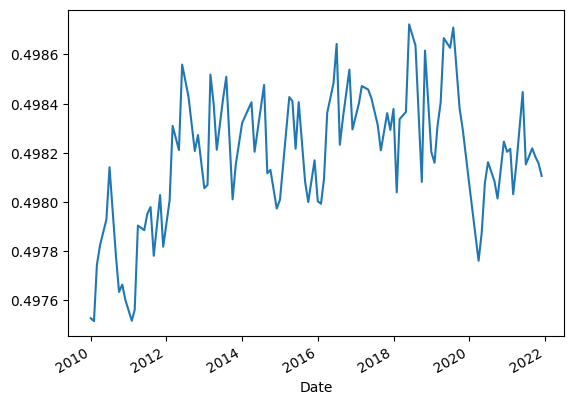

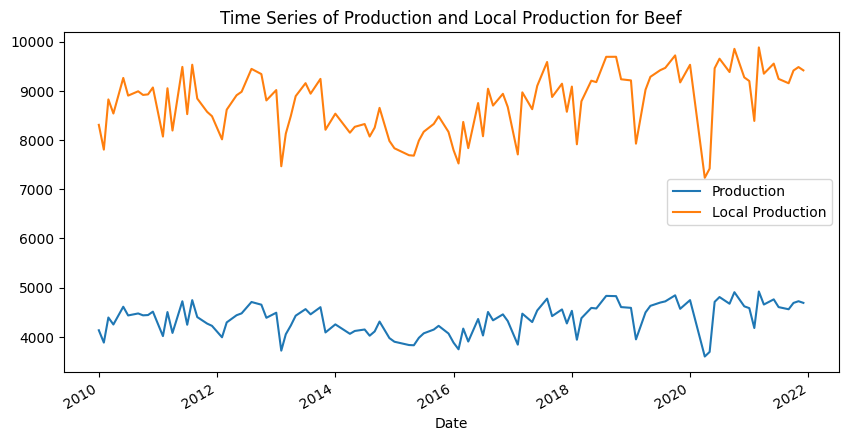

In [ ]:
beef = pseudo_demand[pseudo_demand['Animal'] == 'Beef'].merge(beef, on='Date')
beef['Yield'] = beef['Production'] / beef['Local Production']
beef['Yield'].plot()

# Plot all animal in the same figure
fig, ax = plt.subplots(figsize=(10, 5))

for x in ['Production', 'Local Production']:
    beef[x].plot(ax=ax, label=x)

ax.set_title('Time Series of Production and Local Production for Beef')
ax.legend()
plt.show()

In [ ]:
# For Broilers
broilers = slaughter_weight_and_count[
    (slaughter_weight_and_count['Animal'] == 'Broilers')
    ]
broilers = broilers.groupby('Date')['Total Weight'].sum() * 1000 / 1000000
broilers.name = 'Local Production'
broilers

Date
1983-01-01    1395.0332
1983-02-01    1286.0880
1983-03-01    1509.8250
1983-04-01    1452.1080
1983-05-01    1493.5275
                ...    
2023-08-01    5533.0665
2023-09-01    5022.9630
2023-10-01    5524.8803
2023-11-01    5027.8866
2023-12-01    4776.3474
Name: Local Production, Length: 492, dtype: float64

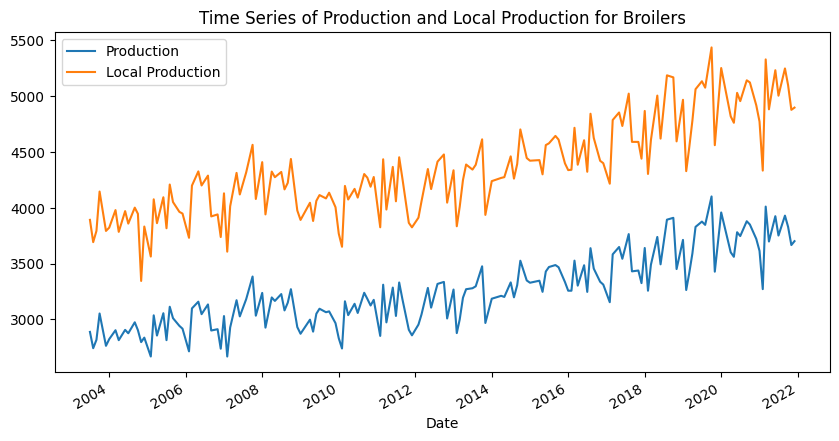

In [ ]:
# broilers = pseudo_demand[pseudo_demand['Animal'] == 'Broilers'].merge(broilers, on='Date')

# Plot all animal in the same figure
fig, ax = plt.subplots(figsize=(10, 5))

for x in ['Production', 'Local Production']:
    broilers[x].plot(ax=ax, label=x)

ax.set_title('Time Series of Production and Local Production for Broilers')
ax.legend()
plt.show()

In [ ]:
# For Pork
dressed = slaughter_weight_and_count[slaughter_weight_and_count['Live_Or_Dressed'] == 'Dressed']
pork = dressed[
    (dressed['Animal'] == 'Hogs')
    ]
pork = pork.groupby('Date')['Total Weight'].sum() * 1000 / 1000000
pork.name = 'Local Production'
pork

Date
1983-01-01    2289.9275
1983-02-01    2017.0268
1983-03-01    2583.5128
1983-04-01    2502.7638
1983-05-01    2468.0832
                ...    
2023-08-01    4569.0800
2023-09-01    4371.7157
2023-10-01    4832.9640
2023-11-01    4777.6225
2023-12-01    4687.4821
Name: Local Production, Length: 492, dtype: float64

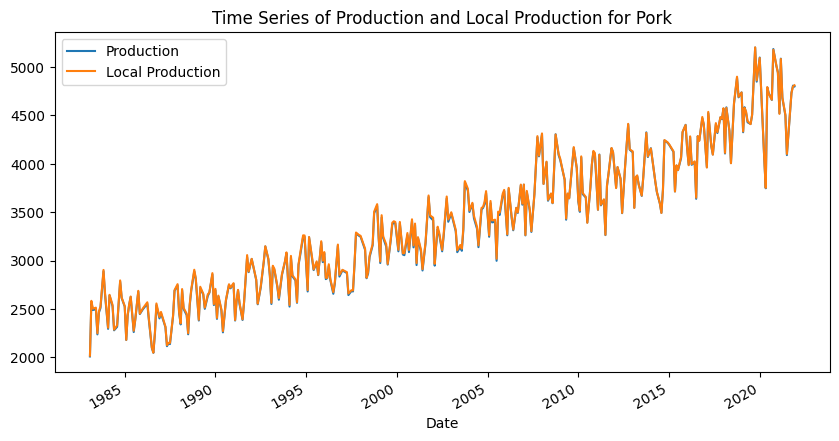

In [ ]:
pork = pseudo_demand[pseudo_demand['Animal'] == 'Pork'].merge(pork, on='Date')

# Plot all animal in the same figure
fig, ax = plt.subplots(figsize=(10, 5))

for x in ['Production', 'Local Production']:
    pork[x].plot(ax=ax, label=x)

ax.set_title('Time Series of Production and Local Production for Pork')
ax.legend()
plt.show()

In [ ]:
slaughter_weight_and_count['Animal'].unique()

Animal   Count  Year  Month                      Unit  \
Date                                                                         
1983-01-01  Bulls and Stags   121.4  1983      1  Average Weight in Pounds   
1983-02-01  Bulls and Stags   110.9  1983      2  Average Weight in Pounds   
1983-03-01  Bulls and Stags   133.5  1983      3  Average Weight in Pounds   
1983-04-01  Bulls and Stags   125.3  1983      4  Average Weight in Pounds   
1983-05-01  Bulls and Stags   137.2  1983      5  Average Weight in Pounds   
...                     ...     ...   ...    ...                       ...   
2023-08-01           Steers  2741.8  2023      8  Average Weight in Pounds   
2023-09-01           Steers  2436.9  2023      9  Average Weight in Pounds   
2023-10-01           Steers  2575.0  2023     10  Average Weight in Pounds   
2023-11-01           Steers  2440.4  2023     11  Average Weight in Pounds   
2023-12-01           Steers  2416.5  2023     12  Average Weight in Pounds   

            Weight Commercial_Or_Federally_Inspected Live_Or_Dressed  \
Date                                                                   
1983-01-01   754.0               Federally Inspected         Dressed   
1983-02-01   758.0               Federally Inspected         Dressed   
1983-03-01   764.0               Federally Inspected         Dressed   
1983-04-01   759.0               Federally Inspected         Dressed   
1983-05-01   763.0               Federally Inspected         Dressed   
...            ...                               ...             ...   
2023-08-01   903.0               Federally Inspected         Dressed   
2023-09-01   918.0               Federally Inspected         Dressed   
2023-10-01   926.0               Federally Inspected         Dressed   
2023-11-01   935.0               Federally Inspected         Dressed   
2023-12-01   941.0               Federally Inspected         Dressed   

           Type_Of_Meat  
Date                     
1983-01-01     Red Meat  
1983-02-01     Red Meat  
1983-03-01     Red Meat  
1983-04-01     Red Meat  
1983-05-01     Red Meat  
...                 ...  
2023-08-01     Red Meat  
2023-09-01     Red Meat  
2023-10-01     Red Meat  
2023-11-01     Red Meat  
2023-12-01     Red Meat  

[2460 rows x 9 columns]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pmdarima.arima import auto_arima
import itertools

def trainTestSplit(dataset, months=12):
    # hold out latest months units as test set
    latest_date = dataset.index.to_timestamp().max()
    months_ago = latest_date - pd.DateOffset(months=months)

    # train-test split
    train_data = dataset[dataset.index.to_timestamp() < months_ago]
    test_data = dataset[dataset.index.to_timestamp() >= months_ago]

    return train_data, test_data

# def getBestParams(traindata, Prange, Drange, Qrange, value_name='Weight'):
#     # p, d, q = range(0, Prange), range(0, Drange), range(0, Qrange)
#     # best_aic = float("inf")
#     best_params = None

#     # Generate all possible combinations of p, d, and q values
#     # for param in itertools.product(p, d, q):
#     params = auto_arima(pd.to_numeric(traindata[value_name]), max_p=Prange, max_q=Qrange, max_d=Drange, order=param)
#         # results = model.fit()
#         # if results.aic < best_aic:
#         #     best_aic = results.aic
#         #     best_params = param

#     # return f"Best ARIMA parameters: {best_params} AIC:{best_aic}"
#     return params

def trainSARIMAXModel(dataset, train_data, test_data, p, d, q, P, D, Q, m, animal_name, months=12, confidence_interval=0.95, nsteps=1, residualPlot=True, value_name='weight_per_pax'):
    traindata = train_data.copy()
    y_pred = []
    conf_ints = []
    latest_date = dataset.index.to_timestamp().max()

    # predictions
    for i in range(1, len(test_data) + 1):
        model = SARIMAX(pd.to_numeric(traindata[value_name]), order=(p, d, q), seasonal_order=(p, d, q, m))
        arima_model = model.fit()
        forecast = arima_model.get_forecast(steps=nsteps)
        y_pred.append(forecast.predicted_mean.iloc[0])
        conf_int = forecast.conf_int(alpha=1 - confidence_interval)
        conf_ints.append(conf_int.iloc[0])

        offsetMonths = latest_date - pd.DateOffset(months=months - i)
        traindata = dataset[dataset.index.to_timestamp() < offsetMonths]

    # record down the residuals
    residuals = pd.DataFrame(arima_model.resid)

    # Convert confidence intervals to DataFrame
    conf_ints_df = pd.DataFrame(conf_ints)

    # Save the predictions for the product
    product_predictions = pd.DataFrame({
        'Product': [animal_name] * len(test_data),
        'Time': test_data.index.values,
        'Actual Price': test_data[value_name].values,
        'Predicted Price': y_pred
    })

    # plotting train, test, predicted values and confidence intervals
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index.to_timestamp(), train_data[value_name], label='Training', color='blue')
    plt.plot(test_data.index.to_timestamp(), test_data[value_name], label='Test', color='green')
    plt.plot(test_data.index.to_timestamp(), y_pred, label='Predicted', linestyle='--', color='red')

    # Plotting confidence intervals
    plt.fill_between(test_data.index.to_timestamp(), conf_ints_df.iloc[:, 0], conf_ints_df.iloc[:, 1], color='pink', alpha=0.3)

    plt.title(f'ARIMA Predictions with Confidence Intervals for {animal_name}')
    plt.xlabel('Date')
    plt.ylabel('Demand Per Pax')
    plt.legend()
    plt.show()

    # Zoomed-in plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index.to_timestamp(), test_data[value_name], label='Test', color='green')
    plt.plot(test_data.index.to_timestamp(), y_pred, label='Predicted', linestyle='--', color='red')
    plt.fill_between(test_data.index.to_timestamp(), conf_ints_df.iloc[:, 0], conf_ints_df.iloc[:, 1], color='pink', alpha=0.3)

    # Focus on the test data period
    plt.xlim([test_data.index.to_timestamp().min(), test_data.index.max()])

    plt.title(f'Zoomed-in ARIMA Predictions for {animal_name}')
    plt.xlabel('Date')
    plt.ylabel('Demand Per Pax')
    plt.legend()
    plt.show()

    if residualPlot:
        # line plot of residuals
        residuals.plot()
        plt.title('Residuals over time for ARIMA predictions')
        plt.show()
        # density plot of residuals
        residuals.plot(kind='kde')
        plt.title('Distribution of Residuals for ARIMA predictions')
        plt.show()
        # summary stats of residuals
        print(residuals.describe())

    return product_predictions

In [ ]:
# meat_prod.index = meat_prod.index.to_period('M')
# meat_prod = meat_prod[::-1]
# meat_prod
pseudo_demand

Year  Month            Unit           Animal  Weight Type_Of_Meat  \
Date                                                                            
1983-02-01  1983      2  Million Pounds           Turkey  193.83      Poultry   
1983-02-01  1983      2  Million Pounds  Lamb and Mutton    7.68     Red Meat   
1983-02-01  1983      2  Million Pounds             Pork  224.15     Red Meat   
1983-02-01  1983      2  Million Pounds             Veal    7.26     Red Meat   
1983-02-01  1983      2  Million Pounds             Beef  303.21     Red Meat   
...          ...    ...             ...              ...     ...          ...   
2021-12-01  2021     12  Million Pounds         Broilers  709.40      Poultry   
2021-12-01  2021     12  Million Pounds  Lamb and Mutton   23.49     Red Meat   
2021-12-01  2021     12  Million Pounds             Pork  402.19     Red Meat   
2021-12-01  2021     12  Million Pounds             Veal    4.28     Red Meat   
2021-12-01  2021     12  Million Pounds             Beef  490.41     Red Meat   

            weight_diff  Production      demand  Population  demand_per_pax  
Date                                                                         
1983-02-01          NaN       144.1         NaN   233792014             NaN  
1983-02-01          NaN        53.0         NaN   233792014             NaN  
1983-02-01          NaN      2009.0         NaN   233792014             NaN  
1983-02-01          NaN        58.0         NaN   233792014             NaN  
1983-02-01          NaN      3339.0         NaN   233792014             NaN  
...                 ...         ...         ...         ...             ...  
2021-12-01    683.41875      3700.1  3016.68125   332031554        9.085526  
2021-12-01     19.99375        22.2     2.20625   332031554        0.006645  
2021-12-01    412.38000      4797.9  4385.52000   332031554       13.208142  
2021-12-01      5.89250        10.4     4.50750   332031554        0.013576  
2021-12-01    451.54500      4689.3  4237.75500   332031554       12.763109  

[2010 rows x 11 columns]

In [ ]:
# I got the best params from the function executed on my local computer cos i needed pmdarima
pork = pd.DataFrame(meat_prod[meat_prod['Animal'] == 'Pork'].drop('Date', axis=1).groupby('Date')['Production'].sum())
train, test = trainTestSplit(beef, months=12)
# params = getBestParams(train, 5, 10, 10, value_name='weight_per_pax')
trainSARIMAXModel(beef, train, test, 13, 1, 1, 'Pork', months=12, value_name='Production')

TypeError: trainSARIMAXModel() missing 4 required positional arguments: 'D', 'Q', 'm', and 'animal_name'

In [ ]:
beef = pseudo_demand[pseudo_demand['Animal'] == 'Beef']
beef

Year  Month            Unit Animal  Weight Type_Of_Meat  \
Date                                                                  
1983-02-01  1983      2  Million Pounds   Beef  303.21     Red Meat   
1983-03-01  1983      3  Million Pounds   Beef  307.05     Red Meat   
1983-04-01  1983      4  Million Pounds   Beef  299.08     Red Meat   
1983-06-01  1983      6  Million Pounds   Beef  265.16     Red Meat   
1983-07-01  1983      7  Million Pounds   Beef  253.96     Red Meat   
...          ...    ...             ...    ...     ...          ...   
2021-07-01  2021      7  Million Pounds   Beef  401.52     Red Meat   
2021-09-01  2021      9  Million Pounds   Beef  414.90     Red Meat   
2021-10-01  2021     10  Million Pounds   Beef  439.62     Red Meat   
2021-11-01  2021     11  Million Pounds   Beef  473.76     Red Meat   
2021-12-01  2021     12  Million Pounds   Beef  490.41     Red Meat   

            weight_diff  Production      demand  Population  demand_per_pax  
Date                                                                         
1983-02-01          NaN      3339.0         NaN   233792014             NaN  
1983-03-01          NaN      3700.0         NaN   233792014             NaN  
1983-04-01          NaN      3377.0         NaN   233792014             NaN  
1983-06-01          NaN      3862.0         NaN   233792014             NaN  
1983-07-01          NaN      3542.0         NaN   233792014             NaN  
...                 ...         ...         ...         ...             ...  
2021-07-01    475.83250      4603.2  4127.36750   332031554       12.430648  
2021-09-01    478.89250      4559.7  4080.80750   332031554       12.290421  
2021-10-01    474.42750      4688.4  4213.97250   332031554       12.691482  
2021-11-01    473.88125      4722.9  4249.01875   332031554       12.797033  
2021-12-01    451.54500      4689.3  4237.75500   332031554       12.763109  

[334 rows x 11 columns]

In [ ]:
# I got the best params from the function executed on my local computer cos i needed pmdarima
# beef = pd.DataFrame(meat_prod[meat_prod['Animal'] == 'Beef'].drop('Date', axis=1).groupby('Date')['Production'].sum())
broilers = pseudo_demand[pseudo_demand['Animal'] == 'Broilers']
broilers.index = broilers.index.to_period('M')

train, test = trainTestSplit(broilers, months=24)
# params = getBestParams(train, 5, 10, 10, value_name='weight_per_pax')
broilers_model = trainSARIMAXModel(broilers, train, test, 2, 1, 1, 0, 0, 0, 12, 'Broilers', months=12, value_name='demand_per_pax')

In [ ]:
broilers_model

In [ ]:
# I got the best params from the function executed on my local computer cos i needed pmdarima
pork = pd.DataFrame(meat_prod[meat_prod['Animal'] == 'Broilers'].drop('Date', axis=1).groupby('Date')['Production'].sum())
train, test = trainTestSplit(pork, months=12)
# params = getBestParams(train, 5, 10, 10, value_name='weight_per_pax')
trainARIMAModel(beef, train, test, 12, 1, 10, 'Broilers', months=12, value_name='Production')

In [ ]:
def acf_pacf(traindata):
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf

    # Plotting the ACF
    plt.figure(figsize=(10, 6))
    plot_acf(traindata.invoice_price, lags=20)  # Adjust 'lags' parameter as neede
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function (ACF)')
    plt.grid(True)
    plt.show()

    # Plotting the PACF
    plt.figure(figsize=(10, 6))
    plot_pacf(traindata.invoice_price, lags=20)  # Adjust 'lags' parameter as needed
    plt.xlabel('Lags')
    plt.ylabel('Partial Autocorrelation')
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.grid(True)
    plt.show()



def getMAE(output):
    output['Price Difference'] = abs(output['Actual Price'] - output['Predicted Price'])
    # return f"The Mean Absolute Error of the results is {round(np.sum(output['Price Difference'])/len(output), 4)} Pesos"

    # updated - usage of sklearn mean absolute error
    mae = mean_absolute_error(output['Actual Price'], output['Predicted Price'])
    print(output['Price Difference'].describe())
    return f"The Mean Absolute Error of the results is {round(mae, 2)} Pesos"

## Xgboost to predict stock price movements

In [ ]:
# @title Old code for ref


# Code cell <AaWOWpQiKML_>
# # %% [code]
# meat_prod = pd.read_csv("/content/Meat_Stats_Meat_Production.csv", thousands = ",")
# cold_stor = pd.read_csv("/content/Meat_Stats_Cold_Storage.csv", thousands = ",")
# slaughter_count = pd.read_csv("/content/Meat_Stats_Slaughter_Counts.csv", thousands = ",")
# slaughter_weights = pd.read_csv("/content/Meat_Stats_Slaughter_Weights.csv", thousands = ",")
# cold_stor['Animal'] = cold_stor['Animal'].replace('Broiler', 'Broilers')

# meat_prod = meat_prod.dropna()
# meat_prod.index = pd.to_datetime(meat_prod["Date"])

# cold_stor = cold_stor.dropna()
# cold_stor.index = pd.to_datetime(cold_stor["Date"])

# slaughter_count = slaughter_count.dropna()
# slaughter_count.index = pd.to_datetime(slaughter_count["Date"])

# slaughter_weights = slaughter_weights.dropna()
# slaughter_weights.index = pd.to_datetime(slaughter_weights["Date"])

# Code cell <LNnjDsmyPBil>
# # %% [code]
# stock_and_etfs = pd.read_csv("/content/all_stock_and_etfs.csv", error_bad_lines=False)
# stock_and_etfs = stock_and_etfs[::-1]
# stock_and_etfs['Date'] = pd.to_datetime(stock_and_etfs['Date-Time'])
# stock_and_etfs = stock_and_etfs.drop('Date-Time', axis=1)
# stock_and_etfs.index = stock_and_etfs['Date']

# Code cell <Je2wpp29IeV1>
# # %% [code]
# import pandas as pd
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# def plot_cold_stor_vs_stock(animal, ticker, meat_cold, stock_data):
#     # Merge datasets based on date-time index
#     merged_data = pd.merge(meat_cold, stock_data, how='inner', left_index=True, right_index=True)

#     # Define features and target variable
#     X = merged_data[['Production', 'Volume']]
#     y = merged_data['Close']  # Stock Close price

#     # Split data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train XGBoost regression model
#     model = XGBRegressor()
#     model.fit(X_train, y_train)

#     # Predictions on the testing set
#     predictions = model.predict(X_test)

#     # Evaluate model performance
#     mae = mean_absolute_error(y_test, predictions)
#     print("Mean Absolute Error:", mae)

#     # Visualize results
#     fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#     # Residual Plot
#     residuals = y_test - predictions
#     axes[0, 1].scatter(predictions, residuals)
#     axes[0, 1].axhline(y=0, color='r', linestyle='--')
#     axes[0, 1].set_xlabel("Predicted Stock Price")
#     axes[0, 1].set_ylabel("Residuals")
#     axes[0, 1].set_title("Residual Plot")

#     # Feature Importance Plot
#     feature_importances = pd.Series(model.feature_importances_, index=X.columns)
#     feature_importances.plot(kind='bar', ax=axes[1, 0])
#     axes[1, 0].set_title("Feature Importance")
#     axes[1, 0].set_ylabel("Importance")


#     plt.tight_layout()
#     plt.show()

In [188]:
cold_storage = pd.read_csv("/content/Meat_Stats_Cold_Storage.csv", parse_dates=["Date"], index_col="Date")
slaughter_weights = pd.read_csv("/content/Meat_Stats_Slaughter_Weights.csv", thousands = ",", parse_dates=["Date"], index_col="Date")
slaughter_weights = slaughter_weights.groupby(["Date", "Animal"])["Weight"].mean().reset_index().set_index("Date")

In [238]:
target = df_market_final.copy()
target["Date-Time"] = pd.to_datetime(target["Date-Time"])
target = target.set_index("Date-Time")
target.columns = ["Market Cap"]
target

Market Cap
Date-Time               
1999-11-01  1.018182e+10
1999-12-01  1.011269e+10
2000-01-01  1.239902e+10
2000-02-01  1.603133e+10
2000-03-01  2.364254e+10
...                  ...
2023-10-01  6.635882e+11
2023-11-01  5.296272e+11
2023-12-01  6.079398e+11
2024-01-01  6.403002e+11
2024-02-01  4.561914e+11

[292 rows x 1 columns]

In [239]:
def pivot_wider(df, columns, values, suffix):
    df_wider = df.pivot(columns=columns, values=values)
    df_wider = df_wider.rename(columns={col: col + suffix for col in df_wider.columns})
    return df_wider

used_animals = ["Beef", "Broiler", "Broilers", "Pork", "Cows", "Hogs"]
slaughter_weights_wider = pivot_wider(slaughter_weights[slaughter_weights.Animal.isin(used_animals)], "Animal", "Weight", "_sweight")
pseudo_demand_wider = pivot_wider(pseudo_demand[pseudo_demand.Animal.isin(used_animals)], "Animal", "demand_per_pax", "_dpp")

def join_features(*features):
    # Input: dataframes with datetime index and columns being our features and target
    df = features[0]
    for feature in features[1:]:
      df = df.join(feature, how="inner")

    df.dropna(inplace=True)
    return df

df = join_features(slaughter_weights_wider, pseudo_demand_wider, target)
df

Broilers_sweight  Cows_sweight  Hogs_sweight   Beef_dpp  \
2003-06-01               5.2         593.0    243.333333  15.021116   
2003-07-01               5.1         585.0    240.333333  15.357082   
2003-08-01               5.1         576.0    238.666667  14.591522   
2003-09-01               5.2         577.0    240.666667  14.490960   
2003-10-01               5.3         580.0    244.666667  13.714098   
...                      ...           ...           ...        ...   
2023-08-01               6.5         621.0    254.000000  10.955063   
2023-09-01               6.6         613.0    257.000000  10.955063   
2023-10-01               6.7         613.0    260.666667  10.955063   
2023-11-01               6.6         619.0    264.333333  10.955063   
2023-12-01               6.6         628.0    266.333333  10.955063   

            Broilers_dpp   Pork_dpp    Market Cap  
2003-06-01      7.370093   8.800052  6.222420e+10  
2003-07-01      7.911206   9.193738  6.401176e+10  
2003-08-01      7.419045   9.076928  5.778948e+10  
2003-09-01      7.702349   9.873291  5.970910e+10  
2003-10-01      8.514051  11.588407  6.197882e+10  
...                  ...        ...           ...  
2023-08-01     10.955063  10.955063  6.332608e+11  
2023-09-01     10.955063  10.955063  5.443082e+11  
2023-10-01     10.955063  10.955063  6.635882e+11  
2023-11-01     10.955063  10.955063  5.296272e+11  
2023-12-01     10.955063  10.955063  6.079398e+11  

[247 rows x 7 columns]

In [291]:
def evaluate_XGB(df, target_name):
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    tscv = TimeSeriesSplit(n_splits=3)
    mape = []
    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        model = XGBRegressor(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mape.append(mean_squared_log_error(y_test, y_pred)) # this vs MAE?

    print("Mean of MSLE:", np.mean(mape))
    print("Standard Deviation of MSLE:", np.std(mape))

evaluate_XGB(df, "Market Cap")

Mean of MSLE: 0.16639971421020597
Standard Deviation of MSLE: 0.06651886152955724


In [269]:
cows_sweight = pd.read_csv("/content/predicted_beef_weight.csv", parse_dates=["Date"], index_col="Date")
broilers_sweight = pd.read_csv("/content/predicted_broiler_weight.csv", parse_dates=["Date"], index_col="Date")
hogs_sweight = pd.read_csv("/content/predicted_pork_weight.csv", parse_dates=["Date"], index_col="Date")

beef_dpp = pd.read_csv("/content/predicted_beef_demand.csv", parse_dates=["Date"], index_col="Date")
broilers_dpp = pd.read_csv("/content/predicted_broilers_demand.csv", parse_dates=["Date"], index_col="Date")
pork_dpp = pd.read_csv("/content/predicted_pork_demand.csv", parse_dates=["Date"], index_col="Date")


df_test = join_features(broilers_sweight, cows_sweight, hogs_sweight, beef_dpp, broilers_dpp, pork_dpp)
# df_test["Population"] = population.iloc[-1][0]
df_test = df_test[df_test.index.year > 2023]
df_test

Broilers_sweight  Cows_sweight  Hogs_sweight   Beef_dpp  \
Date                                                                  
2024-01-01          6.604331    992.654483    267.836920  11.914330   
2024-02-01          6.572889    990.336338    266.464110  10.748083   
2024-03-01          6.562926    986.206543    266.950241  11.728891   
2024-04-01          6.584144    979.145511    267.186948  11.135019   
2024-05-01          6.594819    974.839405    266.303169  11.776313   
...                      ...           ...           ...        ...   
2031-12-01          6.623303   1005.646835    274.191747  11.252131   
2032-01-01          6.625812   1006.629624    275.349633  11.394794   
2032-02-01          6.597667   1005.288894    273.943866   9.814095   
2032-03-01          6.587939   1002.129983    274.288967  11.688584   
2032-04-01          6.604943    996.851035    274.416132  10.654644   

            Broilers_dpp   Pork_dpp  
Date                                 
2024-01-01      9.420479  12.749210  
2024-02-01      7.998733  11.393955  
2024-03-01      8.837749  12.829879  
2024-04-01      8.370653  11.738674  
2024-05-01      8.820800  11.572234  
...                  ...        ...  
2031-12-01      7.663282  13.439763  
2032-01-01      7.799389  13.349134  
2032-02-01      7.587553  12.086170  
2032-03-01      7.735870  13.437273  
2032-04-01      7.634037  12.499553  

[100 rows x 6 columns]

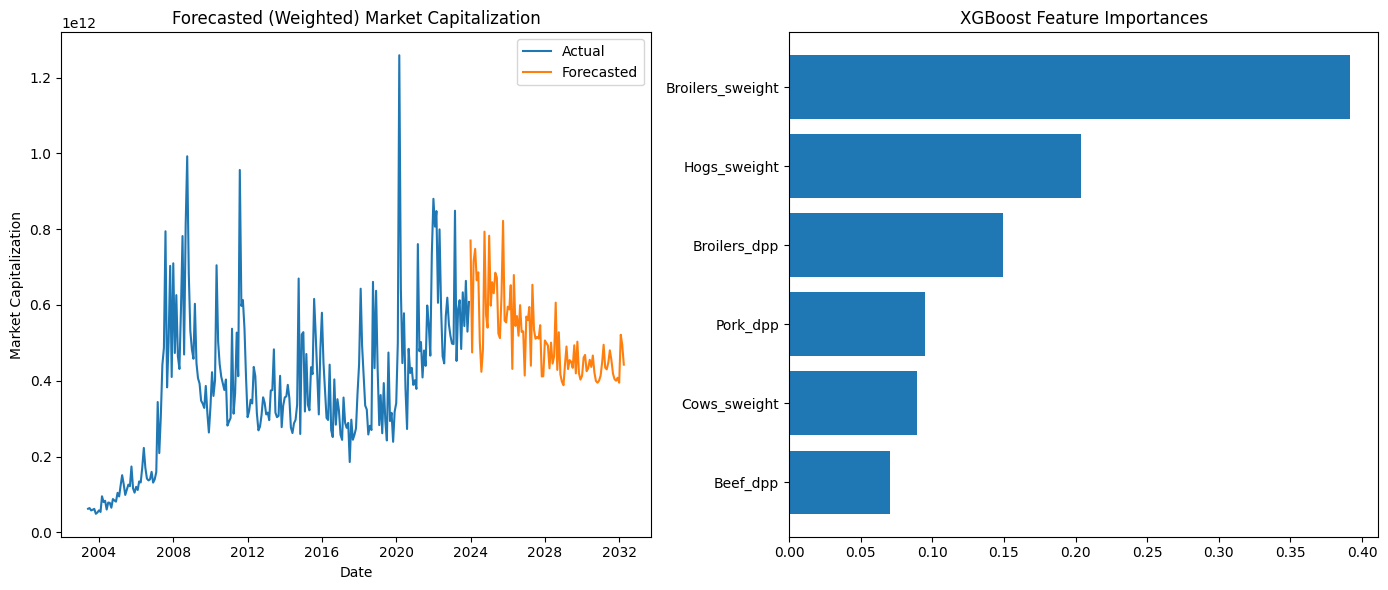

In [292]:
def forecast_XGB(df, target_name, df_test, diff=False):
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    model = XGBRegressor(random_state=42)
    model.fit(X, y)

    y_pred = model.predict(df_test)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(X.index, y, label="Actual")
    ax1.plot(df_test.index, y_pred, label="Forecasted")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Market Capitalization")
    ax1.set_title("Forecasted (Weighted) Market Capitalization")
    ax1.legend()

    ax2.set_title('XGBoost Feature Importances')
    feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values()
    ax2.barh(feat_imp.index, feat_imp.values)

    plt.tight_layout()

forecast_XGB(df, "Market Cap", df_test)

## Hmm what dis?

In [ ]:
beef_meat = pd.DataFrame(meat_prod[meat_prod['Animal'] == 'Beef'].drop('Date', axis=1).groupby('Date')['Production'].sum())

dd = meat_prod.drop('Date', axis=1).merge(cold_stor.drop('Date', axis=1), on=['Date', 'Animal'])
dd

Year_x  Month_x          Unit_x  Production  Animal  \
Date                                                              
2023-12-01    2023       12  Million Pounds      2189.8    Beef   
2023-12-01    2023       12  Million Pounds      2158.9    Beef   
2023-11-01    2023       11  Million Pounds      2280.9    Beef   
2023-11-01    2023       11  Million Pounds      2247.3    Beef   
2023-10-01    2023       10  Million Pounds      2340.9    Beef   
...            ...      ...             ...         ...     ...   
1983-05-01    1983        5  Million Pounds       166.5  Turkey   
1983-04-01    1983        4  Million Pounds       182.7  Turkey   
1983-03-01    1983        3  Million Pounds       135.5  Turkey   
1983-02-01    1983        2  Million Pounds       144.1  Turkey   
1983-01-01    1983        1  Million Pounds       192.7  Turkey   

           Commercial or Federally Inspected Type of Meat  Year_y  Month_y  \
Date                                                                         
2023-12-01                        Commercial     Red Meat    2023       12   
2023-12-01               Federally Inspected     Red Meat    2023       12   
2023-11-01                        Commercial     Red Meat    2023       11   
2023-11-01               Federally Inspected     Red Meat    2023       11   
2023-10-01                        Commercial     Red Meat    2023       10   
...                                      ...          ...     ...      ...   
1983-05-01               Federally Inspected      Poultry    1983        5   
1983-04-01               Federally Inspected      Poultry    1983        4   
1983-03-01               Federally Inspected      Poultry    1983        3   
1983-02-01               Federally Inspected      Poultry    1983        2   
1983-01-01               Federally Inspected      Poultry    1983        1   

                    Unit_y  Weight Type_Of_Meat  
Date                                             
2023-12-01  Million Pounds  457.41     Red Meat  
2023-12-01  Million Pounds  457.41     Red Meat  
2023-11-01  Million Pounds  445.67     Red Meat  
2023-11-01  Million Pounds  445.67     Red Meat  
2023-10-01  Million Pounds  420.85     Red Meat  
...                    ...     ...          ...  
1983-05-01  Million Pounds  192.27      Poultry  
1983-04-01  Million Pounds  185.33      Poultry  
1983-03-01  Million Pounds  187.69      Poultry  
1983-02-01  Million Pounds  193.83      Poultry  
1983-01-01  Million Pounds  203.91      Poultry  

[4704 rows x 12 columns]

In [ ]:
cold_stor['weight_diff'] = cold_stor.groupby('Animal')['Weight'].diff(1)
# dd['weight_diff'] = dd.groupby('Animal')['Weight'].diff(1)
# dd['DD'] = dd['Production'] - dd['weight_diff']
# dd['Date'] = dd.index
# dd

Animal
Barrows and Gilts       (0.9493473768234253, 6.612287015714647e-18)
Beef Cows              (0.9855335354804993, 2.6617042792054235e-08)
Boars and Stags        (0.8306543827056885, 4.7166438112054895e-31)
Broilers                  (0.89190673828125, 3.908313829798217e-18)
Bulls and Stags          (0.715679407119751, 7.082263892706443e-38)
Calves                  (0.8025021553039551, 5.278793215921616e-33)
Cattle                  (0.5352857112884521, 5.605193857299268e-45)
Dairy Cows              (0.9381534457206726, 8.134114803987436e-20)
Heifers                  (0.712765097618103, 5.113951304529246e-38)
Hogs                   (0.9356984496116638, 3.3551641179629883e-20)
Lambs and Yearlings     (0.8179131746292114, 5.768512831745018e-32)
Mature Sheep            (0.758278489112854, 1.1587461391963994e-35)
Other chickens           (0.9877195358276367, 0.018946215510368347)
Sheep and Lambs        (0.8128648400306702, 2.5907628067158405e-32)
Sows                    (0.70138257741928

Animal
Barrows and Gilts      Figure(640x480)
Beef Cows              Figure(640x480)
Boars and Stags        Figure(640x480)
Broilers               Figure(640x480)
Bulls and Stags        Figure(640x480)
Calves                 Figure(640x480)
Cattle                 Figure(640x480)
Dairy Cows             Figure(640x480)
Heifers                Figure(640x480)
Hogs                   Figure(640x480)
Lambs and Yearlings    Figure(640x480)
Mature Sheep           Figure(640x480)
Other chickens         Figure(640x480)
Sheep and Lambs        Figure(640x480)
Sows                   Figure(640x480)
Steers                 Figure(640x480)
Turkeys                Figure(640x480)
dtype: object

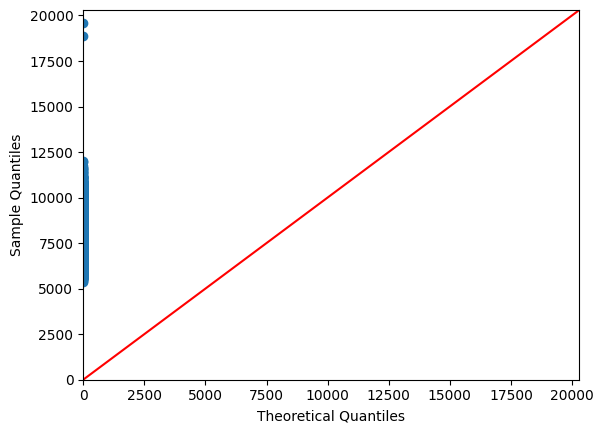

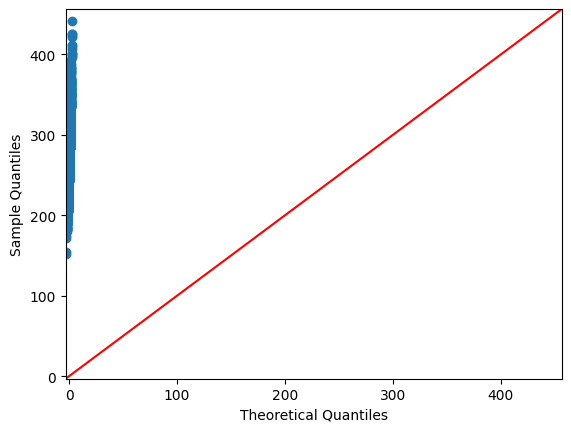

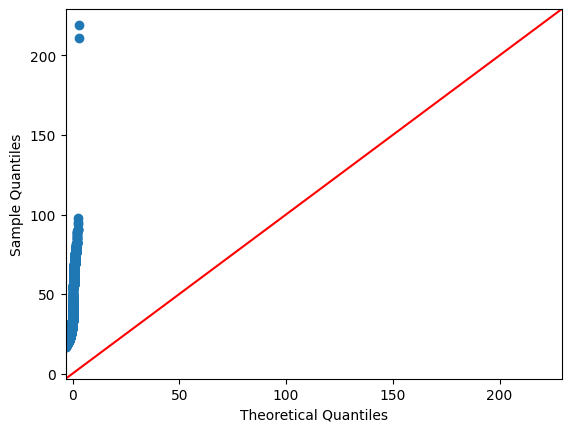

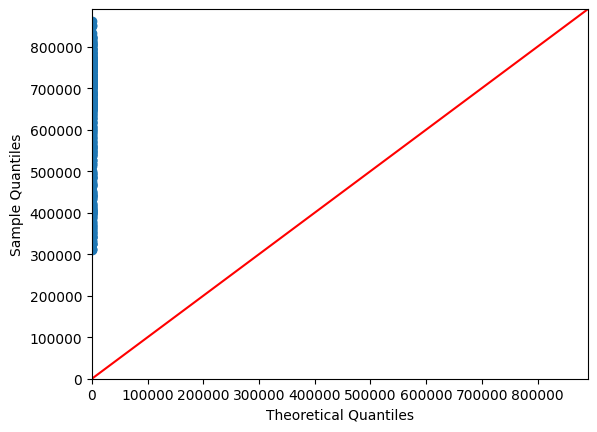

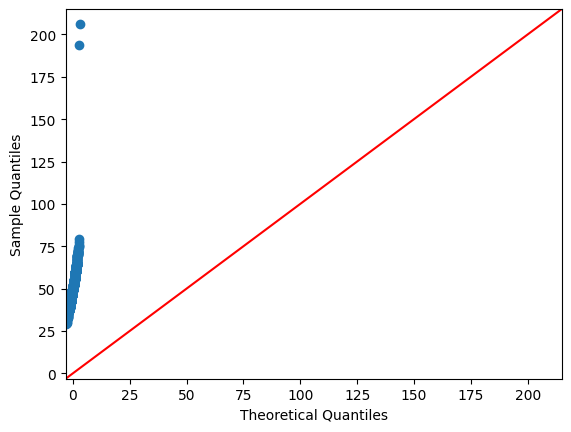

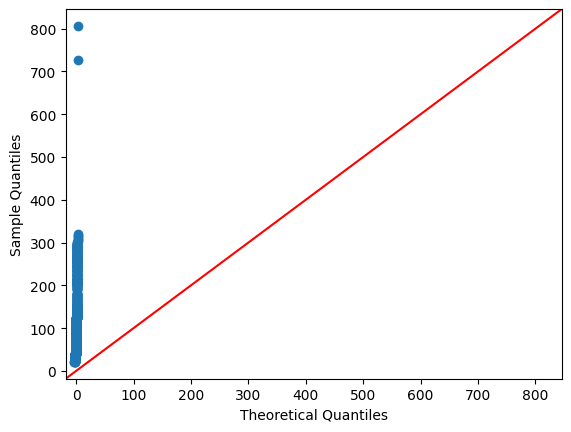

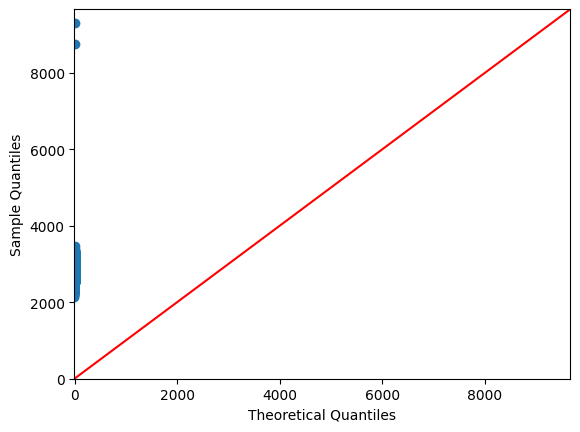

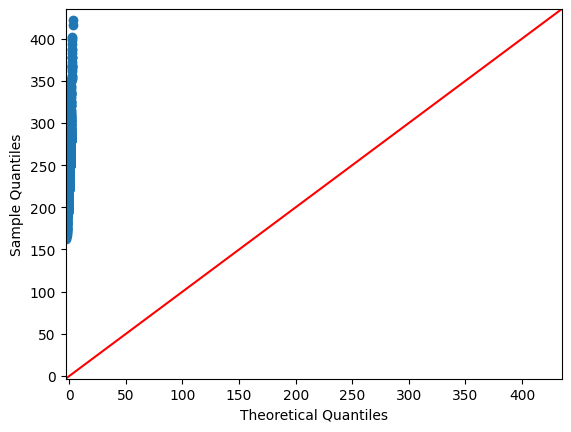

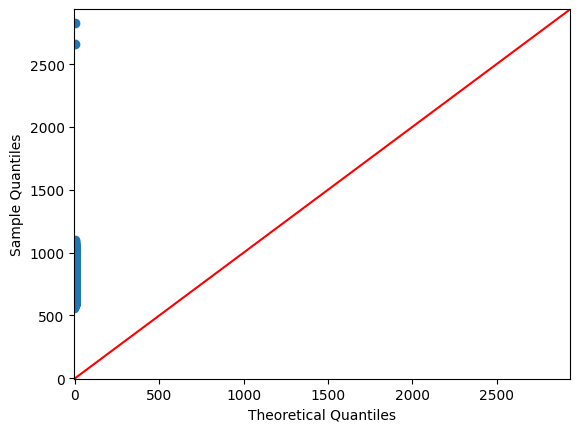

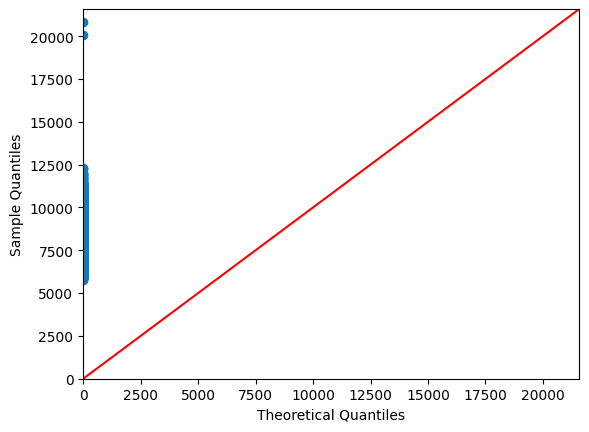

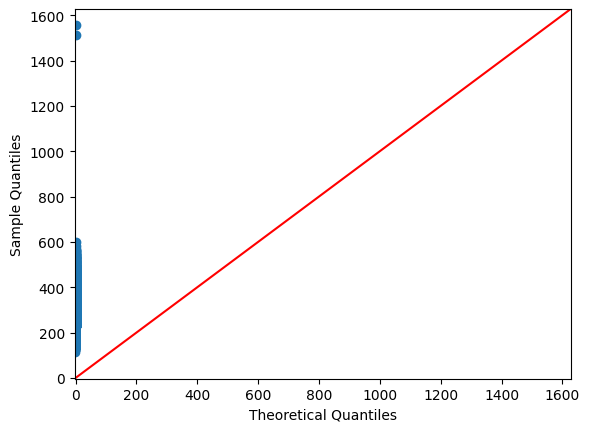

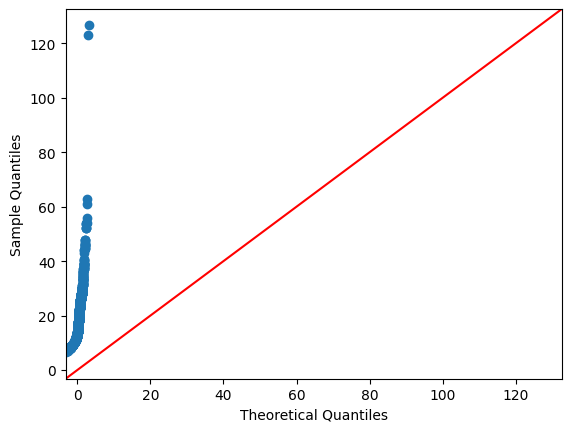

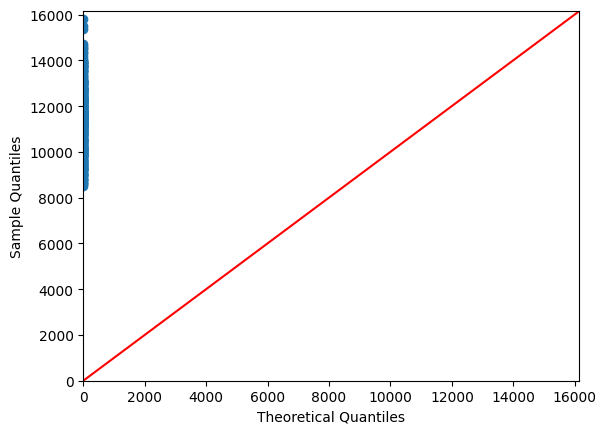

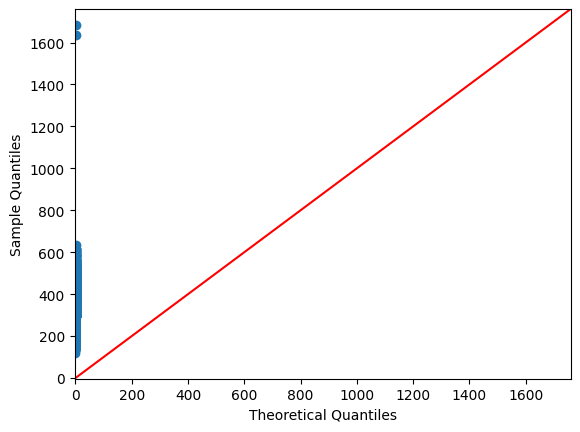

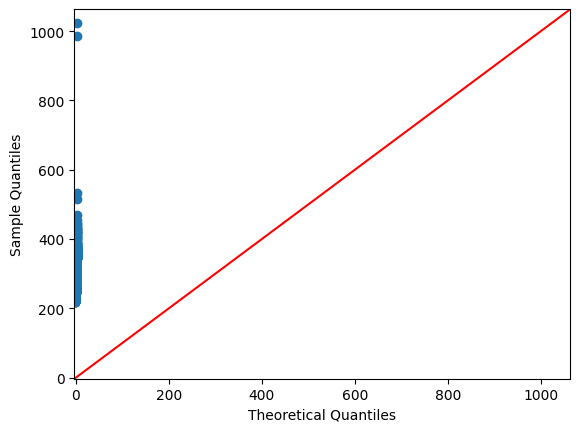

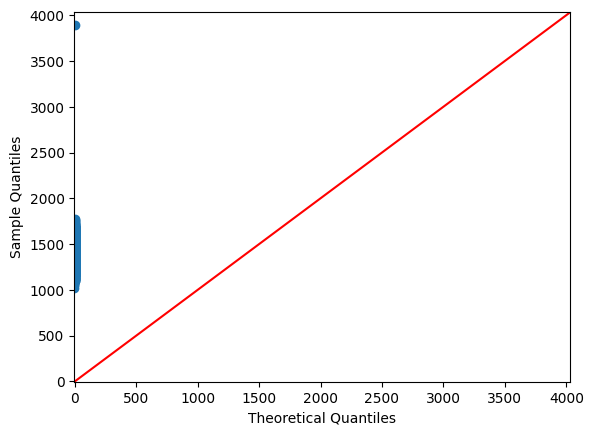

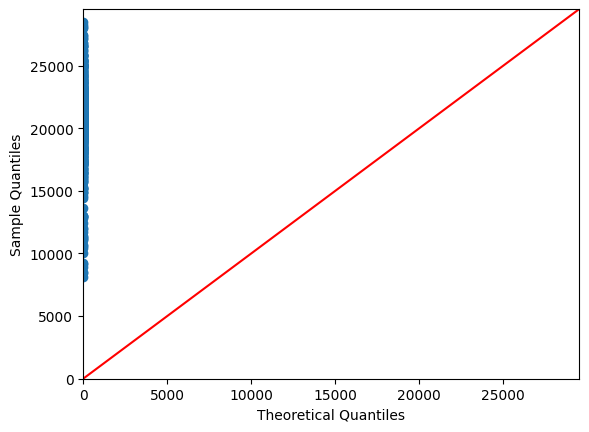

In [ ]:
print(slaughter_count.groupby('Animal').apply(lambda x: shapiro(x['Count'])))
slaughter_count.groupby('Animal').apply(lambda x: sm.qqplot(x['Count'], line='45'))

Animal
Beef               (0.9590244293212891, 1.9000863382689914e-10)
Broiler             (0.9797826409339905, 0.0014060845132917166)
Frozen Eggs         (0.951390266418457, 2.6809657271975595e-10)
Lamb and Mutton      (0.887458086013794, 1.832164111364635e-18)
Other Chicken       (0.9062633514404297, 7.945934021875826e-17)
Pork                 (0.9810852408409119, 5.28217742612469e-06)
Turkey             (0.9864005446434021, 0.00015140716277528554)
Veal                (0.8544357419013977, 6.590933519453827e-21)
dtype: object


Animal
Beef               Figure(640x480)
Broiler            Figure(640x480)
Frozen Eggs        Figure(640x480)
Lamb and Mutton    Figure(640x480)
Other Chicken      Figure(640x480)
Pork               Figure(640x480)
Turkey             Figure(640x480)
Veal               Figure(640x480)
dtype: object

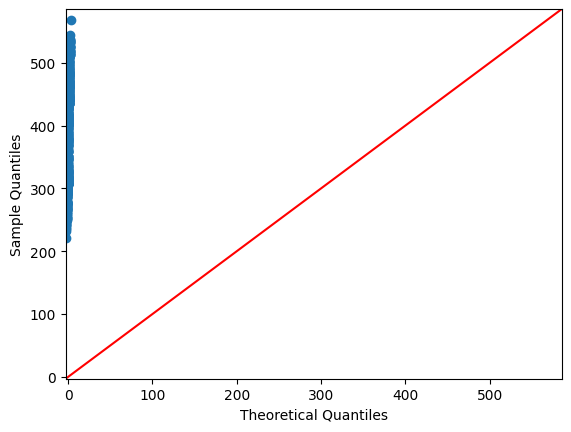

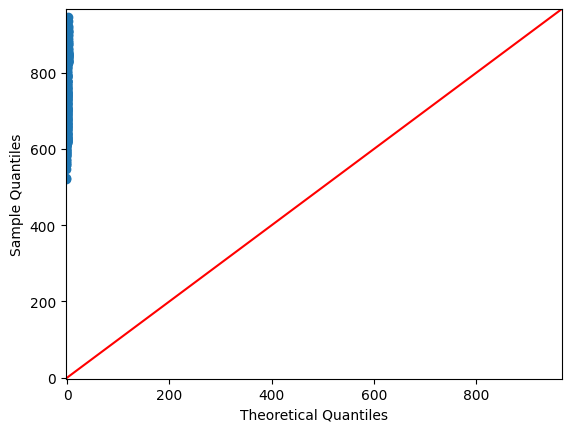

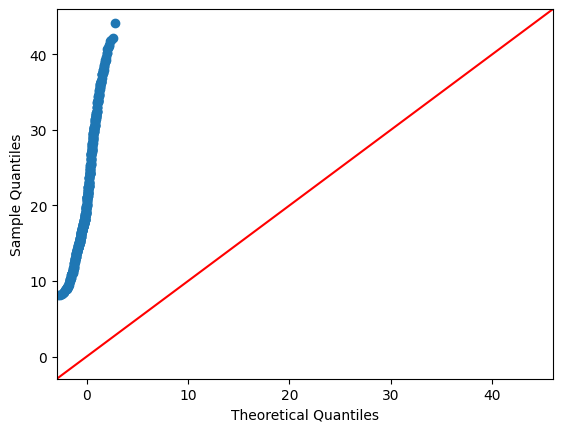

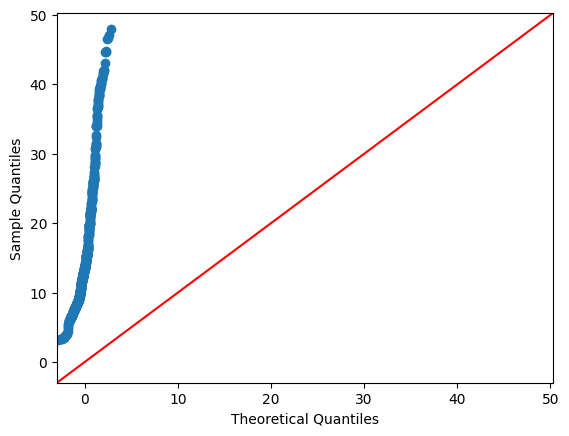

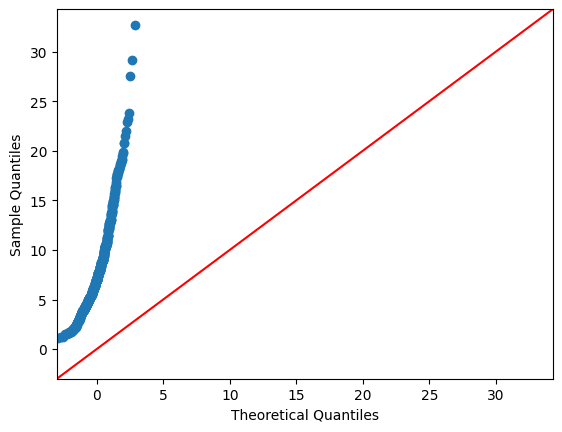

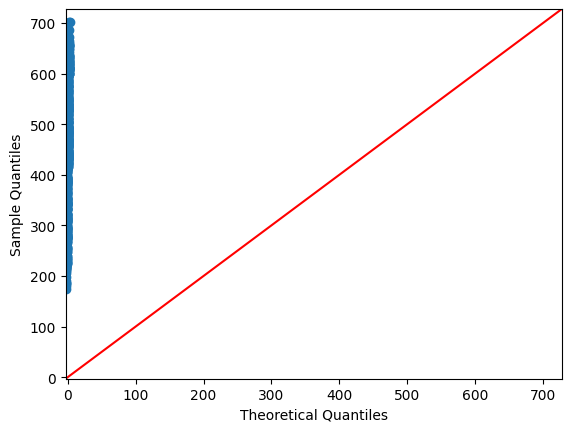

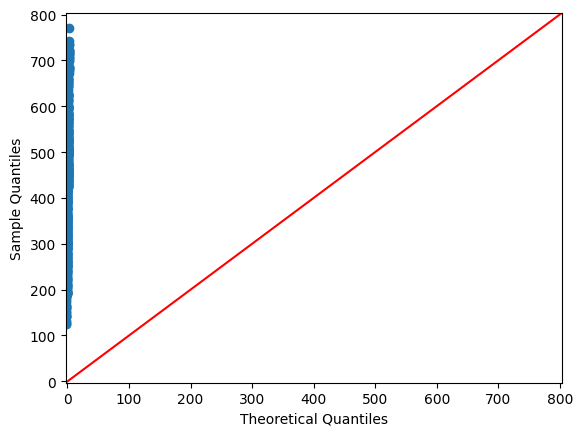

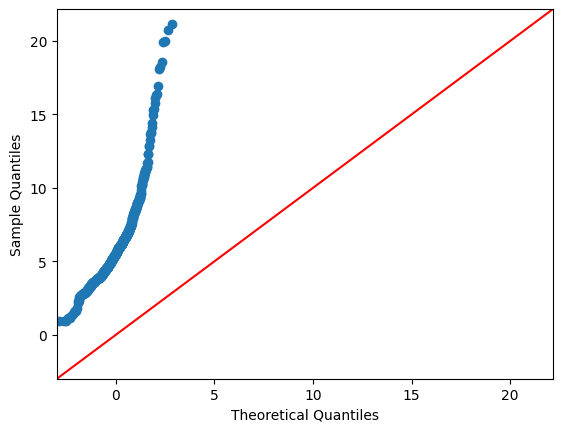

In [ ]:
from scipy.stats import shapiro
import statsmodels.api as sm

print(cold_stor.groupby('Animal').apply(lambda x: shapiro(x['Weight'][1:])))
cold_stor.groupby('Animal').apply(lambda x: sm.qqplot(x['Weight'][1:], line='45'))

## 2. Data Cleaning (Drop NA)

In [ ]:
meat_prod = pd.read_csv("/content/Meat_Stats_Meat_Production.csv", thousands = ",")

In [ ]:
meat_prod_cleaned = meat_prod.dropna()

In [ ]:
len(meat_prod_cleaned)

9620

In [ ]:
meat_prod_cleaned['Animal'].drop_duplicates()

0                   Beef
1236                Veal
2472                Pork
3708     Lamb and Mutton
9887            Broilers
11123      Other Chicken
12358             Turkey
Name: Animal, dtype: object

In [ ]:
meat_prod_cleaned[meat_prod_cleaned['Animal']=="Other Chicken"]

Date  Year  Month            Unit  Production         Animal  \
11123  Dec-2023  2023     12  Million Pounds        41.5  Other Chicken   
11124  Nov-2023  2023     11  Million Pounds        44.5  Other Chicken   
11125  Oct-2023  2023     10  Million Pounds        50.6  Other Chicken   
11126  Sep-2023  2023      9  Million Pounds        48.4  Other Chicken   
11127  Aug-2023  2023      8  Million Pounds        51.1  Other Chicken   
...         ...   ...    ...             ...         ...            ...   
11394  May-2001  2001      5  Million Pounds        45.6  Other Chicken   
11395  Apr-2001  2001      4  Million Pounds        42.2  Other Chicken   
11396  Mar-2001  2001      3  Million Pounds        44.4  Other Chicken   
11397  Feb-2001  2001      2  Million Pounds        39.7  Other Chicken   
11398  Jan-2001  2001      1  Million Pounds        42.7  Other Chicken   

      Commercial or Federally Inspected Type of Meat  
11123               Federally Inspected      Poultry  
11124               Federally Inspected      Poultry  
11125               Federally Inspected      Poultry  
11126               Federally Inspected      Poultry  
11127               Federally Inspected      Poultry  
...                                 ...          ...  
11394               Federally Inspected      Poultry  
11395               Federally Inspected      Poultry  
11396               Federally Inspected      Poultry  
11397               Federally Inspected      Poultry  
11398               Federally Inspected      Poultry  

[276 rows x 8 columns]

In [ ]:
meat_prod_cleaned.to_csv("Cleaned_Meat_Stats_Meat_Production.csv")

In [ ]:
### Function to remove NA value
def remove_na(datapath):
  data = pd.read_csv(datapath)
  data_clean = data.dropna()
  numDataRemoved = len(data) - len(data_clean)
  print("Number of data removed: " + str(numDataRemoved))
  data_clean.to_csv("Cleaned_"+datapath[9:]) #Apply only in google colab file path format
  return data_clean

In [ ]:
Cleaned_Meat_Stats_Cold_Storage = remove_na('/content/Meat_Stats_Cold_Storage.csv')

Number of data removed: 330


In [ ]:
remove_na('/content/Meat_Stats_Slaughter_Counts.csv')
remove_na("/content/Meat_Stats_Slaughter_Weights.csv")
remove_na('/content/Nutrition_Physical_Activity_and_Obesity_Data.csv')
remove_na('/content/acs_5yr_est_selected_economic_characteristics_2010-2022.csv')
remove_na('/content/all_commodities.csv')

Number of data removed: 217


#### The <b>Nutrition_Physical_Activity_and_Obesity_Data.csv</b> file columns:
* Data_Value_Unit: NaN

* Data_Value_Type: All has the same value: "Value"

* Data_Value_Footnote_Symbol: 19781 datas (all are '-' or '~')

* Data_Value_Footnote: 19781 datas (all is "Data not available because sample size is insufficient or data not reported.")

* Age: 19980

* Gender: 12388 datas

* Education: 13320 datas

* Total: 6194 datas (all data is "Total")
--> I decided to drop only the Data_Value_Unit column

In [ ]:
nutrition_data = pd.read_csv('/content/Nutrition_Physical_Activity_and_Obesity_Data.csv')
nutrition_data = nutrition_data.drop(columns = ['Data_Value_Unit'])

In [ ]:
nutrition_data["Data_Value_Footnote_Symbol"].drop_duplicates()
nutrition_data.to_csv("Cleaned_Nutrition_Physical_Activity_and_Obesity_Data.csv")

#### The <b>acs_5yr_est_selected_economic_characteristics_2010-2022.csv</b> file:
* Idt think file will help much since it is the survey on American with their Economic status and relevant information

In [ ]:
dummy1 = pd.read_csv('/content/acs_5yr_est_selected_economic_characteristics_2010-2022.csv')

ParserError: Error tokenizing data. C error: EOF inside string starting at row 34845

In [ ]:
dummy1

NameError: name 'dummy1' is not defined

## 3. Try to plot stocks and meat production + cold storage

#### i) Cold storage data

In [ ]:
cold_stor = pd.read_csv("/content/Meat_Stats_Cold_Storage.csv")
# cold_stor = cold_stor.drop(columns = ["Unnamed: 0"])
cold_stor

Date  Year  Month            Unit       Animal  Weight Type_Of_Meat
0     Dec-2023  2023     12  Million Pounds         Beef  457.41     Red Meat
1     Nov-2023  2023     11  Million Pounds         Beef  445.67     Red Meat
2     Oct-2023  2023     10  Million Pounds         Beef  420.85     Red Meat
3     Sep-2023  2023      9  Million Pounds         Beef  395.40     Red Meat
4     Aug-2023  2023      8  Million Pounds         Beef  410.46     Red Meat
...        ...   ...    ...             ...          ...     ...          ...
3931  May-1983  1983      5  Million Pounds  Frozen Eggs     NaN      Poultry
3932  Apr-1983  1983      4  Million Pounds  Frozen Eggs     NaN      Poultry
3933  Mar-1983  1983      3  Million Pounds  Frozen Eggs     NaN      Poultry
3934  Feb-1983  1983      2  Million Pounds  Frozen Eggs     NaN      Poultry
3935  Jan-1983  1983      1  Million Pounds  Frozen Eggs     NaN      Poultry

[3936 rows x 7 columns]

In [ ]:
#function to plot specific type of Animal
def plot_cold_animal(animal, df):
  fig, ax = plt.subplots(figsize = (10,5))
  animal_df = df[df['Animal'] == animal]
  animal_df = animal_df[::-1] #reverse the df since they format the earlier date first
  # Plot the time series for the current animal
  animal_df.plot(x='Date', y='Weight', ax=ax, label=animal)

  # ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%M'))
  # Display the legend
  ax.legend()

  # Show the plot
  plt.show()

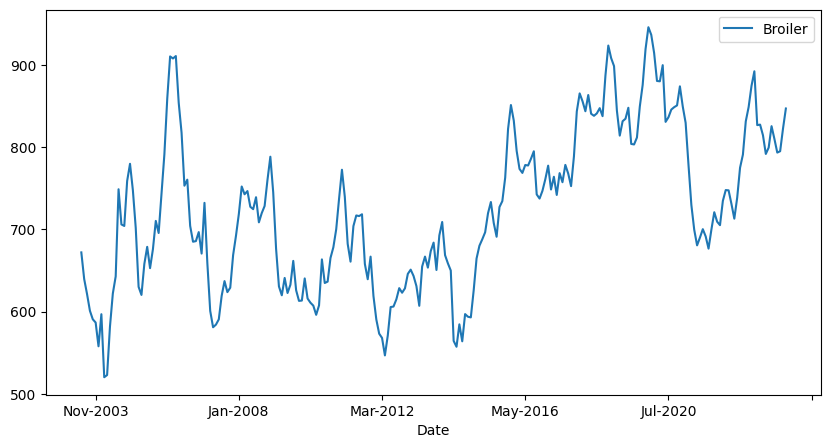

In [ ]:
plot_cold_animal("Broiler", cold_stor)

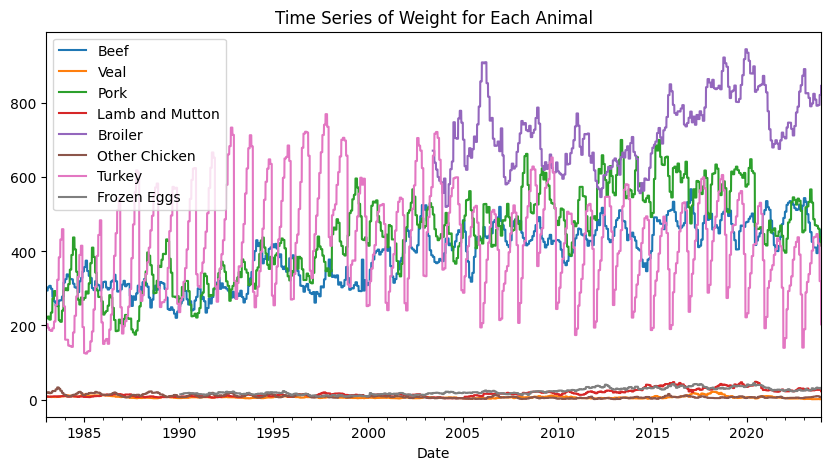

In [ ]:
# Plot all animal in the same figure
cold_stor['Date'] = pd.to_datetime(cold_stor['Date'])
cold_stor = cold_stor.set_index('Date')

fig, ax = plt.subplots(figsize=(10, 5))

# Iterate over the unique animals in the DataFrame
for animal in cold_stor['Animal'].unique():
    animal_df = cold_stor[cold_stor['Animal'] == animal]
    animal_df = animal_df['Weight'].resample('D').mean().fillna(method='ffill')
    animal_df.plot(ax=ax, label=animal)

ax.set_title('Time Series of Weight for Each Animal')
ax.legend()
plt.show()

Exception ignored in: <function _xla_gc_callback at 0x7c81fbfcc550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


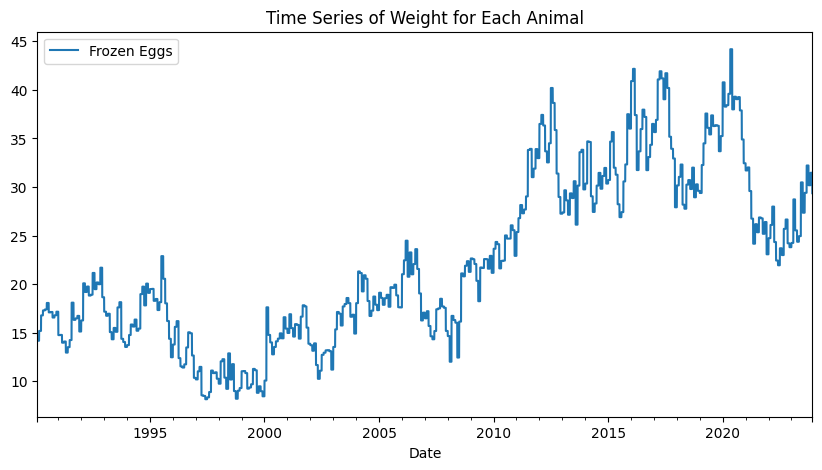

In [ ]:
# Plot all animal in the same figure
# cold_stor['Date'] = pd.to_datetime(cold_stor['Date'])
# cold_stor = cold_stor.set_index('Date')

fig, ax = plt.subplots(figsize=(10, 5))

# Iterate over the unique animals in the DataFrame
for animal in cold_stor['Animal'].unique():
    if animal in ['Turkey', 'Veal', 'Other Chicken', 'Beef', 'Pork', 'Lamb and Mutton', 'Broiler']:
      continue
    animal_df = cold_stor[cold_stor['Animal'] == animal]
    animal_df = animal_df['Weight'].resample('D').mean().fillna(method='ffill')
    animal_df.plot(ax=ax, label=animal)

ax.set_title('Time Series of Weight for Each Animal')
ax.legend()
plt.show()

#### ii) Meat Production Data

In [ ]:
meat_prod = pd.read_csv("/content/Cleaned_Meat_Stats_Meat_Production.csv")
meat_prod = meat_prod.drop(columns = ["Unnamed: 0"])
meat_prod

Date  Year  Month            Unit Production  Animal  \
0     Dec-2023  2023     12  Million Pounds   2,189.80    Beef   
1     Nov-2023  2023     11  Million Pounds   2,280.90    Beef   
2     Oct-2023  2023     10  Million Pounds   2,340.90    Beef   
3     Sep-2023  2023      9  Million Pounds   2,149.40    Beef   
4     Aug-2023  2023      8  Million Pounds   2,363.50    Beef   
...        ...   ...    ...             ...        ...     ...   
9615  Jun-1960  1960      6  Million Pounds       27.1  Turkey   
9616  May-1960  1960      5  Million Pounds       16.2  Turkey   
9617  Apr-1960  1960      4  Million Pounds       13.4  Turkey   
9618  Mar-1960  1960      3  Million Pounds         14  Turkey   
9619  Feb-1960  1960      2  Million Pounds       22.1  Turkey   

     Commercial or Federally Inspected Type of Meat  
0                           Commercial     Red Meat  
1                           Commercial     Red Meat  
2                           Commercial     Red Meat  
3                           Commercial     Red Meat  
4                           Commercial     Red Meat  
...                                ...          ...  
9615               Federally Inspected      Poultry  
9616               Federally Inspected      Poultry  
9617               Federally Inspected      Poultry  
9618               Federally Inspected      Poultry  
9619               Federally Inspected      Poultry  

[9620 rows x 8 columns]

In [ ]:
### Production Col is string --> Convert to float
for i in range(0,len(meat_prod)):
  meat_prod['Production'][i] = float(meat_prod['Production'][i].replace(",", ""))

In [ ]:
#function to plot specific type of Animal
def plot_meat_prod(animal, df):
  fig, ax = plt.subplots(figsize = (10,5))
  animal_df = df[df['Animal'] == animal]
  animal_df = animal_df[::-1] #reverse the df since they format the earlier date first
  # Plot the time series for the current animal
  animal_df.plot(x='Date', y='Production', ax=ax, label=animal)

  # ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%M'))
  # Display the legend
  ax.legend()

  # Show the plot
  plt.show()

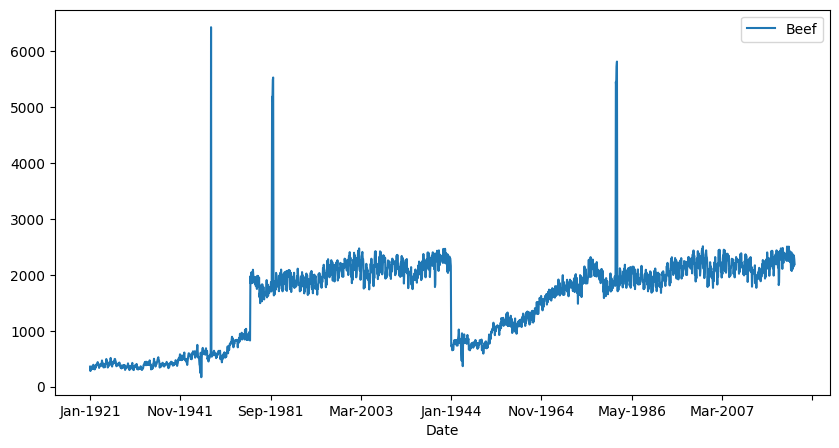

In [ ]:
plot_meat_prod("Beef", meat_prod)

#### * Combine Meat Prod & Stocks

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

def plot_meat_prod_vs_stock(animal, ticker, meat_prod, stock_df):

    animal_df = meat_prod[meat_prod['Animal'] == animal]
    animal_df = animal_df[::-1]
    animal_df['Date'] = pd.to_datetime(animal_df['Date'])
    animal_df = animal_df.set_index('Date')


    stock_data = stock_df[stock_df["Ticker_Symbol"] == ticker]
    stock_data = stock_data[::-1]
    stock_data['Date-Time'] = pd.to_datetime(stock_data['Date-Time'])
    stock_data = stock_data.set_index('Date-Time')
    stock_data_monthly = stock_data.resample('M').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=(f"{animal} Production", f"{ticker} Stock Price"))
    fig.add_trace(go.Scatter(x=animal_df.index, y=animal_df['Production'], name=f"{animal} Production"), row=1, col=1)
    fig.add_trace(go.Candlestick(x=stock_data_monthly.index,
                                  open=stock_data_monthly['Open'],
                                  high=stock_data_monthly['High'],
                                  low=stock_data_monthly['Low'],
                                  close=stock_data_monthly['Close'],
                                  name=f"{ticker} Stock Price"), row=2, col=1)

    # Update layout and axis titles
    fig.update_layout(title=f"{animal} Production vs {ticker} Stock Price",
                      xaxis_title="Date")

    fig.show()

In [ ]:
plot_meat_prod_vs_stock('Turkey', 'HRL', meat_prod, stock_and_etfs)

#### * Combine Meat Cold Storage & Stocks

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

def plot_cold_stor_vs_stock(animal, ticker, meat_cold, stock_df):

    animal_df = meat_cold[meat_cold['Animal'] == animal]
    animal_df = animal_df[::-1]
    animal_df['Date'] = pd.to_datetime(animal_df['Date'])
    animal_df = animal_df.set_index('Date')


    stock_data = stock_df[stock_df["Ticker_Symbol"] == ticker]
    stock_data = stock_data[::-1]
    stock_data['Date-Time'] = pd.to_datetime(stock_data['Date-Time'])
    stock_data = stock_data.set_index('Date-Time')  # Set the 'Date-Time' column as the index

    # Resample the stock data to monthly frequency and aggregate data
    stock_data_monthly = stock_data.resample('M').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=(f"{animal} Weight", f"{ticker} Stock Price"))


    fig.add_trace(go.Scatter(x=animal_df.index, y=animal_df['Weight'], name=f"{animal} Weight"), row=1, col=1)
    fig.add_trace(go.Candlestick(x=stock_data_monthly.index,
                                  open=stock_data_monthly['Open'],
                                  high=stock_data_monthly['High'],
                                  low=stock_data_monthly['Low'],
                                  close=stock_data_monthly['Close'],
                                  name=f"{ticker} Stock Price"), row=2, col=1)

    fig.update_layout(title=f"{animal} Weight vs {ticker} Stock Price",
                      xaxis_title="Date")

    fig.show()

In [ ]:
plot_cold_stor_vs_stock("Beef", "HRL", cold_stor, stock_and_etfs)

#### Calculate market cap of each stock & plotting

In [138]:
stock_and_etfs_dummy = pd.read_csv("/content/all_stock_and_etfs.csv")
# stock_and_etfs_dummy_1 = stock_and_etfs_dummy.drop(columns = ['index'])

In [ ]:
# stock_and_etfs_dummy[stock_and_etfs_dummy["Ticker_Symbol"] == "ALG"]["Volume"][:13].mean()

71324.76923076923

In [139]:
# Convert 'Date-Time' to datetime format
stock_and_etfs_dummy['Date-Time'] = pd.to_datetime(stock_and_etfs_dummy['Date-Time'])
stock_and_etfs_dummy['Month-Year'] = stock_and_etfs_dummy['Date-Time'].dt.strftime('%Y-%m')
# Create an empty DataFrame to store the result
df_groupby_ticker_month = pd.DataFrame()

# Iterate over unique ticker symbols
for ticker in stock_and_etfs_dummy["Ticker_Symbol"].unique():
    # Filter the DataFrame for the current ticker
    df_ticker = stock_and_etfs_dummy[stock_and_etfs_dummy["Ticker_Symbol"] == ticker]

    # Set 'Date-Time' as the index
    df_ticker.set_index('Date-Time', inplace=True)

    # Resample to get monthly OHLCV data
    monthly_ohlc = df_ticker.resample('M').agg({
        'Close': 'last',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Volume': 'sum'
    })

    # Add 'Ticker_Symbol' & "avg daily volume" column
    monthly_ohlc['Ticker_Symbol'] = ticker

    avg_daily_volume = df_ticker['Volume'].resample('M').sum() / df_ticker['Volume'].resample('M').count()
    monthly_ohlc["Average Daily Volume"] = avg_daily_volume

    # Append the result to df_groupby_ticker_month
    df_groupby_ticker_month = pd.concat([df_groupby_ticker_month, monthly_ohlc])


# Reset index to include 'Ticker_Symbol' and 'Date-Time' as columns
df_groupby_ticker_month.reset_index(inplace=True)

print(df_groupby_ticker_month)


      Date-Time   Close    Open     High     Low   Volume Ticker_Symbol  \
0    1999-11-30   44.56   43.38   44.880   39.88  3319300           HRL   
1    1999-12-31   40.63   44.44   45.130   40.00  2970500           HRL   
2    2000-01-31   40.63   40.62   41.940   37.00  2376900           HRL   
3    2000-02-29   16.69   40.38   40.380   16.63  4536100           HRL   
4    2000-03-31   16.44   16.63   17.250   13.63  9534300           HRL   
...         ...     ...     ...      ...     ...      ...           ...   
7809 2023-10-31  160.30  172.93  178.890  157.74  1032287           ALG   
7810 2023-11-30  183.70  160.15  191.905  158.16  1185198           ALG   
7811 2023-12-31  210.19  183.49  216.340  182.30  1071571           ALG   
7812 2024-01-31  212.28  208.00  217.680  196.38  1449532           ALG   
7813 2024-02-29  215.92  213.83  231.400  209.14   927222           ALG   

      Average Daily Volume  
0            158061.904762  
1            135022.727273  
2           

#### Calculate average daily volume

In [140]:
df_groupby_ticker_month

Date-Time   Close    Open     High     Low   Volume Ticker_Symbol  \
0    1999-11-30   44.56   43.38   44.880   39.88  3319300           HRL   
1    1999-12-31   40.63   44.44   45.130   40.00  2970500           HRL   
2    2000-01-31   40.63   40.62   41.940   37.00  2376900           HRL   
3    2000-02-29   16.69   40.38   40.380   16.63  4536100           HRL   
4    2000-03-31   16.44   16.63   17.250   13.63  9534300           HRL   
...         ...     ...     ...      ...     ...      ...           ...   
7809 2023-10-31  160.30  172.93  178.890  157.74  1032287           ALG   
7810 2023-11-30  183.70  160.15  191.905  158.16  1185198           ALG   
7811 2023-12-31  210.19  183.49  216.340  182.30  1071571           ALG   
7812 2024-01-31  212.28  208.00  217.680  196.38  1449532           ALG   
7813 2024-02-29  215.92  213.83  231.400  209.14   927222           ALG   

      Average Daily Volume  
0            158061.904762  
1            135022.727273  
2            118845.000000  
3            226805.000000  
4            414534.782609  
...                    ...  
7809          46922.136364  
7810          56438.000000  
7811          53578.550000  
7812          69025.333333  
7813          71324.769231  

[7814 rows x 8 columns]

#### Calculate Turnover Ratio

In [141]:
turnover = df_groupby_ticker_month['Average Daily Volume']/df_groupby_ticker_month['Volume']
df_groupby_ticker_month["Turnover Ratio"] = turnover

#### Total Shares Traded

In [142]:
total_shares_traded = df_groupby_ticker_month['Volume'] * df_groupby_ticker_month['Turnover Ratio']
df_groupby_ticker_month["total_shares_traded Ratio"] = total_shares_traded

#### Calculate Market Capitalization Estimation Factor

In [143]:
monthy_market_cap = df_groupby_ticker_month["Close"]*df_groupby_ticker_month["Volume"]
df_groupby_ticker_month["Monthly market capitalisation"] = monthy_market_cap

In [144]:
df_market_cap = df_groupby_ticker_month[["Date-Time", "Monthly market capitalisation", "Ticker_Symbol"]]

In [145]:
df_market_cap['Date-Time'] = pd.to_datetime(df_market_cap['Date-Time'])

# Format 'Date-Time' to month-year format
df_market_cap['Date-Time'] = df_market_cap['Date-Time'].dt.strftime('%Y-%m')

In [146]:
df_market_cap

Date-Time  Monthly market capitalisation Ticker_Symbol
0      1999-11                   1.479080e+08           HRL
1      1999-12                   1.206914e+08           HRL
2      2000-01                   9.657345e+07           HRL
3      2000-02                   7.570751e+07           HRL
4      2000-03                   1.567439e+08           HRL
...        ...                            ...           ...
7809   2023-10                   1.654756e+08           ALG
7810   2023-11                   2.177209e+08           ALG
7811   2023-12                   2.252335e+08           ALG
7812   2024-01                   3.077067e+08           ALG
7813   2024-02                   2.002058e+08           ALG

[7814 rows x 3 columns]

##### First strategy: Equal Weight Portfolio

In [147]:
df_market_cap_test = df_market_cap.copy()

In [148]:
df_hehe = df_market_cap_test[df_market_cap_test['Date-Time'] == '1999-11']
total_market_cap = df_hehe['Monthly market capitalisation'].sum()
weighted_market_average = total_market_cap/len(df_hehe)
print("hehe" + str(weighted_market_average))

hehe1443663300.5147827


In [ ]:
10181822928.887812/1443663300.5147827

7.052768415777535

In [ ]:
df_hihi = df_market_cap_stra2[df_market_cap_stra2['Date-Time'] == '1999-11']
total_market_cap = df_hihi['Monthly market capitalisation'].sum()
weights = df_hihi['Monthly market capitalisation'] / total_market_cap
print(weights)
weighted_market_cap = df_hihi['Monthly market capitalisation'] * weights
print(weighted_market_cap)
weighted_market_cap_sum = weighted_market_cap.sum()
weighted_market_cap_sum

0       0.004454
454     0.011467
746     0.002312
1038    0.043939
1330    0.082281
1733    0.000345
2270    0.000285
2562    0.013740
2854    0.003694
3146    0.010914
3438    0.054104
3730    0.041398
4240    0.000303
4658    0.524512
4950    0.025444
5242    0.002866
5534    0.016789
5826    0.000328
6118    0.019378
6410    0.000289
6702    0.127303
6994    0.013776
7522    0.000080
Name: Monthly market capitalisation, dtype: float64
0       6.588547e+05
454     4.365732e+06
746     1.774753e+05
1038    6.410521e+07
1330    2.247964e+08
1733    3.961051e+03
2270    2.690473e+03
2562    6.268536e+06
2854    4.531884e+05
3146    3.955170e+06
3438    9.719690e+07
3730    5.690497e+07
4240    3.038828e+03
4658    9.134914e+09
4950    2.149676e+07
5242    2.726831e+05
5534    9.359077e+06
5826    3.574333e+03
6118    1.246796e+07
6410    2.777138e+03
6702    5.381125e+08
6994    6.301377e+06
7522    2.111749e+02
Name: Monthly market capitalisation, dtype: float64


10181822928.887812

In [ ]:
weights

0       0.004454
454     0.011467
746     0.002312
1038    0.043939
1330    0.082281
1733    0.000345
2270    0.000285
2562    0.013740
2854    0.003694
3146    0.010914
3438    0.054104
3730    0.041398
4240    0.000303
4658    0.524512
4950    0.025444
5242    0.002866
5534    0.016789
5826    0.000328
6118    0.019378
6410    0.000289
6702    0.127303
6994    0.013776
7522    0.000080
Name: Monthly market capitalisation, dtype: float64

In [149]:
# Group by 'Date-Time' (which now contains only month and year)
df_market_cap_grouped = df_market_cap_test.groupby('Date-Time').agg({
    'Monthly market capitalisation': 'mean'
}).reset_index()

In [ ]:
df_market_cap_grouped

Date-Time  Monthly market capitalisation
0   1999-11-01                   1.443663e+09
1   1999-12-01                   1.510149e+09
2   2000-01-01                   1.864346e+09
3   2000-02-01                   1.897832e+09
4   2000-03-01                   2.683153e+09
..         ...                            ...
287 2023-10-01                   3.656930e+10
288 2023-11-01                   3.076651e+10
289 2023-12-01                   3.449062e+10
290 2024-01-01                   3.650531e+10
291 2024-02-01                   2.619290e+10

[292 rows x 2 columns]

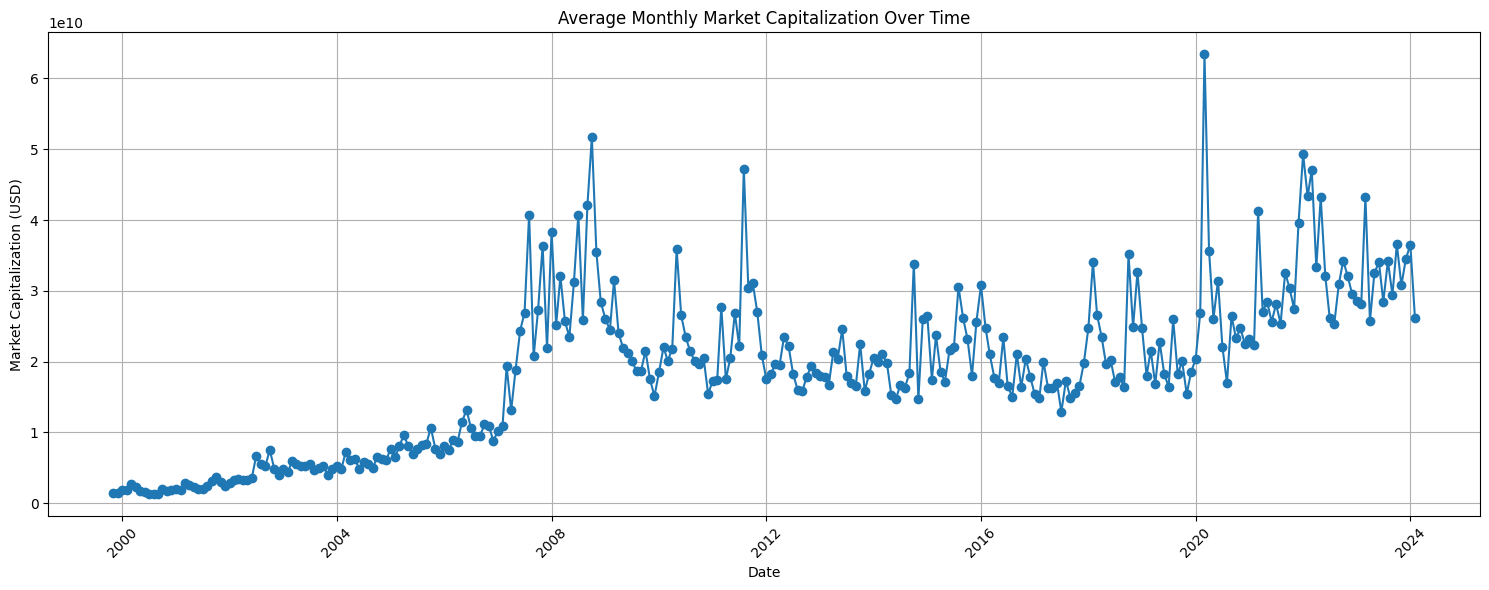

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df_market_cap_grouped containing your data

# Convert 'Date-Time' to datetime format
df_market_cap_grouped['Date-Time'] = pd.to_datetime(df_market_cap_grouped['Date-Time'])

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df_market_cap_grouped['Date-Time'], df_market_cap_grouped['Monthly market capitalisation'], marker='o', linestyle='-')
plt.title('Average Monthly Market Capitalization Over Time')
plt.xlabel('Date')
plt.ylabel('Market Capitalization (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


##### Make smoother

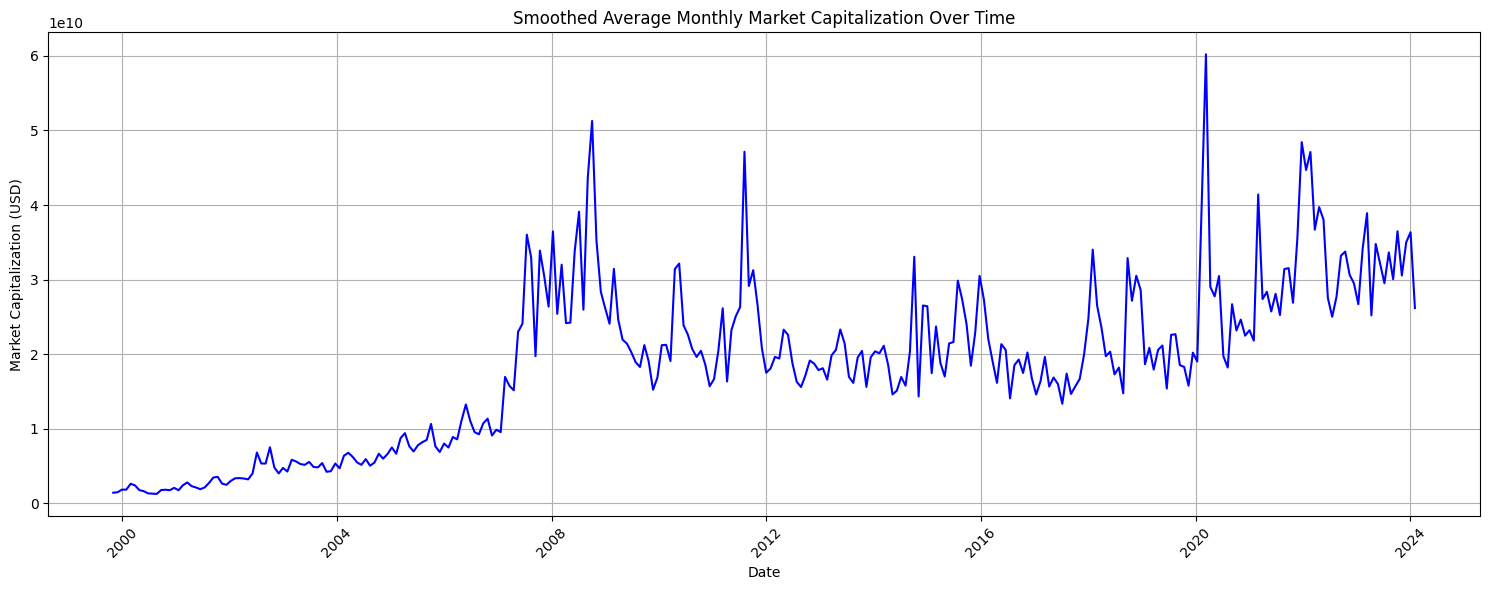

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Assuming you have a DataFrame named df_market_cap_grouped containing your data

# Convert 'Date-Time' to datetime format
df_market_cap_grouped['Date-Time'] = pd.to_datetime(df_market_cap_grouped['Date-Time'])

# Sort DataFrame by 'Date-Time'
df_market_cap_grouped.sort_values(by='Date-Time', inplace=True)

# Convert 'Date-Time' to numeric values
x_numeric = pd.to_numeric(df_market_cap_grouped['Date-Time'])

# Interpolate y-values for smoother curve
spl = make_interp_spline(x_numeric, df_market_cap_grouped['Monthly market capitalisation'])
x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 300)
y_smooth = spl(x_smooth)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(pd.to_datetime(x_smooth), y_smooth, linestyle='-', color='blue')
plt.title('Smoothed Average Monthly Market Capitalization Over Time')
plt.xlabel('Date')
plt.ylabel('Market Capitalization (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()



##### Second strategy: Base on allocation scheme same as S&P500

In [150]:
df_market_cap_stra2 = df_market_cap.copy()
df_market_cap_stra2

Date-Time  Monthly market capitalisation Ticker_Symbol
0      1999-11                   1.479080e+08           HRL
1      1999-12                   1.206914e+08           HRL
2      2000-01                   9.657345e+07           HRL
3      2000-02                   7.570751e+07           HRL
4      2000-03                   1.567439e+08           HRL
...        ...                            ...           ...
7809   2023-10                   1.654756e+08           ALG
7810   2023-11                   2.177209e+08           ALG
7811   2023-12                   2.252335e+08           ALG
7812   2024-01                   3.077067e+08           ALG
7813   2024-02                   2.002058e+08           ALG

[7814 rows x 3 columns]

In [151]:
df_market_cap_stra2['Date-Time']

0       1999-11
1       1999-12
2       2000-01
3       2000-02
4       2000-03
         ...   
7809    2023-10
7810    2023-11
7811    2023-12
7812    2024-01
7813    2024-02
Name: Date-Time, Length: 7814, dtype: object

In [152]:
df_hihi = df_market_cap_stra2[df_market_cap_stra2['Date-Time'] == '1999-11']
total_market_cap = df_hihi['Monthly market capitalisation'].sum()
weights = df_hihi['Monthly market capitalisation'] / total_market_cap
weighted_market_cap = df_hihi['Monthly market capitalisation'] * weights
weighted_market_cap_sum = weighted_market_cap.sum()
weighted_market_average = weighted_market_cap_sum/len(df_hihi)
weighted_market_average

442687953.4299049

In [153]:
df_market_final = pd.DataFrame(columns=['Date-Time', 'Weighted market capitalisation'])

for date in df_market_cap_stra2['Date-Time'].unique():
    df_dummy = df_market_cap_stra2[df_market_cap_stra2['Date-Time'] == date]

    # Calculate total market capitalization for the current month
    total_market_cap = df_dummy['Monthly market capitalisation'].sum()

    # Calculate weights for each stock relative to the total market capitalization
    weights = df_dummy['Monthly market capitalisation'] / total_market_cap

    # Calculate weighted average market capitalization for each stock
    weighted_market_cap = df_dummy['Monthly market capitalisation'] * weights

    # Calculate the weighted market capitalization for the current date
    weighted_market_cap_sum = weighted_market_cap.sum()
    weighted_market_average = weighted_market_cap_sum
    # Append the result to the final DataFrame
    df_market_final = df_market_final.append({'Date-Time': date, 'Weighted market capitalisation': weighted_market_average}, ignore_index=True)

# Sort the final DataFrame by date
df_market_final.sort_values(by='Date-Time', inplace=True)

# Reset index
df_market_final.reset_index(drop=True, inplace=True)

# Display the final DataFrame
df_market_final


Date-Time  Weighted market capitalisation
0     1999-11                    1.018182e+10
1     1999-12                    1.011269e+10
2     2000-01                    1.239902e+10
3     2000-02                    1.603133e+10
4     2000-03                    2.364254e+10
..        ...                             ...
287   2023-10                    6.635882e+11
288   2023-11                    5.296272e+11
289   2023-12                    6.079398e+11
290   2024-01                    6.403002e+11
291   2024-02                    4.561914e+11

[292 rows x 2 columns]

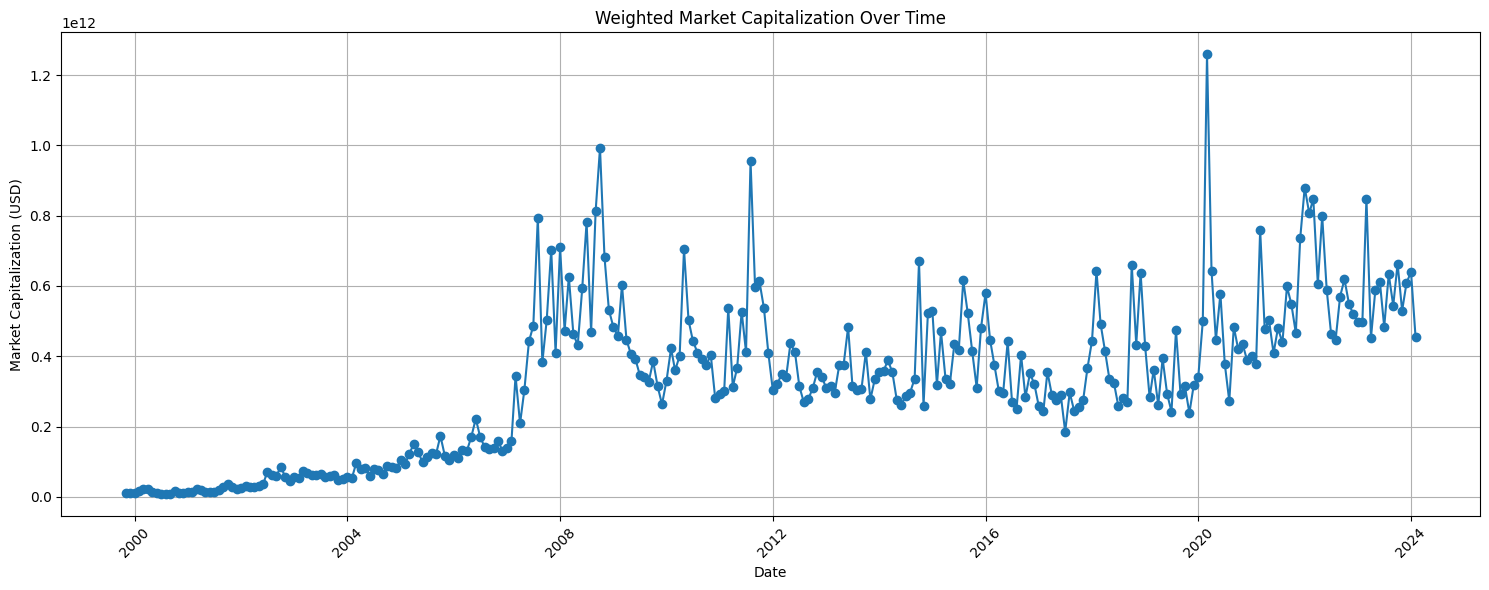

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df_market_final containing your data

# Convert 'Date-Time' to datetime format
df_market_final['Date-Time'] = pd.to_datetime(df_market_final['Date-Time'])

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df_market_final['Date-Time'], df_market_final['Weighted market capitalisation'], marker='o', linestyle='-')
plt.title('Weighted Market Capitalization Over Time')
plt.xlabel('Date')
plt.ylabel('Market Capitalization (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

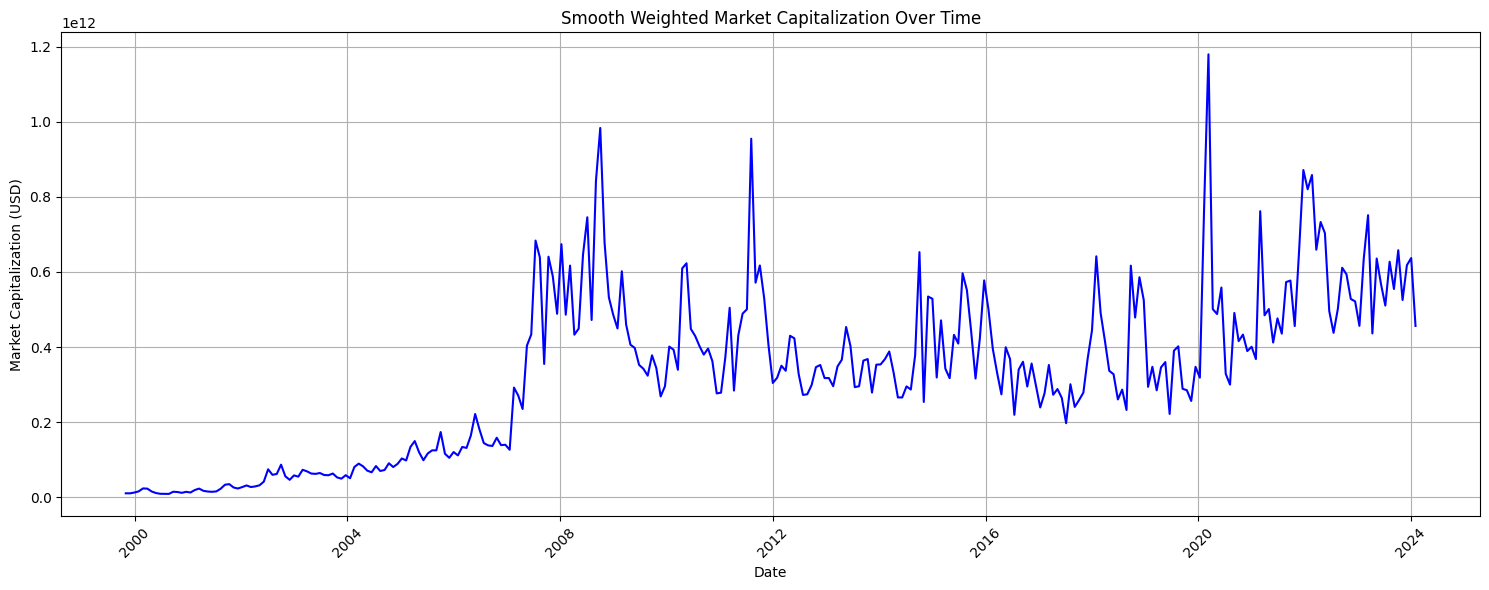

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Assuming you have a DataFrame named df_market_final containing your data

# Convert 'Date-Time' to datetime format
df_market_final['Date-Time'] = pd.to_datetime(df_market_final['Date-Time'])

# Sort DataFrame by 'Date-Time'
df_market_final.sort_values(by='Date-Time', inplace=True)

# Convert 'Date-Time' to numeric values
x_numeric = pd.to_numeric(df_market_final['Date-Time'])

# Interpolate y-values for smoother curve
spl = make_interp_spline(x_numeric, df_market_final['Weighted market capitalisation'])
x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 300)
y_smooth = spl(x_smooth)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(pd.to_datetime(x_smooth), y_smooth, linestyle='-', color='blue')
plt.title('Smooth Weighted Market Capitalization Over Time')
plt.xlabel('Date')
plt.ylabel('Market Capitalization (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


# Obesity, Nutrition & Physical Activity

In [ ]:
survey = pd.read_csv('/content/Nutrition_Physical_Activity_and_Obesity_Data.csv', dtype={
    "Age(years)": str,
    "Education": str,
    "Grade": str,
    "Income": str
})

In [ ]:
survey.head()

YearStart  YearEnd LocationAbbr          LocationDesc  \
0       2019   2019.0           AK                Alaska   
1       2019   2019.0           AZ               Arizona   
2       2019   2019.0           DC  District of Columbia   
3       2019   2019.0           IL              Illinois   
4       2019   2019.0           MD              Maryland   

                                Datasource                    Class  \
0  Youth Risk Behavior Surveillance System        Physical Activity   
1  Youth Risk Behavior Surveillance System  Obesity / Weight Status   
2  Youth Risk Behavior Surveillance System  Obesity / Weight Status   
3  Youth Risk Behavior Surveillance System        Physical Activity   
4  Youth Risk Behavior Surveillance System  Obesity / Weight Status   

                          Topic  \
0  Physical Activity - Behavior   
1       Obesity / Weight Status   
2       Obesity / Weight Status   
3  Physical Activity - Behavior   
4       Obesity / Weight Status   

                                            Question  Data_Value_Unit  \
0  Percent of students in grades 9-12 who achieve...              NaN   
1  Percent of students in grades 9-12 who have ob...              NaN   
2  Percent of students in grades 9-12 who have ob...              NaN   
3  Percent of students in grades 9-12 who partici...              NaN   
4  Percent of students in grades 9-12 who have an...              NaN   

  Data_Value_Type  Data_Value  Data_Value_Alt Data_Value_Footnote_Symbol  \
0           Value         9.6             9.6                        NaN   
1           Value        13.3            13.3                        NaN   
2           Value        17.1            17.1                        NaN   
3           Value        65.9            65.9                        NaN   
4           Value        16.7            16.7                        NaN   

  Data_Value_Footnote  Low_Confidence_Limit  High_Confidence_Limit  \
0                 NaN                   5.5                   16.5   
1                 NaN                  10.7                   16.5   
2                 NaN                  16.2                   17.9   
3                 NaN                  49.8                   79.1   
4                 NaN                  14.5                   19.2   

   Sample_Size  Total Age(years) Education Gender Grade Income  \
0        130.0    NaN        NaN       NaN    NaN   NaN    NaN   
1       1739.0  Total        NaN       NaN    NaN   NaN    NaN   
2       8978.0  Total        NaN       NaN    NaN   NaN    NaN   
3        876.0    NaN        NaN       NaN    NaN  10th    NaN   
4       2573.0    NaN        NaN       NaN    NaN   NaN    NaN   

    Race/Ethnicity                        GeoLocation ClassID TopicID  \
0            Asian  (64.845079957001, -147.722059036)      PA     PA1   
1              NaN      (34.86597028, -111.763811277)     OWS    OWS1   
2              NaN      (38.890371385, -77.031961127)     OWS    OWS1   
3              NaN      (40.485010283, -88.997710178)      PA     PA1   
4  2 or more races      (39.290580964, -76.609260111)     OWS    OWS1   

  QuestionID DataValueTypeID  LocationID StratificationCategory1  \
0       Q048           VALUE         2.0          Race/Ethnicity   
1       Q038           VALUE         4.0                   Total   
2       Q038           VALUE        11.0                   Total   
3       Q049           VALUE        17.0                   Grade   
4       Q039           VALUE        24.0          Race/Ethnicity   

   Stratification1 StratificationCategoryId1 StratificationID1  
0            Asian                      RACE           RACEASN  
1            Total                       OVR           OVERALL  
2            Total                       OVR           OVERALL  
3             10th                     GRADE           GRADE10  
4  2 or more races                      RACE         RACE2PLUS

In [ ]:
survey_pivoted = survey.pivot(index=['YearStart', 'LocationAbbr', 'Datasource', 'StratificationID1'], columns='Question', values='Data_Value')

In [ ]:
# @title Obesity trend across years
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
cleaned_data = pd.read_csv("/content/Cleaned_Nutrition_Physical_Activity_and_Obesity_Data.csv")

# Filter data to get obesity related data
adult_obesity_data = cleaned_data[cleaned_data['Question'] == 'Percent of adults aged 18 years and older who have obesity']
student_obesity_data = cleaned_data[cleaned_data['Question'] == 'Percent of students in grades 9-12 who have obesity']

print(len(adult_obesity_data))
print(len(student_obesity_data))
# Plot adult obesity trend across years
plt.plot(adult_obesity_data.groupby('YearStart')['Data_Value'].mean(), marker='o', label='Adults')

# Plot student obesity trend across years
plt.plot(student_obesity_data.groupby('YearStart')['Data_Value'].mean(), marker='o', label='Students')

plt.title('Obesity Trends Across Years')
plt.xlabel('Year')
plt.ylabel('Average Percent of Population with Obesity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/Cleaned_Nutrition_Physical_Activity_and_Obesity_Data.csv'

Text(0.5, 1.0, 'Obesity Rate Across Years')

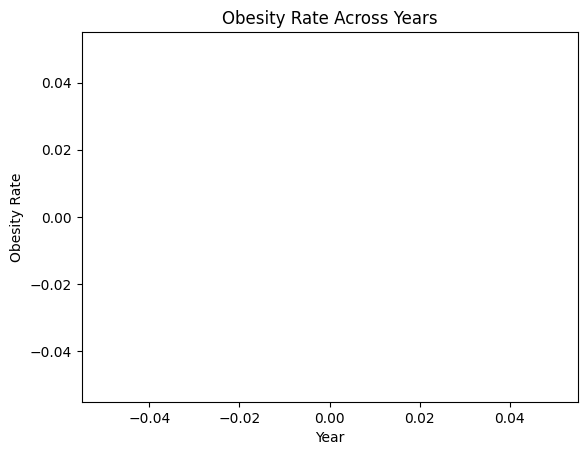

In [ ]:
# @title Forecasting obesity rate with simple linear regression. Does this make any sense?

# Looks like obesity rate across years fit a line quite well

nutrition_physical_obesity = pd.read_csv("/content/Nutrition_Physical_Activity_and_Obesity_Data.csv")
adult_obesity_data = nutrition_physical_obesity.query("Question == 'Percent of adults aged 18 years and older who have obesity'") \
                                        .groupby("YearStart")["Data_Value"].mean()

sns.regplot(x=adult_obesity_data.index, y=adult_obesity_data.values)

plt.xlabel("Year")
plt.ylabel("Obesity Rate")
plt.title("Obesity Rate Across Years")

So we could use simple linear regression to forecast obesity rate. We could say something like "at this rate adult obesity gonna reach 40% within 10 years💀". Idk if this make any sense at all. If it does of course we can do the same thing to student obesity

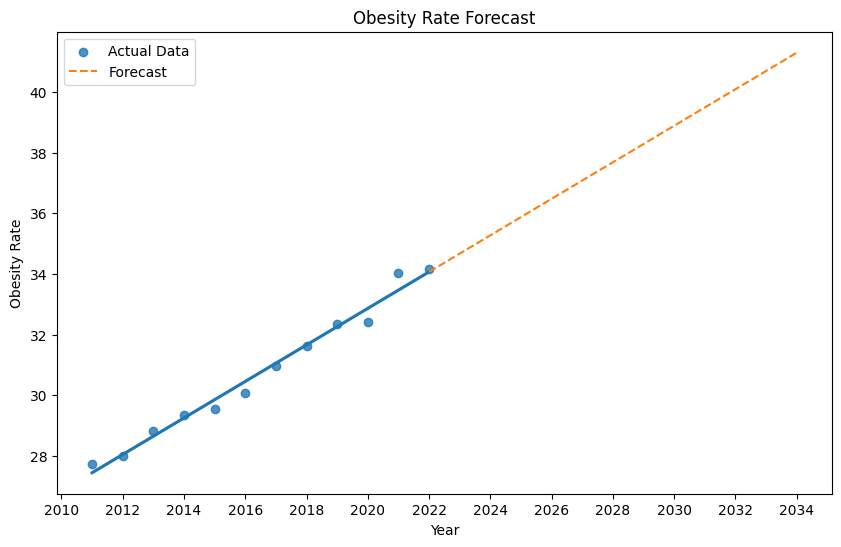

In [ ]:
coefficients = np.polyfit(adult_obesity_data.index, adult_obesity_data.values, 1)
regression_line = np.poly1d(coefficients)

forecast_years = np.arange(2022, 2035)

forecast_obesity_rate = regression_line(forecast_years)

plt.figure(figsize=(10, 6))
sns.regplot(x=adult_obesity_data.index, y=adult_obesity_data.values, ci=None, label='Actual Data')
plt.plot(forecast_years, forecast_obesity_rate, '--', label='Forecast')

plt.xticks(range(2010, 2035, 2))
plt.xlabel("Year")
plt.ylabel("Obesity Rate")
plt.title("Obesity Rate Forecast")
plt.legend()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have already loaded and processed your data into adult_obesity_data

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(adult_obesity_data.index.values.reshape(-1, 1),
                                                    adult_obesity_data.values,
                                                    test_size=0.2,
                                                    random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Coefficients
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)

# R-squared
print("R-squared:", model.score(X_test, y_test))

# Mean Absolute Error (MAE)
print("MAE:", mean_absolute_error(y_test, y_pred))

# Mean Squared Error (MSE)
print("MSE:", mean_squared_error(y_test, y_pred))

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.residplot(X_test.flatten(), residuals.flatten(), lowess=True, color="g")
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Actual vs. Predicted plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel("Year")
plt.ylabel("Obesity Rate")
plt.title("Actual vs. Predicted")
plt.legend()
plt.show()


In [ ]:
# @title Obesity trends across locations
plt.figure(figsize=(12, 6))

# Plot adult obesity trend across locations
adult_location_means = adult_obesity_data.groupby('LocationDesc')['Data_Value'].mean()
plt.bar(adult_location_means.index, adult_location_means, alpha=0.7, label='Adults')

# Plot student obesity trend across locations
student_location_means = student_obesity_data.groupby('LocationDesc')['Data_Value'].mean()
plt.bar(student_location_means.index, student_location_means, alpha=0.7, label='Students')

plt.title('Obesity Trends Across Locations')
plt.xlabel('Location')
plt.ylabel('Average Percent of Population with Obesity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

KeyError: 'LocationDesc'

<Figure size 1200x600 with 0 Axes>

In [ ]:
cleaned_data['LocationDesc'].drop_duplicates().sort_values()

27                    Alabama
0                      Alaska
1                     Arizona
46                   Arkansas
97                 California
164                  Colorado
81                Connecticut
53                   Delaware
2        District of Columbia
30                    Florida
90                    Georgia
18                       Guam
54                     Hawaii
31                      Idaho
3                    Illinois
49                    Indiana
20                       Iowa
21                     Kansas
43                   Kentucky
100                 Louisiana
28                      Maine
4                    Maryland
130             Massachusetts
107                  Michigan
59                Mississippi
409                  Missouri
6                     Montana
32                   National
7                    Nebraska
120                    Nevada
35              New Hampshire
47                 New Jersey
8                  New Mexico
9         

In [ ]:
# Mapping of states to regions
state_to_region = {
    'Alabama': 'South',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'South',
    'District of Columbia': 'Other',  # not a state
    'Florida': 'South',
    'Georgia': 'South',
    'Guam': 'Other',  # not a state, but a territory
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'South',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'South',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Puerto Rico': 'Other',  # Puerto Rico is not a state but included for completeness
    'Rhode Island': 'Northeast',
    'South Carolina': 'South',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virgin Islands': 'Other', # territory
    'Virginia': 'South',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West',

}

print(len(state_to_region))

54


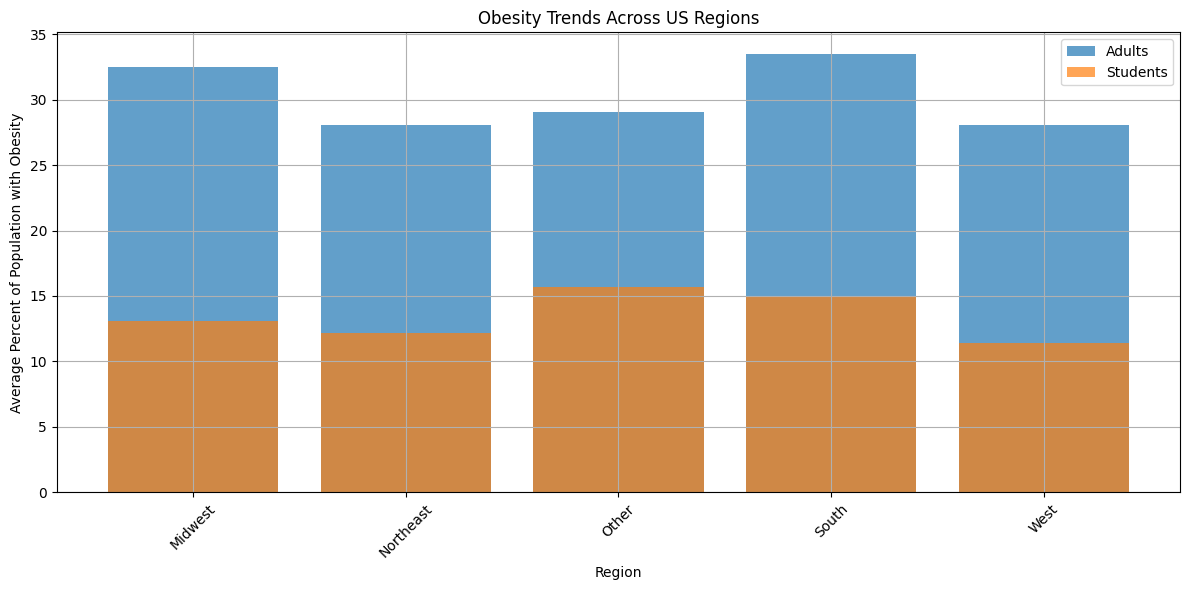

In [ ]:
# @title Obesity trends across US Regions
# Filter out rows that contains data about the National US data
filtered_data = cleaned_data[cleaned_data['LocationDesc'] != 'National']

# Add a new column for region
filtered_data['Region'] = filtered_data['LocationDesc'].map(state_to_region)

# Plotting obesity trends across regions
plt.figure(figsize=(12, 6))

# Plot adult obesity trend across regions
adult_region_means = filtered_data[filtered_data['Question'] == 'Percent of adults aged 18 years and older who have obesity'].groupby('Region')['Data_Value'].mean()
plt.bar(adult_region_means.index, adult_region_means, alpha=0.7, label='Adults')

# Plot student obesity trend across regions
student_region_means = filtered_data[filtered_data['Question'] == 'Percent of students in grades 9-12 who have obesity'].groupby('Region')['Data_Value'].mean()
plt.bar(student_region_means.index, student_region_means, alpha=0.7, label='Students')

plt.title('Obesity Trends Across US Regions')
plt.xlabel('Region')
plt.ylabel('Average Percent of Population with Obesity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


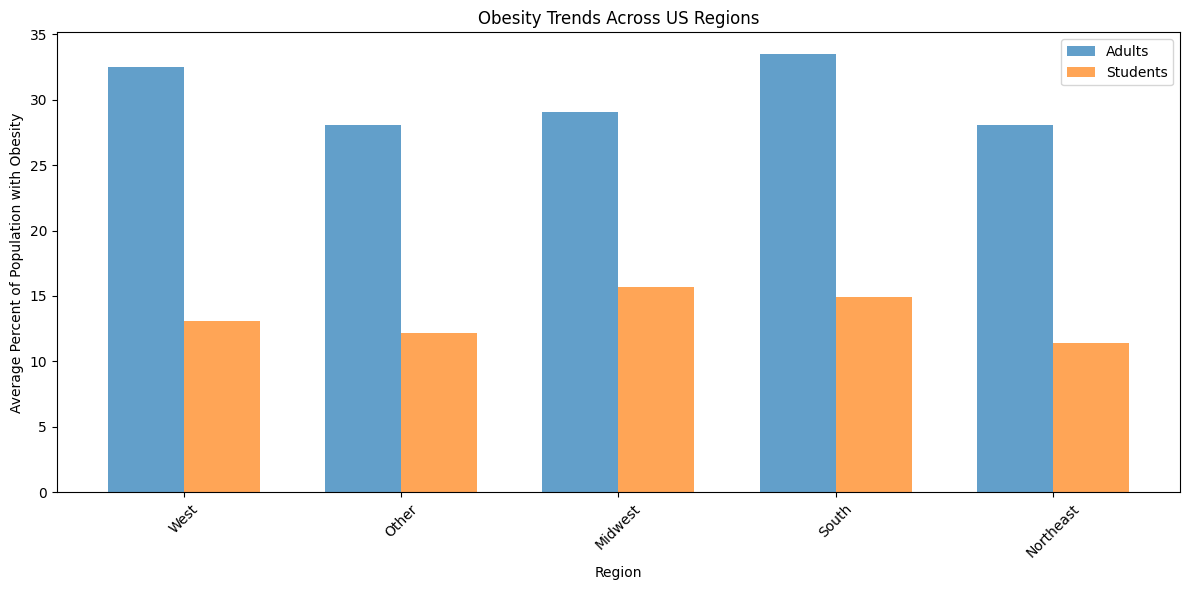

In [ ]:
import matplotlib.pyplot as plt

# Filter out rows that contain data about the National US data
filtered_data = cleaned_data[cleaned_data['LocationDesc'] != 'National']

# Add a new column for region
filtered_data['Region'] = filtered_data['LocationDesc'].map(state_to_region)

# Plotting obesity trends across regions
plt.figure(figsize=(12, 6))

# Define the width of the bars
bar_width = 0.35

# Define the x positions for the bars
regions = filtered_data['Region'].unique()
x = range(len(regions))

# Plot adult obesity trend across regions
adult_region_means = filtered_data[filtered_data['Question'] == 'Percent of adults aged 18 years and older who have obesity'].groupby('Region')['Data_Value'].mean()
plt.bar(x, adult_region_means, width=bar_width, alpha=0.7, label='Adults')

# Plot student obesity trend across regions
student_region_means = filtered_data[filtered_data['Question'] == 'Percent of students in grades 9-12 who have obesity'].groupby('Region')['Data_Value'].mean()
plt.bar([i + bar_width for i in x], student_region_means, width=bar_width, alpha=0.7, label='Students')

# Set labels and title
plt.xlabel('Region')
plt.ylabel('Average Percent of Population with Obesity')
plt.title('Obesity Trends Across US Regions')
plt.xticks([i + bar_width/2 for i in x], regions, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


# Commodities
Prices for coffee, corn and sugar on the stock market, recorded monthly from 1990 to 2023

In [ ]:
commodities = pd.read_csv("/content/all_commodities.csv", parse_dates=["Date-Time"])
commodities.sample(5)

Filling in missing values that are obviously (probably) for corn

In [ ]:
commodities['Unit'] = commodities['Unit'].fillna('Dollar per Metric Ton')
commodities['Commodity'] = commodities['Commodity'].fillna('Corn')

Quick plot to see how stock prices varied. Different units so lines are not relative to each other

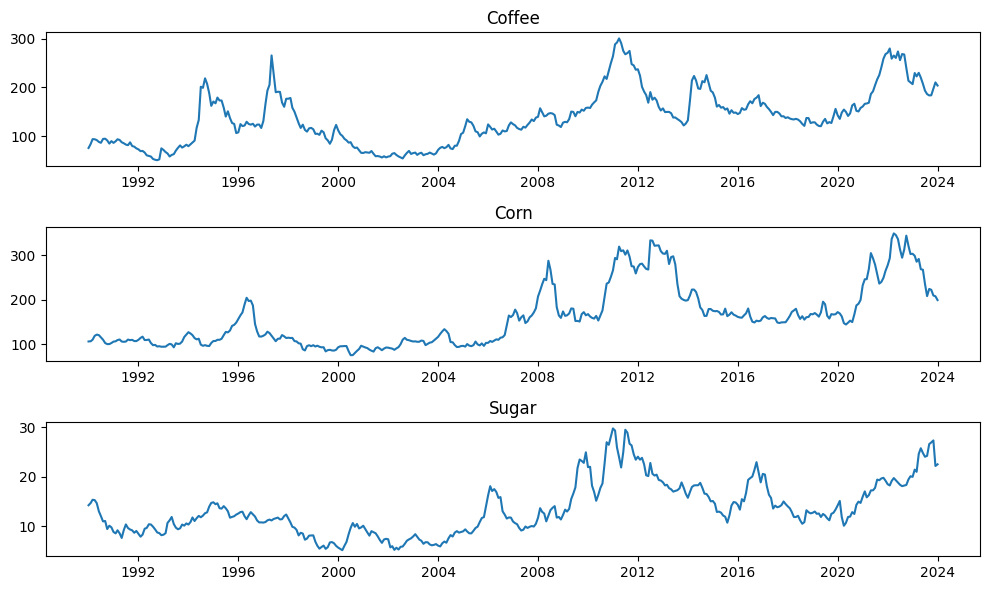

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
for ax, (commodity, data) in zip(axes, commodities.groupby("Commodity")):
    ax.plot("Date-Time", "Value", data=data)
    ax.set_title(commodity)

plt.tight_layout()

Somehow all three commodities prices follow a similar pattern. Maybe they are correlated, or maybe it's just the general market trend

## Sugar price vs youth sugar drinks consumption and obesity

In [ ]:
# Warning: not working on our cleaned data
nutrition_physical_obesity = pd.read_csv("/content/Nutrition_Physical_Activity_and_Obesity_Data.csv", parse_dates=["YearStart"])

(0.0, 31.59090656000176)

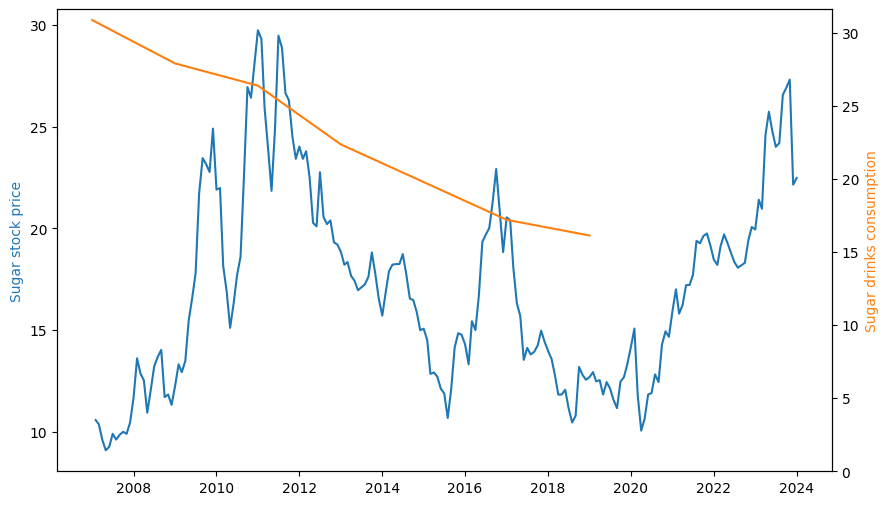

In [ ]:
sugar_price_data = commodities.query("Commodity == 'Sugar' and `Date-Time` > '2007-01-01'")

sugar_drinks_data = nutrition_physical_obesity.query("Question == 'Percent of students in grades 9-12 who drank regular soda/pop at least one time per day'") \
                                              .groupby("YearStart")["Data_Value"].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot("Date-Time", "Value", data=sugar_price_data, color="tab:blue")
ax2.plot("YearStart", "Data_Value", data=sugar_drinks_data, color="tab:orange")

ax1.set_ylabel("Sugar stock price", color="tab:blue")
ax2.set_ylabel("Sugar drinks consumption", color="tab:orange")

ax2.set_ylim(ymin=0)

Honestly I don't know what to say about this graph, there are only 5 distinct years. Looks like sugar drink is getting less popular regardless of the price. Which could be interesting to find out why? (Try plot with soft drink companies' stock)

* I think there's a decline in the sugar consumption (2006-2019) and the stocks also has a downtrend. However they have a pull back in the 2019-2024 period (Probably the sugar consumption also raise in this period although the data is missing)

## Corn price vs meat production
I found online that corn is the largest expense in livestock production - it helps animals put on weight, so let's see if it's price affect meat production

In [ ]:
cold_storage = pd.read_csv("/content/Meat_Stats_Cold_Storage.csv", parse_dates=["Date"])

In [ ]:
corn_price_data

Date-Time       Value                   Unit Commodity
409 2024-01-01  198.757928  Dollar per Metric Ton      Corn

Text(0, 0.5, 'Beef cold storage')

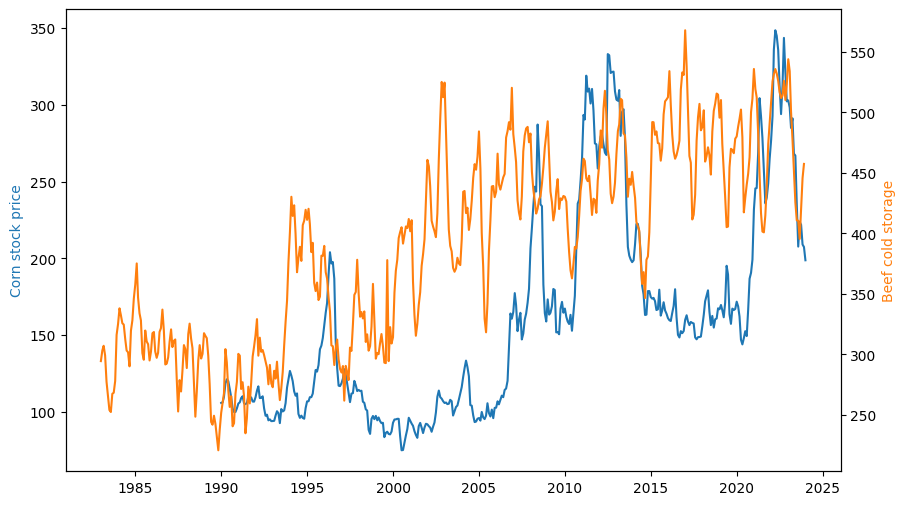

In [ ]:
corn_price_data = commodities.query("Commodity == 'Corn'")

beef_data = cold_storage.query("Animal == 'Beef'") \
                        .groupby("Date")["Weight"].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot("Date-Time", "Value", data=corn_price_data, color="tab:blue")
ax2.plot("Date", "Weight", data=beef_data, color="tab:orange")

ax1.set_ylabel("Corn stock price", color="tab:blue")
ax2.set_ylabel("Beef cold storage", color="tab:orange")

# ax2.set_ylim(ymin=0)

Text(0, 0.5, 'Broilers Production')

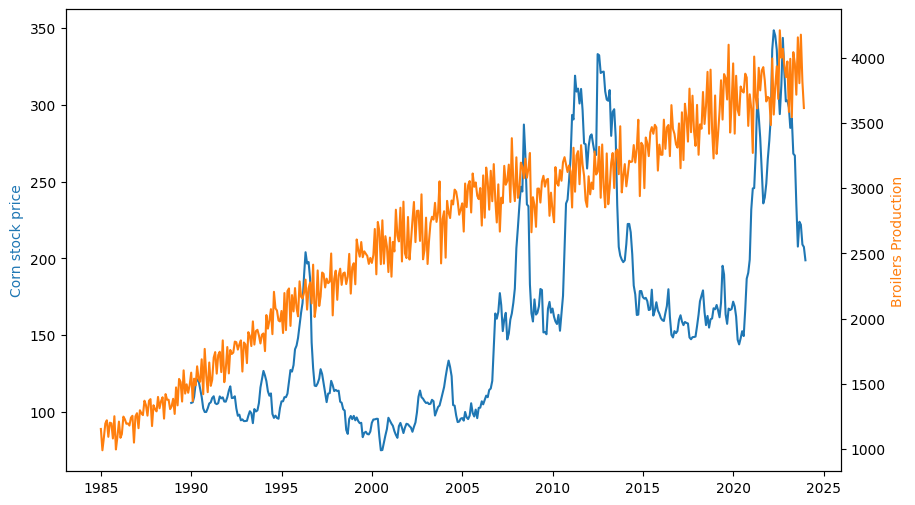

In [ ]:
corn_price_data = commodities.query("Commodity == 'Corn'")

beef_data = meat_prod.query("Animal == 'Broilers'").drop('Date', axis=1) \
                        .groupby("Date")["Production"].mean().reset_index().iloc[300:]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot("Date-Time", "Value", data=corn_price_data, color="tab:blue")
ax2.plot("Date", "Production", data=beef_data, color="tab:orange")

ax1.set_ylabel("Corn stock price", color="tab:blue")
ax2.set_ylabel("Broilers Production", color="tab:orange")

# ax2.set_ylim(ymin=0)

Well, that's rather disappointing. There doesn't seem to be any obvious connection here.

# Random

Check this choropleth out! I don't know if it has any value but it demonstrates clearly the increase of obesity rates over the years

In [ ]:
obesity_data = nutrition_physical_obesity.query("Question == 'Percent of adults aged 18 years and older who have obesity'") \
                                         .groupby(["LocationAbbr", "YearEnd"])["Data_Value"].mean().reset_index()

px.choropleth(
    obesity_data,
    locationmode="USA-states",
    locations="LocationAbbr",
    color="Data_Value",
    scope="usa",
    color_continuous_scale="Viridis",
    range_color=(20, 40),
    animation_frame="YearEnd",
    title="Obesity Rates in the US"
)